# HOOI: Higher-Order Orthogonal Iteration of Tensors

This code block involves prototyping and hardening a HOOI algorithm for handling missing data in 3D Tensors. 

Tensor algorithm is based on https://www-users.cs.umn.edu/~saad/PDF/umsi-2006-132.pdf

The data is a text database. Tensor Algorithm is applied to treat missing data. Later HOOI matrix is used for anaylsing B L R V vectors of the dataset.

### HOOI error documentation:
Errors related to HOOI
Input Tensor dimensions as d1,d2,d3
Core Tensor B r1,r2,r3

1) The tensor elements should be integers or we get the following error, (or no null values which is not practical for my case)
ArpackError: ARPACK error 3: No shifts could be applied during a cycle of the Implicitly restarted Arnoldi iteration. One possibility is to increase the size of NCV relative to NEV. 

2) The r1,r2,r3 has to be smaller than corresponding dimensions of the tensor or we get the following error, 
ValueError: k must be between 1 and min(A.shape), k=3

3) if d1>d2*d3 or d2>d1*d3 or d3>d1*d2, we get the following error, for(d1=2,d2=210,d3=100)
due to SVD
ValueError: k must be between 1 and min(A.shape), k=210


In [1]:
import scipy.sparse.linalg as l
import numpy as np
def hooi(A,dim,n): 
    (x,y,z)=A.shape
    #print("A "+str(A.shape))
    (r1,r2,r3) = dim

    R_init = np.random.rand(y,y)
    R,w,v = l.svds(R_init,r2)
    #print("R "+str(R.shape))
    
    V_init = np.random.rand(z,z)
    V,w,v = l.svds(V_init,r3)
    #print("V "+str(V.shape))

    for i in range(n):
        # Calculate L estimate
        C2 = np.tensordot(A,R,axes=(1,0))
        #print("C2 "+str(C2.shape))
        C1 = np.tensordot(C2,V,axes=(1,0))
        #print("C1 "+str(C1.shape))
        C = C1.reshape(x,r2*r3)
        L,w,v = l.svds(C,r1)
        #print("L "+str(L.shape))
    
        # Calculate R estimate
        D2 = np.tensordot(A,L,axes=(0,0))
        #print("D2 "+str(D2.shape))
        D1 = np.tensordot(D2,V,axes=(1,0))
        #print("D1 "+str(D1.shape))
        D = D1.reshape(y,r1*r3)
        #print("D "+str(D.shape))
        R,w,v = l.svds(D,r2)
        #print("R "+str(R.shape))
    
        # Calculate V estimate
        E2 = np.tensordot(A,L,axes=(0,0))
        E1 = np.tensordot(E2,R,axes=(0,0))
        #print("E1 "+str(E1.shape))
        E = E1.reshape(z,r1*r2)
        V,w,v=l.svds(E,r3)

    # Calculate the core tensor
    B = np.tensordot(E1,V,axes=(0,0))
    
    # Calculate the covergence
    M2 = np.tensordot(B,L,axes=(0,1))
    M1 = np.tensordot(M2,R,axes=(0,1))
    M = np.tensordot(M1,V,axes=(0,1))
    AA = (A-M)*(A-M)
    a=sum(sum(sum(AA)))
    model = (B,L,R,V)
    converge = (a,M)
    
    return model,converge

In [2]:
def replace_zeros(A,M):
    (x,y,z) = A.shape
    #print("A "+str(A.shape))
    #print("M "+str(M.shape))
    for i in range(x-1):
        for j in range(y-1):
            for k in range(z-1):
                if (A[i,j,k]==0):
                    if (M[i,j,k]> 0):
                        print(A[i,j,k],M[i,j,k])
                        A[i,j,k]=M[i,j,k]
    return A

In [3]:
def tensoor(x,y,z,rate):
    import random
    import numpy as np
    
    #print("A "+str(A.shape))
    #print("M "+str(M.shape))
    #A=np.array()
    
    A=np.random.rand(x,y,z)
    #A=np.random.randint(10, size=(x,y,z))
    #rate=10*rate
    
    for i in range(x-1):
        for j in range(y-1):
            for k in range(z-1):
                if A[i,j,k]<rate:
                    A[i,j,k]=np.nan
    return A

    #return A

In [8]:
Tens=tensoor(3,300,123,0.1)  
Tens

array([[[0.68117124, 0.51867672, 0.92129124, ..., 0.47405173,
         0.68651461, 0.00564936],
        [0.55596203, 0.93606001, 0.22614426, ..., 0.78668203,
         0.39643459, 0.22467418],
        [0.16492103,        nan, 0.59091283, ..., 0.96345842,
         0.61208661, 0.92906509],
        ...,
        [0.33365602, 0.23771288, 0.96581775, ...,        nan,
         0.43722606, 0.17399548],
        [0.77240318, 0.5118719 , 0.20023879, ..., 0.18995674,
         0.86328216, 0.19018831],
        [0.36000476, 0.93095534, 0.06953287, ..., 0.78381418,
         0.60815772, 0.06541361]],

       [[0.28063129, 0.95530427, 0.65861805, ..., 0.37183748,
         0.96778233, 0.03734756],
        [0.9237902 , 0.94812115, 0.3942359 , ...,        nan,
         0.16967109, 0.20132703],
        [0.82025641, 0.25255322,        nan, ...,        nan,
         0.34965385, 0.20403877],
        ...,
        [       nan, 0.87496606, 0.12878085, ..., 0.51900201,
         0.18951275, 0.07925087],
        [0.9

In [9]:
print(Tens,Tens.shape)
model,converge=hooi(Tens,(2,190,100),1)

[[[0.68117124 0.51867672 0.92129124 ... 0.47405173 0.68651461 0.00564936]
  [0.55596203 0.93606001 0.22614426 ... 0.78668203 0.39643459 0.22467418]
  [0.16492103        nan 0.59091283 ... 0.96345842 0.61208661 0.92906509]
  ...
  [0.33365602 0.23771288 0.96581775 ...        nan 0.43722606 0.17399548]
  [0.77240318 0.5118719  0.20023879 ... 0.18995674 0.86328216 0.19018831]
  [0.36000476 0.93095534 0.06953287 ... 0.78381418 0.60815772 0.06541361]]

 [[0.28063129 0.95530427 0.65861805 ... 0.37183748 0.96778233 0.03734756]
  [0.9237902  0.94812115 0.3942359  ...        nan 0.16967109 0.20132703]
  [0.82025641 0.25255322        nan ...        nan 0.34965385 0.20403877]
  ...
  [       nan 0.87496606 0.12878085 ... 0.51900201 0.18951275 0.07925087]
  [0.93318623 0.70414102        nan ... 0.47645601 0.28395751 0.49290713]
  [0.67032844 0.8445032  0.96053487 ... 0.30099325 0.21142656 0.73833598]]

 [[0.16491444 0.28171877 0.28122134 ... 0.50397146 0.51514263 0.35065954]
  [0.24826482 0.581979

ArpackError: ARPACK error 3: No shifts could be applied during a cycle of the Implicitly restarted Arnoldi iteration. One possibility is to increase the size of NCV relative to NEV. 

In [30]:
converge

(6412.733913916536,
 array([[[0.47754137, 0.67706759, 0.81062178, ..., 0.4755457 ,
          0.63954062, 0.59072962],
         [0.23910758, 0.43246286, 0.4817895 , ..., 0.46657362,
          0.50335613, 0.78798417],
         [0.58334278, 0.06067834, 0.40986262, ..., 0.46833107,
          0.47841006, 0.10498624],
         ...,
         [0.48635607, 0.75959548, 0.44286817, ..., 0.52097307,
          0.77411313, 0.72520439],
         [0.6245606 , 0.882209  , 0.49671605, ..., 0.43767564,
          0.49421493, 0.53452194],
         [0.90532147, 0.34596673, 0.41081824, ..., 0.48503196,
          0.37616814, 0.21563432]],
 
        [[0.4704527 , 0.60440779, 0.74393167, ..., 0.51245088,
          0.68677302, 0.59614607],
         [0.3565176 , 0.45353682, 0.44390398, ..., 0.48637362,
          0.43417444, 0.66539419],
         [0.61413836, 0.2178648 , 0.35623263, ..., 0.40203832,
          0.42431654, 0.1912049 ],
         ...,
         [0.46272202, 0.65435684, 0.55124619, ..., 0.59785174,
    

In [7]:
import json
import numpy as np

a = json.load(open('UNGDC_matrix.json'))
UNGDC_matrix_backup = np.array(a)
A = UNGDC_matrix_backup
type(A)
A.shape

(199, 100, 46)

In [8]:
model, converge = hooi(A,(3,3,3),1)
(a,M) = converge
_A = replace_zeros(A,M)
print(M)
print(_A)

0.0 2.271757138536385
0.0 3.1151560988366005
0.0 2.949737127909021
0.0 4.20089605430665
0.0 4.010266273292578
0.0 3.9224432948984367
0.0 3.8717581638410934
0.0 3.418231109356657
0.0 2.8797049170836937
0.0 2.7706501295415946
0.0 2.36204694685144
0.0 2.2141488304435653
0.0 2.119638775544542
0.0 1.910432991789138
0.0 2.030373879719734
0.0 1.8824442435639819
0.0 2.1934727172404056
0.0 1.7811710089746395
0.0 1.3951091938863247
0.0 1.3221159814714267
0.0 1.278927698584428
0.0 1.3046660561516115
0.0 1.2161707673959683
0.0 1.6517287223643016
0.0 1.699880822194064
0.0 1.5627594564677267
0.0 1.5145784913796718
0.0 1.6117784297444646
0.0 1.5699661558776723
0.0 1.8271280038034543
0.0 1.786889108924155
0.0 2.1354595813007546
0.0 1.939405035612114
0.0 1.8825175576989424
0.0 2.1960254762716893
0.0 2.16167417565789
0.0 2.758354532465954
0.0 2.860019553331399
0.0 3.054211303254208
0.0 3.0297790266289297
0.0 2.9253024543221313
0.0 3.07042260607223
0.0 2.9890015356915396
0.0 2.941492991490252
0.0 3.01927

0.0 1.243484595663586
0.0 1.5556656579931771
0.0 1.4359527348415912
0.0 1.5549659135715515
0.0 1.3187285024296118
0.0 1.5198216513855711
0.0 7.847358573673374
0.0 9.105394030532716
0.0 8.807289890101975
0.0 6.611839428842018
0.0 5.371309858682057
0.0 5.749080577457147
0.0 4.630596341152266
0.0 3.730380550577545
0.0 2.7107941651051313
0.0 2.612332860580616
0.0 2.5152277252434647
0.0 2.507566482244805
0.0 2.3283508189622277
0.0 3.130290690460524
0.0 3.20495485802292
0.0 2.9521472677931584
0.0 2.9598362279474513
0.0 3.0868237230442213
0.0 3.1048365375271607
0.0 3.565854581407518
0.0 2.6357977574981777
0.0 2.153935827547906
0.0 2.3977654927960055
0.0 1.5093551530307756
0.0 1.4767549503126256
0.0 1.2586378133947076
0.0 1.0544893786675886
0.0 1.049561145849102
0.0 0.9611349503541486
0.0 0.87807475948677
0.0 1.1266757506022944
0.0 1.1277010269250898
0.0 1.1007308271909035
0.0 1.0989761112770766
0.0 2.3359421433482552
0.0 2.2445145346335598
0.0 2.012311314663345
0.0 1.6748635185007994
0.0 1.62

0.0 1.1832551508956544
0.0 1.2212369101705667
0.0 1.2948438927759056
0.0 0.9696484649638079
0.0 1.2297591811586612
0.0 1.1177377129566548
0.0 1.8210552119114518
0.0 1.9341478019838136
0.0 2.645165914475305
0.0 1.7904278630686876
0.0 1.5521726153724233
0.0 1.5424705405755192
0.0 1.3297384800013894
0.0 1.2113343181133975
0.0 0.9666518768152635
0.0 0.9681501151153966
0.0 1.2054749767955262
0.0 1.1883397930075028
0.0 1.2956033089273367
0.0 0.9782337780605338
0.0 1.2402029915059218
0.0 1.128568216123753
0.0 2.4076531527560956
0.0 2.332644282037435
0.0 2.2605181485458545
0.0 2.7233103679316715
0.0 1.868828728616023
0.0 2.000543392144551
0.0 2.185294460113808
0.0 2.251367795463791
0.0 2.562960660687041
0.0 2.6410740649939077
0.0 2.600524699151269
0.0 1.7715403997367065
0.0 1.4943012290427922
0.0 1.3335652075825526
0.0 1.4435908116214424
0.0 0.9636047462872008
0.0 1.027073303536539
0.0 1.0983667950407274
0.0 1.0311621427261635
0.0 1.4015101187357508
0.0 1.3287779580501022
0.0 1.376377937801163

0.0 0.7818658217102
0.0 0.6801056895695591
0.0 0.7161756075494429
0.0 0.9535599607094413
0.0 0.7605715092933516
0.0 0.871196933683501
0.0 3.337339714467749
0.0 1.8617855703148762
0.0 2.309886984452185
0.0 2.613522006760686
0.0 2.9137175771470574
0.0 1.9243065900289555
0.0 1.698418294921211
0.0 1.6859639964906123
0.0 1.4274362009519657
0.0 1.3235024843005954
0.0 0.9364188208716926
0.0 0.9550787067389607
0.0 1.0357109661331148
0.0 0.9748025538165637
0.0 1.4120502211193684
0.0 1.1927018355069032
0.0 1.295419991939923
0.0 1.5084761012749255
0.0 1.068370716260561
0.0 1.3402606273410944
0.0 1.2203562821974907
0.0 3.7142436756581216
0.0 4.247682006532229
0.0 3.6733530697449694
0.0 4.112190278547138
0.0 4.158005846163677
0.0 4.108993476210391
0.0 2.3895304434696985
0.0 2.043876012627041
0.0 1.8945346429234897
0.0 1.881094395835652
0.0 1.5284386115489121
0.0 1.3351860670904467
0.0 1.3984130549220324
0.0 2.0177544872041846
0.0 1.8870638653873741
0.0 2.133812157614392
0.0 1.7184277554674423
0.0 1

0.0 1.4728625290764004
0.0 1.3559477735957726
0.0 2.0158500249457765
0.0 2.2689238466023807
0.0 2.6161930586766977
0.0 2.4337453401091236
0.0 2.5336774286405794
0.0 2.4329184531018715
0.0 1.5737741144351896
0.0 1.3456907550719186
0.0 1.2443577381016848
0.0 1.1632810339404243
0.0 1.176247955224072
0.0 1.361465481329042
0.0 1.033920238819799
0.0 1.1823541971115223
0.0 2.2026446955254575
0.0 1.467037013978597
0.0 1.400582217759589
0.0 1.2314823066779326
0.0 0.8774539306544672
0.0 0.8132216335903181
0.0 1.1091843143768514
0.0 1.1156408492938685
0.0 1.0865660538488353
0.0 0.9434052181912012
0.0 1.0849685971223038
0.0 3.2789932831535307
0.0 2.26416133742192
0.0 2.199007335024456
0.0 2.0871964160851273
0.0 1.719546536289237
0.0 1.348257543460787
0.0 1.3088175423162145
0.0 1.8046202642244653
0.0 4.916577873694866
0.0 3.9677349114210867
0.0 3.896052514110973
0.0 2.322615501021648
0.0 2.3371110745115953
0.0 2.1725971383870486
0.0 2.925287684186213
0.0 3.000550199966063
0.0 2.88286215604551
0.0 2

0.0 1.0973099888059412
0.0 0.9594467935763012
0.0 1.103867033815137
0.0 1.9426282838887978
0.0 1.941886704481802
0.0 2.0073073796168446
0.0 1.4328250788248194
0.0 1.3158600542858965
0.0 1.3490950921708873
0.0 1.7144066479726017
0.0 1.629601832487035
0.0 1.6707359146255172
0.0 1.8647954710293801
0.0 1.7914007187106842
0.0 1.0858950442336348
0.0 1.0123397729600667
0.0 1.4133441858223865
0.0 1.3402798335472446
0.0 1.3409517464285083
0.0 1.3509275225864068
0.0 1.5070935805128247
0.0 1.410212105088542
0.0 1.2958363137991769
0.0 2.0799871572609976
0.0 2.2430232570263633
0.0 2.280497082165071
0.0 2.7448429664042675
0.0 2.608595016117909
0.0 2.5404841343935134
0.0 2.4653726228019206
0.0 2.4194136437738183
0.0 1.4829387560263831
0.0 1.4394565692564483
0.0 1.4551324235101906
0.0 1.3091456554455134
0.0 1.098752813095575
0.0 0.9944530339712393
0.0 1.0378441686671747
0.0 1.258576622591853
0.0 1.3486396414523345
0.0 1.2867275701799203
0.0 1.3820348997326588
0.0 1.0730253298083938
0.0 1.2381723684984

0.0 1.7682363816638504
0.0 2.020233621405225
0.0 2.0130739593884512
0.0 2.1227829111733465
0.0 2.405185208444703
0.0 2.370169044992011
0.0 2.356149616885113
0.0 2.374377210332549
0.0 2.5276388364996807
0.0 1.7834894475124132
0.0 1.5551703967625907
0.0 1.5354694368664512
0.0 1.2617746229407893
0.0 1.372336280456933
0.0 1.2133818130944958
0.0 0.9843338307907599
0.0 0.8751185660306632
0.0 0.8976532525459366
0.0 0.9484328940240752
0.0 0.8888928836011318
0.0 1.2224293608961136
0.0 1.2670837640558263
0.0 1.1865694581706623
0.0 1.183070221090536
0.0 0.9884872162068417
0.0 1.1313895744198275
0.0 2.197390905547763
0.0 1.4231358937615857
0.0 1.2531481432793299
0.0 0.9057947040639954
0.0 0.8519929887035733
0.0 0.7895293518093186
0.0 2.386803652667835
0.0 2.075283717374759
0.0 1.7441182431520217
0.0 1.193260997719028
0.0 1.5925279772349392
0.0 2.805047733022524
0.0 1.9688849321923703
0.0 1.9856745942190008
0.0 2.3853786108252244
0.0 2.477129234953903
0.0 2.719584034877924
0.0 2.682467935617384
0.0

0.0 1.574841847244895
0.0 1.7695519095582473
0.0 1.5093472874722809
0.0 1.54313350897367
0.0 1.3830788975378994
0.0 1.6764665872616669
0.0 1.6173470650774864
0.0 1.8031436529772642
0.0 2.737417915900956
0.0 2.441311706734802
0.0 1.726528746103546
0.0 1.2891536972248372
0.0 1.1145331006109882
0.0 0.9816952234697729
0.0 1.0619347275022188
0.0 1.3019619025169396
0.0 1.3268753595102964
0.0 1.3032476208738117
0.0 1.429015594358751
0.0 1.3478886372261514
0.0 1.1750547630912707
0.0 2.1346867251132813
0.0 2.7662986693715417
0.0 1.4423799919267601
0.0 1.3895361640399564
0.0 1.1399915906937257
0.0 1.0189570704952347
0.0 1.2964015641854352
0.0 1.3129524152349035
0.0 1.3518901468736455
0.0 3.531746641481691
0.0 2.5024746944705805
0.0 2.045554901927248
0.0 1.6241255392569687
0.0 1.4758555298498974
0.0 1.8136285950532365
0.0 2.0927103759842547
0.0 1.8784815934918733
0.0 1.9464287635695343
0.0 3.869359539476479
0.0 4.473170636932098
0.0 3.3594063611736398
0.0 3.3641393777038355
0.0 3.5633585241650696

0.0 1.5526997300292575
0.0 1.4370994973832376
0.0 2.6089872719566998
0.0 1.3263862878869883
0.0 1.8104393281554283
0.0 1.6994493251903127
0.0 7.542271209365316
0.0 3.8992739905292018
0.0 3.8318923649980827
0.0 4.523642539863064
0.0 1.9800707681100085
0.0 2.2152353711424593
0.0 1.9315338451976993
0.0 1.6353750020238502
0.0 1.4884220663748031
0.0 1.4162758470156862
0.0 1.426410676938212
0.0 1.409149988437823
0.0 1.499480818329491
0.0 1.2276393912036452
0.0 1.4250130782905137
0.0 1.4918337274971252
0.0 1.2209857709040075
0.0 1.0806654994866784
0.0 1.0099278422434033
0.0 1.04579961482992
0.0 0.8057067088970026
0.0 0.7136837945713426
0.0 0.7705927789728829
0.0 0.7687753767169553
0.0 0.7132920927264967
0.0 0.9541117433177924
0.0 0.9764373903265382
0.0 0.9462176603657656
0.0 1.0019407327037821
0.0 0.9562460284166527
0.0 1.0101626357664792
0.0 0.7559123294285999
0.0 0.9718820579348612
0.0 0.8742356751133981
0.0 1.561584202118044
0.0 1.5470684546727125
0.0 1.5930223986030139
0.0 1.5364632770139

0.0 1.2399784311472486
0.0 1.2168892731455083
0.0 1.1703635386303708
0.0 1.0582605356637138
0.0 1.027347263358322
0.0 1.1041167743953424
0.0 0.7135685070516729
0.0 0.7283476834255133
0.0 0.7294870377386884
0.0 0.6775846035811011
0.0 0.9103383835164012
0.0 0.9327570136447428
0.0 0.8816821175031694
0.0 0.9044798639564858
0.0 0.9034179496679691
0.0 0.975250267920024
0.0 8.74405779716155
0.0 4.434658484735747
0.0 4.235418078892173
0.0 4.583515166762218
0.0 3.6148588638741908
0.0 2.932104553852484
0.0 2.7501120547555553
0.0 1.556460081595907
0.0 1.9005091455772511
0.0 2.0082264315078615
0.0 1.8937261133628904
0.0 1.9228856550118218
0.0 1.855506710472951
0.0 1.2543014609178325
0.0 1.2254839166084202
0.0 1.0284759815723814
0.0 0.7113697635686823
0.0 0.6852899529044366
0.0 0.8968490314471258
0.0 0.8830409708140764
0.0 0.9117787338667875
0.0 1.0547267652761712
0.0 1.5338276795596681
0.0 1.8660255435834274
0.0 1.797508705328883
0.0 1.787365832319909
0.0 1.1816054001771943
0.0 1.0100423534718355


0.0 2.288143004205169
0.0 2.1420572263602526
0.0 1.7369115840234823
0.0 1.4502556137716978
0.0 1.310896936706822
0.0 1.3525264760807751
0.0 1.5592502354827862
0.0 1.3870748037195377
0.0 1.2678406347053206
0.0 1.226594719019584
0.0 0.9091139085800272
0.0 0.8838015303857715
0.0 0.9290432856149999
0.0 0.8164717073703365
0.0 0.7397814789262543
0.0 0.9266174614051166
0.0 1.1719271632995647
0.0 1.0216897123522075
0.0 0.9447103039649476
0.0 1.120085541892671
0.0 1.930156979818142
0.0 1.874774302748074
0.0 1.3665458290094388
0.0 1.3207743645010748
0.0 1.2011141049724738
0.0 0.8482803527066505
0.0 0.775737445402904
0.0 0.7012237356273378
0.0 0.8585516408089753
0.0 1.1265915905478647
0.0 0.9613719773146757
0.0 1.3231008355367733
0.0 1.323628524795046
0.0 1.3602169078606547
0.0 1.2829992194702684
0.0 1.1832283810391122
0.0 1.149206252829047
0.0 1.230233610583627
0.0 0.8070364108659337
0.0 0.84024000143706
0.0 0.8753911520253708
0.0 1.0531423362933978
0.0 1.3462255477106977
0.0 1.8256948620249043


0.0 1.190559027770471
0.0 1.2089810254360043
0.0 1.6167035231908748
0.0 1.5628459682615783
0.0 1.4994920616710028
0.0 1.5710949170507937
0.0 1.3555975744882927
0.0 2.3046773329852837
0.0 2.1320105505398423
0.0 2.2754142222449425
0.0 2.8224507078724175
0.0 2.6449441852738196
0.0 2.571494026196245
0.0 2.5977725237482896
0.0 2.3296135833449996
0.0 2.4979604457373705
0.0 2.649381000298855
0.0 3.0439631050874536
0.0 1.5442979822800784
0.0 1.2697679005842966
0.0 1.163623476208757
0.0 1.2363191237113267
0.0 1.2206233728633273
0.0 0.9528577403415905
0.0 0.8194561651533108
0.0 0.8091544095541712
0.0 0.9455609045636326
0.0 0.9002953046632434
0.0 1.289022587028888
0.0 1.3608503757412582
0.0 1.2349244094922118
0.0 0.9882347758951568
0.0 1.1899290640248443
0.0 1.4627502162828292
0.0 0.9759395687199235
0.0 1.2239250971533737
0.0 1.1065071456141131
0.0 6.581217364785026
0.0 2.6661160113375204
0.0 2.991835646316971
0.0 2.8838164531460486
0.0 2.9834086820749404
0.0 3.1224922933393215
0.0 2.934135503113

0.0 2.0479715111044396
0.0 2.252738945338435
0.0 1.9595753601809363
0.0 1.8823432294754345
0.0 1.8601114494228714
0.0 1.5739875084842134
0.0 1.5500245865270346
0.0 1.8101591314853647
0.0 1.5104015265121935
0.0 1.1688332137988173
0.0 1.0579765342616076
0.0 1.0197022806975506
0.0 1.1287707179612847
0.0 1.0662355539706216
0.0 1.497939952495148
0.0 1.5669608142716822
0.0 1.4197848618995166
0.0 1.2117138402824426
0.0 1.408687069743245
0.0 1.750546680353155
0.0 1.2759150763423492
0.0 1.529746525378181
0.0 6.157368273682706
0.0 7.052843668061342
0.0 2.0586805373374215
0.0 1.6158883889435243
0.0 3.358183001100274
0.0 2.862682200326632
0.0 2.334481701686389
0.0 2.0084530090482446
0.0 1.8927619016585087
0.0 1.7704430242848745
0.0 1.3251403281364034
0.0 1.312725908385109
0.0 1.3219597915200727
0.0 1.2293441001559984
0.0 1.5849767289359975
0.0 1.5880036275345768
0.0 1.5364790410800717
0.0 1.8177334628860364
0.0 1.7547221577010839
0.0 7.490354585283916
0.0 7.820706385470057
0.0 6.865177254016558
0.

0.0 2.3444064885509177
0.0 2.371883483053042
0.0 2.040530661753844
0.0 2.5913290721502853
0.0 2.076284622852684
0.0 1.2313310127582546
0.0 1.205203405205072
0.0 1.0392994062409666
0.0 0.8945783862167184
0.0 0.8679533814162984
0.0 0.9233084527721178
0.0 0.8019836928527698
0.0 0.7248388353453846
0.0 0.9008935743129545
0.0 0.886582404268946
0.0 0.8914462610735892
0.0 1.1752061989066176
0.0 0.9774077023344833
0.0 0.9791040175707982
0.0 0.9137894437777382
0.0 1.0914482218595851
0.0 1.0615502945123692
0.0 1.3139653119278494
0.0 1.4823172123207924
0.0 1.3149432676799446
0.0 1.518427375633594
0.0 1.7941176878359935
0.0 2.0287522789841206
0.0 2.2113471429210145
0.0 2.0851523512378667
0.0 2.338995427430425
0.0 1.734719654697114
0.0 1.8014330254451916
0.0 1.1759446271841905
0.0 1.00378455386259
0.0 0.90475373708597
0.0 0.8235394811576499
0.0 1.0434951883164274
0.0 1.0389266778183306
0.0 1.054743045949598
0.0 1.1135509153902419
0.0 1.0654610523176367
0.0 1.1509851932370265
0.0 1.0539313807953932
0

0.0 2.2624717113708273
0.0 2.096881841336281
0.0 2.6774790968755906
0.0 2.765640345499102
0.0 2.675517196175938
0.0 3.1394065636065025
0.0 3.7917193803990448
0.0 1.3481193207746063
0.0 1.5435006491418135
0.0 1.6182039584710235
0.0 1.8783790579034165
0.0 1.5676349445373898
0.0 1.8720411847705025
0.0 3.0769863774752397
0.0 3.107805925102227
0.0 2.9007223313046184
0.0 1.7462144455030053
0.0 1.8616719696703712
0.0 1.9132581577940426
0.0 1.629974647538308
0.0 1.1463225782530184
0.0 1.1164857869036988
0.0 1.1402565456604283
0.0 0.9453525600844828
0.0 1.2075479905098407
0.0 1.3758152448515344
0.0 2.025435790862059
0.0 1.676317284515903
0.0 1.5938053999914923
0.0 1.4505619262582234
0.0 1.5987187592330365
0.0 1.4366017715436399
0.0 1.0522948162765111
0.0 1.0186373764235068
0.0 0.957002918622414
0.0 0.9760263149544897
0.0 1.273709699659911
0.0 1.155147545049765
0.0 1.1011476221246148
0.0 1.2024270831033714
0.0 1.507476578405123
0.0 1.4079667415927575
0.0 1.407759644729233
0.0 4.548560353169193
0

0.0 1.2600719110918086
0.0 1.2800837905096443
0.0 1.1385456489898471
0.0 1.5023193310904865
0.0 1.5251755948561168
0.0 2.327067744818301
0.0 2.181790205905884
0.0 1.144525102325939
0.0 1.0993639816494094
0.0 1.324670359446087
0.0 1.3164693870339088
0.0 1.4306855082832655
0.0 5.232309668160449
0.0 3.5694529860595146
0.0 2.9790788620330253
0.0 2.5870093842584914
0.0 2.0868302512545815
0.0 2.4485169668191724
0.0 1.541370583807891
0.0 1.1649682396464827
0.0 1.0103189259702579
0.0 1.4464423381464255
0.0 2.085827286113704
0.0 3.0810997273238065
0.0 2.1249479867363803
0.0 2.214252572372367
0.0 1.158536521795522
0.0 1.0988868154747442
0.0 1.0697547107557142
0.0 0.9859094444062354
0.0 1.3149195240133942
0.0 1.316392075944021
0.0 1.4652824619015268
0.0 1.3926739781273902
0.0 1.8028576501385933
0.0 1.90666901282766
0.0 1.9098145512333262
0.0 1.902239303799243
0.0 1.9430508518629936
0.0 1.836402195348413
0.0 1.8248414946652598
0.0 1.6227466957668928
0.0 1.5547043465702315
0.0 1.4866847327297597
0.

0.0 1.276802952736329
0.0 1.6860870068045442
0.0 1.5970943587364401
0.0 1.5929878675105824
0.0 4.825226149326036
0.0 5.657709581396354
0.0 5.318400117754422
0.0 2.4885619827295273
0.0 3.176034279408673
0.0 3.1553023079476796
0.0 3.3933909964239013
0.0 2.314077060046783
0.0 2.566125900319879
0.0 2.823576655533778
0.0 2.9217617836920393
0.0 2.8798737165973574
0.0 2.811057172280134
0.0 2.360863392378509
0.0 1.8833235245399387
0.0 1.5692223387629016
0.0 1.4596165184460028
0.0 1.078339827707293
0.0 1.1134322492313573
0.0 1.4390538656216891
0.0 1.48139242090044
0.0 1.4006092986667598
0.0 1.5928315704581986
0.0 1.4914785878989105
0.0 1.3808099659244726
0.0 2.455504641636589
0.0 2.3168981173622694
0.0 2.987626845574417
0.0 2.158548941810059
0.0 2.4685703602187727
0.0 1.7645392374031195
0.0 1.3958892579861604
0.0 1.9639637962730634
0.0 2.0676140621621233
0.0 2.4570035713640297
0.0 2.3147843940890027
0.0 2.5264099078078197
0.0 2.335285962938679
0.0 2.011317730280592
0.0 1.8802391209608682
0.0 1.

0.0 1.0834784773597412
0.0 0.9918876420559257
0.0 1.5442529066268786
0.0 1.3384866637267934
0.0 1.3102038470749753
0.0 1.060702928617825
0.0 8.866481137449323
0.0 5.345692379964828
0.0 3.0968330302067164
0.0 5.475728162561397
0.0 4.103483927334322
0.0 2.224393449547693
0.0 2.4509335284266354
0.0 1.5370272885007947
0.0 1.7607411824773196
0.0 1.6759408565710245
0.0 1.4389727646668244
0.0 1.97295129768407
0.0 2.019472703649997
0.0 1.4000321734921057
0.0 1.3235998628621746
0.0 1.2212021611940658
0.0 1.0660337607717967
0.0 0.9800436819882261
0.0 1.0756462548375663
0.0 0.9868741553898376
0.0 0.9015236342508459
0.0 1.1546802061025743
0.0 1.155909810445166
0.0 1.2158250361740817
0.0 1.2026591705586298
0.0 1.0036012819984934
0.0 1.1691221115801291
0.0 2.7867636146934407
0.0 2.4076179174960073
0.0 1.7837783225822537
0.0 1.9575002086338094
0.0 1.7922038376835168
0.0 2.1277051343261273
0.0 1.8352846311435131
0.0 2.4222050669573547
0.0 2.340469058092082
0.0 1.815001977456204
0.0 1.0132146877053991


0.0 1.4726009333623875
0.0 1.2357401933593497
0.0 1.3090830537973897
0.0 1.1084997685475415
0.0 0.8786583474213305
0.0 0.8418779750907128
0.0 0.7714995450845681
0.0 0.9988359736689376
0.0 1.0043192100826819
0.0 0.9712917847780029
0.0 1.1265631147219264
0.0 1.1212927853258152
0.0 0.9683690101180017
0.0 1.1513656780427204
0.0 1.7356004270739795
0.0 1.7797743250164448
0.0 1.7013537711779065
0.0 1.652418603982741
0.0 1.5875447266715352
0.0 1.0753481423916722
0.0 1.1264019885741832
0.0 1.396989068010924
0.0 2.1852319085350054
0.0 2.2491241907671706
0.0 2.24865284978827
0.0 2.2768164146923144
0.0 2.190611749015131
0.0 2.3361481784871647
0.0 1.451090399495019
0.0 1.3422264359610094
0.0 1.3377634500305096
0.0 1.6347944507562036
0.0 1.4856747897587699
0.0 1.3996943950540766
0.0 1.2590660677132666
0.0 1.3176599884551283
0.0 1.1044478556059816
0.0 0.909229584880557
0.0 0.7560412001143436
0.0 0.9411504950719983
0.0 0.9280953504071336
0.0 1.2883304332679328
0.0 2.14465532134594
0.0 2.20736410196575

0.0 2.3035680425620138
0.0 1.0667512818141993
0.0 1.3163726416903867
0.0 4.950695595589871
0.0 3.4847616578127383
0.0 2.0290405313525004
0.0 2.8883786265617477
0.0 2.9333070276171886
0.0 3.2177466413855447
0.0 2.765138153991957
0.0 2.6857357030687417
0.0 2.1722323822377794
0.0 2.3380937028048137
0.0 1.292316588686943
0.0 2.549985348446292
0.0 2.465578174659354
0.0 2.5909692470334993
0.0 2.4616657354198814
0.0 2.525843295298026
0.0 2.6757929082331535
0.0 2.6807626144826258
0.0 2.5735950866981328
0.0 2.5929352468137763
0.0 2.6829894864711106
0.0 2.5507727776758067
0.0 2.5421566307406955
0.0 1.0443359705045963
0.0 1.2701292061956544
0.0 1.295238038544548
0.0 1.1115425935770062
0.0 2.2046451888741476
0.0 2.2520768078372173
0.0 2.339729126755674
0.0 2.2533037242360114
0.0 1.8521685576340596
0.0 1.8773879816578063
0.0 1.5687495886096656
0.0 0.9360030800625208
0.0 0.8594405598082242
0.0 1.151907696468867
0.0 1.2541547865663256
0.0 4.296347860909547
0.0 2.578890628342271
0.0 1.7562915029135966

0.0 0.8975421653144933
0.0 0.8929263899345115
0.0 1.1195933542241907
0.0 0.9613861908850371
0.0 0.873001849046981
0.0 1.0553336134636049
0.0 1.561585408686508
0.0 1.0245269210357961
0.0 1.5479214388889482
0.0 1.7691770240065818
0.0 0.9568103609793394
0.0 1.0732056178617297
0.0 1.009829812607639
0.0 1.2145948276630059
0.0 0.9583605794103252
0.0 1.2552388181515652
0.0 1.1193806838709897
0.0 1.6223204559992281
0.0 1.7578541385250754
0.0 2.448546862428373
0.0 2.093447348370842
0.0 1.5341403941644634
0.0 1.4874739223842532
0.0 1.4031607246438411
0.0 1.3786008043742517
0.0 1.2768314793300641
0.0 1.0357779633366426
0.0 0.9524635750016796
0.0 1.0489729553167668
0.0 0.9578132351931455
0.0 1.1160393966989093
0.0 1.3764382945103655
0.0 1.179617930669107
0.0 0.9705202787791593
0.0 1.1315778909809604
0.0 4.687539851293139
0.0 4.729204691383128
0.0 7.463020626238456
0.0 5.053767634534469
0.0 5.435908930711448
0.0 4.84034410275225
0.0 3.4443758606006787
0.0 1.422321731443198
0.0 2.0716294334712506
0.

0.0 1.3000638970992107
0.0 1.1909564187795152
0.0 1.01511068895676
0.0 0.9169974008311607
0.0 0.8350518401192448
0.0 1.0594356493782033
0.0 1.0555202902555512
0.0 1.1289452731037823
0.0 1.082066532182701
0.0 0.9121215310100463
0.0 1.066555173539507
0.0 2.4093441724722915
0.0 2.8683670689919523
0.0 2.6858028515947896
0.0 2.1442559413433147
0.0 2.691986689908599
0.0 2.581311877078597
0.0 2.94814338146177
0.0 3.4423268228963964
0.0 3.428813671480074
0.0 3.7783351476681344
0.0 4.177427143055337
0.0 3.5287583645001317
0.0 3.0681358609106706
0.0 3.197388982957626
0.0 2.9410825337383844
0.0 2.5467091319244424
0.0 2.4135903734747055
0.0 2.0318437567399026
0.0 1.7947689526315396
0.0 1.6487876423320869
0.0 1.4990595898342522
0.0 1.8935002075865022
0.0 1.9085109211331523
0.0 3.276719337210932
0.0 3.10817750707915
0.0 2.9458402424502603
0.0 3.846506156134991
0.0 2.1746987732734127
0.0 2.1185026300299565
0.0 1.6070033457152153
0.0 1.6462263466236586
0.0 1.8259672012680308
0.0 2.738109175516
0.0 2.3

0.0 0.868093037403606
0.0 0.8367189909517542
0.0 1.009432884559684
0.0 0.9128389201834058
0.0 1.009023444389952
0.0 1.0633304875497753
0.0 1.0632840137254145
0.0 1.4996083940334801
0.0 1.7828161586081868
0.0 1.9237855126297745
0.0 1.8568330431718172
0.0 1.9737840406868778
0.0 1.9584892270155532
0.0 1.9656469967159003
0.0 2.0709564432235026
0.0 2.0395888866607774
0.0 1.9856826346034027
0.0 1.151270368849948
0.0 1.0408865288826796
0.0 0.8036911945230025
0.0 0.9672349990231669
0.0 1.0669645238145553
0.0 1.0030680564295515
0.0 1.0814405814359462
0.0 0.8743324841998561
0.0 1.2673387953981154
0.0 1.7033309840224142
0.0 1.6861745554707432
0.0 1.9251744990517703
0.0 1.413197193747726
0.0 1.511283954452652
0.0 1.257538888258968
0.0 1.0924841670575713
0.0 0.8182936455078248
0.0 0.7753401776289295
0.0 0.8186273967045626
0.0 0.7485637435721391
0.0 0.8620286775496752
0.0 1.0391426839523477
0.0 0.9563505178571826
0.0 0.8298160869335323
0.0 1.0044231365667613
0.0 0.9604755830616174
0.0 4.885107882523

0.0 1.258472998547338
0.0 1.2297125089336158
0.0 1.2310829344333813
0.0 1.3999971633412842
0.0 1.190939305889605
0.0 0.9337434428627606
0.0 0.8369832067656086
0.0 0.822129771368173
0.0 0.9037016942632168
0.0 0.8525930381030012
0.0 1.1936088688185338
0.0 1.246922352014629
0.0 1.1395944798928501
0.0 0.993899628721481
0.0 1.1286406346205249
0.0 1.3727736885420634
0.0 0.99149511312016
0.0 1.206145323622252
0.0 1.1267481207476948
0.0 2.670772251798686
0.0 2.666749977327695
0.0 2.480720260780439
0.0 2.5846798705336784
0.0 2.6150463060690896
0.0 2.402635694741105
0.0 2.560396407945354
0.0 2.251489273945425
0.0 1.8964937919776352
0.0 1.5949152268064266
0.0 1.3830808357682642
0.0 1.4716047830346475
0.0 1.276010860854913
0.0 0.9332277763155714
0.0 0.9833525541473187
0.0 0.9213075318676975
0.0 1.266347423635785
0.0 1.3119617524966558
0.0 1.222084086420604
0.0 1.2247238517270331
0.0 1.0570508686266564
0.0 1.2989495472032628
0.0 1.207774592019401
0.0 1.0696267223291065
0.0 0.9940887417257244
0.0 1.

0.0 5.165014242833533
0.0 5.072285762083669
0.0 4.284719386502823
0.0 3.7882685803874017
0.0 3.480777097406679
0.0 3.9296926589478884
0.0 2.5708743598244093
0.0 2.4476085983298286
0.0 2.36452086615367
0.0 2.90558308507793
0.0 2.364418752396944
0.0 2.2614694945871077
0.0 1.8590688445461785
0.0 1.6682659389952355
0.0 1.4653241180354455
0.0 1.5371115343398718
0.0 1.0695002057005907
0.0 1.0208035796731225
0.0 1.1219528867039872
0.0 1.1093810066287781
0.0 1.3687319271847762
0.0 1.191340311680218
0.0 1.2303634387228577
0.0 1.0892472183363684
0.0 1.3120254101595383
0.0 1.261732818751063
0.0 2.302038001438667
0.0 2.333464255764924
0.0 1.5550199206961746
0.0 1.6192328852145945
0.0 1.741413388854563
0.0 1.011668055744637
0.0 0.9144921386814265
0.0 0.8306114505816361
0.0 1.0476441568497412
0.0 1.0392461923393177
0.0 2.178971656829946
0.0 2.0994184262887723
0.0 1.8945039486187063
0.0 1.7297117958407289
0.0 1.5454868263047978
0.0 1.3500809208595326
0.0 1.3182228541612884
0.0 0.9887649380914783
0.0 

0.0 0.9654991629536519
0.0 1.3288872283350526
0.0 1.3803705883788897
0.0 1.3438821734994764
0.0 1.3153875191111908
0.0 1.296687036596741
0.0 1.3230570429433774
0.0 0.8343953086724257
0.0 1.190870205785082
0.0 0.9713078749072056
0.0 10.269597421752984
0.0 2.221995406239331
0.0 1.0176574584661802
0.0 1.6444972162321652
0.0 1.6960913781727773
0.0 2.0824359541027277
0.0 2.2934340103523136
0.0 2.073422079090617
0.0 1.8431446011015769
0.0 2.0305333909857373
0.0 1.4503446512405354
0.0 1.6471052222833047
0.0 1.475061145535217
0.0 1.4930140985090585
0.0 1.0913622954954665
0.0 1.2737112421209285
0.0 1.1880254183309158
0.0 1.6591461611104827
0.0 1.0994256850202917
0.0 1.2795100798594923
0.0 1.875109059477228
0.0 1.7356826120408975
0.0 2.4113629416991373
0.0 3.400702266829378
0.0 3.5847247022759445
0.0 3.3002830974380664
0.0 2.2391306009979286
0.0 2.056497471739386
0.0 1.7953119336284833
0.0 1.6054861632864394
0.0 1.5617513256925075
0.0 1.3475985715998087
0.0 1.2912121398013932
0.0 1.2057780722914

0.0 0.9227549302296427
0.0 1.0851521696090078
0.0 0.9252197614045957
0.0 1.1400745213999617
0.0 2.649002309058934
0.0 2.628789372527511
0.0 2.6506000715017355
0.0 2.7076776473875217
0.0 2.490318876919561
0.0 2.6531270397826954
0.0 2.6112341748154204
0.0 2.5555049567471166
0.0 1.6727379405500535
0.0 1.3891079139150404
0.0 1.4871120577748411
0.0 1.3030892701394043
0.0 1.0575391348996757
0.0 0.972280157289069
0.0 0.946503276285457
0.0 2.5671409735392654
0.0 2.4203282271430018
0.0 1.2869873636637803
0.0 0.876905427968105
0.0 0.925490774048064
0.0 0.8674595747895915
0.0 1.1942508870511428
0.0 1.2377840725273788
0.0 1.0638205153492999
0.0 1.1507723560003982
0.0 1.3726700585506275
0.0 1.0357855423124456
0.0 1.1802921664324313
0.0 3.5709424476660576
0.0 4.7599345332219425
0.0 3.947364950109129
0.0 3.8013036816358836
0.0 3.6138345985368785
0.0 3.437082192434433
0.0 2.9522680332206095
0.0 2.5703830073908405
0.0 2.4547787696012686
0.0 2.0847906496781152
0.0 2.062369743627015
0.0 2.043037264324959

0.0 0.794104312178044
0.0 0.767078073397646
0.0 0.8593008587990417
0.0 0.6985023033265179
0.0 0.8556706182770464
0.0 1.6282992181905513
0.0 1.3324783933469242
0.0 1.3335914276704441
0.0 1.2539876440171056
0.0 1.035817252095099
0.0 0.9064218035251829
0.0 0.8878885771897524
0.0 0.95692947678288
0.0 0.8108249843002208
0.0 0.6636751541852625
0.0 0.6154496752910962
0.0 0.7502012182681059
0.0 0.78785343670972
0.0 0.75841647192477
0.0 0.8479191803525281
0.0 0.7005293160347106
0.0 0.8371127433048973
0.0 2.350275670376214
0.0 2.2941140862981135
0.0 1.4369811147804674
0.0 1.4093974551679824
0.0 1.5618738736597557
0.0 0.9867327234617616
0.0 0.9876839828560194
0.0 0.9852211277276296
0.0 0.9146139639228758
0.0 1.2276156763436905
0.0 1.1786982788486324
0.0 1.2052067149089005
0.0 1.2173190596266772
0.0 1.4076608034456197
0.0 1.1311786009947296
0.0 1.4603282281690737
0.0 1.5725654304493202
0.0 1.600936212789635
0.0 1.5406725989465866
0.0 1.5811189494888434
0.0 1.6076911703061374
0.0 1.6401372862843637

0.0 1.0661003796083313
0.0 0.9414910042040259
0.0 0.997341149665413
0.0 0.6494036739102215
0.0 0.6167562441511537
0.0 0.8353882009839761
0.0 0.8810221581501319
0.0 1.9655613669630976
0.0 1.4440153918535243
0.0 1.9015274339440644
0.0 3.0668416752972463
0.0 2.928459268080808
0.0 2.512855052738914
0.0 1.706493216149773
0.0 1.1529482163699798
0.0 1.1093093442353117
0.0 1.9019121378702415
0.0 1.9664420847660862
0.0 1.8921089947716674
0.0 1.8496332116470104
0.0 1.8547303976559457
0.0 1.7414556512663253
0.0 1.5152757658483642
0.0 1.5883533372743772
0.0 1.4233574167614855
0.0 1.4722229244966951
0.0 1.3775680220462563
0.0 1.420217736754728
0.0 1.3638616165733435
0.0 1.1600627142633702
0.0 1.1063699288182527
0.0 1.0515932817879527
0.0 0.9630344223818906
0.0 1.0128474224625303
0.0 1.05555855977769
0.0 0.7040363097299627
0.0 0.6658021002044301
0.0 0.663520009274498
0.0 0.6546133847114657
0.0 0.6065461538601128
0.0 0.8272246754556223
0.0 1.0185117813768607
0.0 1.1285023779583208
0.0 1.1408650657860

0.0 0.8043029258445187
0.0 0.7741081317322559
0.0 0.7138344364174659
0.0 0.9189883649399433
0.0 0.955431084164016
0.0 1.0365016255247033
0.0 0.8440613880495635
0.0 1.0299688999668826
0.0 1.9504288835748904
0.0 2.112763045055627
0.0 2.1371395641906443
0.0 2.0402979931221696
0.0 1.986482979348521
0.0 1.99449928116959
0.0 1.9244619653250885
0.0 1.935017906800125
0.0 1.707704578979818
0.0 1.6112386161376517
0.0 1.385881175103853
0.0 1.1844031936369408
0.0 1.178299885181988
0.0 1.1556044810323023
0.0 1.2244688119430003
0.0 1.0662192586722041
0.0 0.8003126593750032
0.0 0.8241223095185543
0.0 0.8253383383214037
0.0 0.7665532659676142
0.0 1.0294040443667556
0.0 1.0546854625929563
0.0 1.0008042296665451
0.0 1.0311842132923181
0.0 1.0229118077706023
0.0 1.1452629601210729
0.0 0.8925270787083159
0.0 1.093540460363724
0.0 1.0247538629228157
0.0 4.365029304502983
0.0 5.049687230744654
0.0 4.615638409121279
0.0 1.9948772545026816
0.0 2.6401241214817457
0.0 2.4728878648407453
0.0 2.60553121135717
0.0

0.0 3.1107620307923947
0.0 3.1861929462180556
0.0 2.3338461064595024
0.0 2.2711365981711125
0.0 2.3410311421917793
0.0 1.4574217043723139
0.0 1.7178249757724406
0.0 2.057422949855232
0.0 1.7030984360643278
0.0 3.5633474719881284
0.0 3.59253122084597
0.0 2.3438922060914007
0.0 1.920564614159076
0.0 1.8138592146207166
0.0 1.4522750283582688
0.0 1.309899232763937
0.0 1.3922478435250984
0.0 1.3050320325777602
0.0 1.861997999059387
0.0 1.6223666824568213
0.0 1.7338284270952884
0.0 2.032014654700615
0.0 1.8461762198245086
0.0 1.721782159518315
0.0 3.997957491471524
0.0 2.2974751271540903
0.0 1.4366156947675428
0.0 1.6956394455467763
0.0 1.770343868578641
0.0 2.0130158318660483
0.0 1.9702848789988467
0.0 3.7181668909143974
0.0 2.881275878463154
0.0 1.9401431050395486
0.0 1.8112248820692367
0.0 1.8581059459432174
0.0 1.807625998879072
0.0 1.6703296998060158
0.0 1.9170397956851015
0.0 2.586216632931096
0.0 2.6885864720539376
0.0 2.360917759884985
0.0 2.144213128673064
0.0 1.6726682566799655
0.0

0.0 1.9417258717194232
0.0 1.4383647181057528
0.0 1.2580655665262623
0.0 1.2070263964135544
0.0 1.3737412571265497
0.0 1.1457414236234402
0.0 0.9046401872103574
0.0 0.8223109150351114
0.0 0.8018825391803757
0.0 1.0474601437901858
0.0 0.9901434327347917
0.0 3.3742290054292887
0.0 3.2722620669654354
0.0 3.2919412271083206
0.0 3.6293937289426657
0.0 3.1997056862728517
0.0 3.524680684728871
0.0 3.500347525622432
0.0 1.7607160832724587
0.0 1.3478639472916585
0.0 1.3065471995366118
0.0 1.9050782008900948
0.0 1.555836085518986
0.0 4.622750278724076
0.0 5.933394950978378
0.0 7.017251408136588
0.0 4.573964528547548
0.0 3.5348061816867515
0.0 3.3812496208621643
0.0 3.2893184979826984
0.0 2.8805983931581007
0.0 2.940327105725084
0.0 2.8279738041327587
0.0 2.1200236936659143
0.0 1.9558239922684926
0.0 2.0157084252792137
0.0 1.8896468379196172
0.0 2.476353306001641
0.0 2.286632170786906
0.0 2.503480560807349
0.0 3.032374426363667
0.0 2.3155414482501793
0.0 2.7591432598506
0.0 1.266667829134547
0.0 

0.0 2.1139270910930246
0.0 2.1919128296108488
0.0 1.6588438337093923
0.0 1.6374624266236208
0.0 1.38673488917718
0.0 1.1548085032792341
0.0 1.1067303556237964
0.0 1.1430794578182033
0.0 0.9637771126180984
0.0 1.2414435243575557
0.0 1.2449704695115844
0.0 1.208869957514756
0.0 1.4253403939912472
0.0 1.2914399535310415
0.0 1.3908408896126023
0.0 1.214492261214728
0.0 1.4425096764344905
0.0 2.9703969196075586
0.0 2.543359315338424
0.0 2.628447846045372
0.0 3.0993740682475353
0.0 3.0331732403916885
0.0 4.92820959564036
0.0 3.5698266843820226
0.0 2.8060120703534306
0.0 2.071437469131752
0.0 1.9020373886588944
0.0 1.7386328495382193
0.0 2.4981607207625562
0.0 3.264314843815096
0.0 1.8549259566052085
0.0 2.0775635310524327
0.0 2.3217161215941484
0.0 2.4625040161261835
0.0 2.0564352752276993
0.0 1.7887761813710956
0.0 1.9146036305455327
0.0 1.7164223251545412
0.0 1.527620430995372
0.0 1.2372077815356866
0.0 1.1383809706203554
0.0 1.0372398601938073
0.0 1.3720308814641822
0.0 1.5956497632183182

0.0 2.309357130072601
0.0 2.239535885414611
0.0 1.7557652081422896
0.0 1.413584328974652
0.0 1.4082932570840785
0.0 1.7874884830133784
0.0 1.7499942469112515
0.0 1.798799502996247
0.0 1.6335863320130863
0.0 4.143562374924399
0.0 3.6345773987431085
0.0 2.30933876416088
0.0 2.127997002130065
0.0 2.2109355781843005
0.0 2.002409843083379
0.0 2.709922401437782
0.0 2.5957810261010725
0.0 2.3428007659464045
0.0 2.8693379509106354
0.0 2.6962109687583014
0.0 2.094307527970977
0.0 2.3880012347510777
0.0 2.4173296234401227
0.0 2.499237319097663
0.0 2.4974050629137143
0.0 2.741341378998351
0.0 2.7789311923868536
0.0 2.882629087346323
0.0 2.815757806099314
0.0 2.2316443587167805
0.0 2.1689578005924424
0.0 1.8652381006642844
0.0 1.1246051433196536
0.0 1.3510720257348885
0.0 1.3915094066450333
0.0 1.9289583406667639
0.0 2.142819111906962
0.0 2.125395830723906
0.0 2.25456807728974
0.0 2.51745002736394
0.0 1.6722521171271523
0.0 0.9871179969327236
0.0 1.059771598179079
0.0 1.3326811427705796
0.0 1.2898

0.0 2.37568001351663
0.0 2.1472560109371206
0.0 2.1416317576311052
0.0 1.9682462419824112
0.0 1.1874936827221072
0.0 1.4398541609633306
0.0 1.3929797966863608
0.0 1.47645524164226
0.0 2.0343395190936953
0.0 2.158423153485398
0.0 2.353855933190194
0.0 0.8333037663419501
0.0 1.0477497299853575
0.0 4.341908554409659
0.0 1.8142383825198252
0.0 1.90299822132709
0.0 1.5642668876300554
0.0 1.989869122322995
0.0 2.8547842806884116
0.0 2.191118297795138
0.0 2.137117709396526
0.0 1.9032729206934975
0.0 1.5897191069841907
0.0 1.360202259202244
0.0 1.7618115997933739
0.0 1.7333963503619167
0.0 1.8256170103609162
0.0 1.9207840775805485
0.0 1.617144757755866
0.0 2.726023198806361
0.0 3.64959783280258
0.0 3.846150041984385
0.0 3.0372061426405326
0.0 2.047115294925801
0.0 1.8897197433636839
0.0 2.0055450281077563
0.0 2.33875526051712
0.0 2.0734828009979975
0.0 1.9265855529516926
0.0 1.9754633174946146
0.0 1.6788227612427713
0.0 1.6941387567346402
0.0 1.4988781894163978
0.0 1.4578034017487638
0.0 1.431

0.0 1.877020246681002
0.0 1.8790540472612007
0.0 1.6259316598775377
0.0 1.3497158360314097
0.0 1.2596759969208502
0.0 1.3069321045262354
0.0 1.2541968853829244
0.0 1.1559684143128908
0.0 1.5202457352666396
0.0 1.5413696319076085
0.0 1.4831893594549703
0.0 1.6405742657014861
0.0 1.685924576386991
0.0 1.3844222422924324
0.0 1.6791966724036744
0.0 1.594457093260185
0.0 3.468821916218003
0.0 3.6029187576169646
0.0 2.3786471347572107
0.0 2.2012903747228076
0.0 2.081198996932756
0.0 1.4881435420067501
0.0 1.5463112066500542
0.0 1.9360288455199663
0.0 3.209394827420207
0.0 1.594561758692666
0.0 2.034174964223603
0.0 2.2255660997139715
0.0 2.356440804511751
0.0 2.3840994779995115
0.0 2.294188851617394
0.0 1.7337512183709496
0.0 1.7663849436616617
0.0 2.004131283397102
0.0 1.4730544169492032
0.0 1.4700533928827955
0.0 1.028736553492801
0.0 0.975214792496357
0.0 0.8879512607584802
0.0 1.1280648842588572
0.0 1.3696208730112502
0.0 1.1936192388335614
0.0 1.2384663990645028
0.0 1.321607681348214
0.

0.0 1.9904253863746544
0.0 2.0209811900926193
0.0 1.8442020425121082
0.0 1.7782017984642031
0.0 1.202612398957657
0.0 1.196543066673709
0.0 1.2656080004080583
0.0 1.0937786993313265
0.0 0.8881562296373003
0.0 0.8113483777746904
0.0 0.8266721671270965
0.0 0.8415940459425871
0.0 0.7839260211248942
0.0 1.0611490697271835
0.0 1.0913156211878565
0.0 1.026273384118368
0.0 1.0443030416094827
0.0 1.191180119973936
0.0 0.9169894049218456
0.0 4.353632249531633
0.0 1.6885913058381146
0.0 2.052887163800803
0.0 2.939725766149147
0.0 2.1863749344355337
0.0 1.9540122058463254
0.0 1.9079303527710563
0.0 1.3585632316212135
0.0 1.299848956832062
0.0 1.1838370479669547
0.0 1.4850046225108284
0.0 1.8342445608320097
0.0 1.673169216070054
0.0 2.959838968933713
0.0 3.127675057756829
0.0 3.0064127397359695
0.0 1.3389931800089565
0.0 1.229631357927802
0.0 1.126166600645645
0.0 1.5106046348741275
0.0 1.5839659456105764
0.0 1.7056839692242118
0.0 1.8677362708434848
0.0 1.885348496254491
0.0 1.9603382810874779
0.

0.0 1.682441914726195
0.0 1.566383874570909
0.0 1.4448635618822072
0.0 1.391353116168028
0.0 1.5802366504911922
0.0 1.2784263865981869
0.0 1.137212323574328
0.0 1.2853315986924279
0.0 2.10578636038173
0.0 1.5515625403759759
0.0 1.3289910914128702
0.0 1.335165616715278
0.0 1.6646749037502344
0.0 1.576494792626443
0.0 1.2031678743710332
0.0 2.0130621784492027
0.0 2.4528426100491934
0.0 3.2424557754873886
0.0 2.8096709075768445
0.0 1.6150862585399643
0.0 2.0384381861770917
0.0 1.9859732742233194
0.0 1.4843917068297934
0.0 1.215492862446245
0.0 1.0769046015579307
0.0 1.255422938501892
0.0 1.4721195308622557
0.0 1.228091052120499
0.0 1.2696792373149066
0.0 1.5025880176128825
0.0 3.9113249930077663
0.0 3.148517924398374
0.0 3.1594008511055796
0.0 3.7266815585972797
0.0 2.700203444815244
0.0 2.687115059125493
0.0 2.740115830440077
0.0 2.3401448668241804
0.0 2.1533368962017962
0.0 1.7449530415402847
0.0 1.545586402593666
0.0 1.8008164351935219
0.0 2.9200859717494314
0.0 2.110975790234434
0.0 1

0.0 2.145106152097258
0.0 2.110489748192333
0.0 2.193576624603576
0.0 2.1141837514444983
0.0 2.0642646288387763
0.0 1.3754975836960397
0.0 1.1864869079210332
0.0 1.0743288520634313
0.0 1.0003199432498608
0.0 1.02269701248175
0.0 0.9054192043681024
0.0 1.1015164206284045
0.0 6.283825967178382
0.0 3.438162918983662
0.0 2.9190774112365956
0.0 2.18039279077417
0.0 2.0417845306932447
0.0 2.6210235903083148
0.0 2.5237951437012476
0.0 2.113149925308605
0.0 2.5145923081405606
0.0 2.0239421406058544
0.0 3.816240908237852
0.0 4.757609629584078
0.0 5.799102264536589
0.0 5.147192428114973
0.0 4.393041923670132
0.0 3.7188620399475187
0.0 2.6248034928124104
0.0 2.208473016857583
0.0 2.2261731752536265
0.0 2.1692283204245335
0.0 1.6303003762222537
0.0 1.4863074676075776
0.0 1.4248249105408666
0.0 1.4807950097057279
0.0 2.1701902468645797
0.0 1.6835550919066262
0.0 2.4409837885192562
0.0 1.7994112542337863
0.0 2.1423026008694444
0.0 2.039312087481158
0.0 3.479982863066465
0.0 3.329244691099616
0.0 3.3

0.0 5.146233113124751
0.0 3.772967362299453
0.0 3.132046637225003
0.0 3.3411630615993895
0.0 2.8326917472886075
0.0 2.437331606712491
0.0 2.561760331820603
0.0 2.9712858992282314
0.0 2.861664456095086
0.0 2.8521747983575367
0.0 2.8567128542457527
0.0 2.7311947886890007
0.0 2.766252439650049
0.0 2.020248893842123
0.0 1.760046818923056
0.0 1.7183067325650416
0.0 1.4756319415869457
0.0 1.4251624359462174
0.0 1.368336020451214
0.0 1.096240139518559
0.0 0.9797445669178124
0.0 0.9921364309680166
0.0 1.3717428906506852
0.0 1.3179549633535665
0.0 1.1264776532448133
0.0 1.3898971104247304
0.0 1.2859592706892764
0.0 2.6039691075479
0.0 2.632619509616221
0.0 4.384514136363567
0.0 2.5773061606034116
0.0 2.8293715588555193
0.0 1.7886534437233872
0.0 1.8996428155364267
0.0 2.36821600366927
0.0 3.0968514566026224
0.0 2.8305732329349818
0.0 2.681043506853122
0.0 2.444821941659739
0.0 2.4155507778413177
0.0 2.3746976287847024
0.0 1.7645493341761929
0.0 1.6305897700152014
0.0 1.4207357307481756
0.0 1.34

0.0 1.8906248899978209
0.0 2.28576130788654
0.0 1.6794253079267982
0.0 1.4456310426934929
0.0 1.3770166542929594
0.0 1.3379542644335896
0.0 0.8630265925138804
0.0 0.7765533992358561
0.0 0.819416467181696
0.0 0.7681146189571035
0.0 1.0582402067206331
0.0 1.0968561824702083
0.0 1.0046911301150179
0.0 0.9263877235425172
0.0 1.0172379981548747
0.0 0.9494382471742218
0.0 2.4498692628487633
0.0 2.389092854808106
0.0 2.292447397479223
0.0 1.9692093752180235
0.0 1.033760871801914
0.0 0.8191113056096618
0.0 0.7553669790465208
0.0 0.9178377578161373
0.0 0.9289741054482301
0.0 1.1004519738012808
0.0 0.9233459276583429
0.0 1.06677257143045
0.0 2.4748504522034835
0.0 2.07899166099116
0.0 1.7875128822957995
0.0 1.7319825057314275
0.0 1.456286394949235
0.0 1.0098189765022458
0.0 1.3127612418499426
0.0 1.3524547682328931
0.0 1.260263740753836
0.0 1.2324218379000371
0.0 1.2836666798267926
0.0 1.16440034310844
0.0 1.3994377057378067
0.0 3.068128938930423
0.0 2.903991235564186
0.0 1.811475415474362
0.0 2

0.0 2.8329667172195574
0.0 2.4807106607209137
0.0 2.621228700504043
0.0 2.4356609494067625
0.0 2.235353584231958
0.0 1.811262153050442
0.0 1.7213386477613588
0.0 1.7303578305761638
0.0 1.6744933438008218
0.0 1.5460865131665744
0.0 2.0449750085192946
0.0 1.966236117898777
0.0 2.1146567673239263
0.0 2.345786177317264
0.0 1.9561438337719501
0.0 2.3086490506689996
0.0 2.730121198804134
0.0 2.5504513301926597
0.0 2.283439669013395
0.0 2.4160299224282245
0.0 2.1420448049845136
0.0 1.923775197321881
0.0 1.8999755469581046
0.0 1.849730121674859
0.0 1.9186894801362797
0.0 1.6245979101739711
0.0 1.562185728068935
0.0 1.2254480662276552
0.0 1.0028595233316093
0.0 0.9532039455221045
0.0 0.9686845595709651
0.0 0.9244745669491823
0.0 0.8513469222197305
0.0 1.1176866378905013
0.0 1.0799827137534483
0.0 1.1940492501898403
0.0 1.0692955865436424
0.0 1.2679817567402774
0.0 1.228196564374738
0.0 2.1770741622644816
0.0 2.2914739746048234
0.0 1.4345229253483147
0.0 1.5154569275803091
0.0 1.3674806390726024

0.0 3.342639995545373
0.0 3.2760924179635453
0.0 3.2475240087356183
0.0 2.256360013071497
0.0 2.046802808031405
0.0 2.0338322164362572
0.0 1.994280404752975
0.0 1.8155134157021904
0.0 1.3854917761910206
0.0 1.4486209118340192
0.0 1.4184080081416162
0.0 1.3120026729877834
0.0 1.7419561375120607
0.0 1.7750370927605024
0.0 1.7050350367975582
0.0 1.7551366093640477
0.0 1.515216930353268
0.0 1.7453985599659907
0.0 1.8346558280672072
0.0 1.7709379653315447
0.0 1.887132176677145
0.0 1.8748764713791755
0.0 2.0117973580307176
0.0 2.0121223191517212
0.0 1.944144195016241
0.0 1.795655290539952
0.0 1.324313754530332
0.0 1.3255641814787695
0.0 1.2652847869154122
0.0 1.1559892738552027
0.0 1.017967575637236
0.0 0.852746180996647
0.0 0.7837668699618611
0.0 0.82490982133083
0.0 0.798201681524752
0.0 0.7367141370160464
0.0 0.9721906869013943
0.0 0.9877007431294033
0.0 1.0485333060178326
0.0 0.8494552417242948
0.0 1.8603361715438136
0.0 2.002200668599549
0.0 1.942722555728963
0.0 2.0014639855341922
0.0 

0.0 2.622670632593909
0.0 2.66579939497565
0.0 2.31265813957543
0.0 2.3633852116578224
0.0 2.2631998157784428
0.0 2.4505816279994423
0.0 2.0885292245623064
0.0 1.6992814203853002
0.0 1.5804420770534136
0.0 1.475377016692864
0.0 1.972852201889246
0.0 2.229190916280973
0.0 1.7836876071164944
0.0 2.147312586877913
0.0 2.045178573189916
0.0 2.4635603029394755
0.0 2.014171558304194
0.0 2.041459900568132
0.0 1.9177430903597377
0.0 1.5582408548033873
0.0 1.428515940029729
0.0 1.400583117758816
0.0 1.9191306771150964
0.0 1.86483125578125
0.0 2.13164026222019
0.0 1.7970538995504857
0.0 2.3769290716646774
0.0 2.385457948978701
0.0 2.075362209076661
0.0 2.061909578153706
0.0 1.5327644125049804
0.0 1.4028504529687487
0.0 1.477265721547256
0.0 1.3295361346074441
0.0 1.7600979418025853
0.0 1.791105873591071
0.0 1.7283024654882875
0.0 1.9172653789657428
0.0 1.5212046422328338
0.0 2.065269811672798
0.0 2.261602973048913
0.0 2.319371317331433
0.0 2.2112892235527895
0.0 2.585410803903036
0.0 2.793170641

0.0 2.7278533611924227
0.0 2.334311890497582
0.0 2.158170826010105
0.0 1.7689417892513322
0.0 1.2654448455427436
0.0 1.3053774927500001
0.0 1.6634458980115583
0.0 1.615695134678939
0.0 1.8109297137598714
0.0 1.4313092093950115
0.0 1.3353901257209009
0.0 0.9446598037179588
0.0 1.04455381623768
0.0 0.6939393708371322
0.0 0.644963059977178
0.0 0.8549097976084966
0.0 0.7932751050268937
0.0 0.7506341213864545
0.0 1.5722122716885492
0.0 1.4938697526179991
0.0 0.9849146092325949
0.0 0.7699158923862993
0.0 0.555571182046476
0.0 0.5963620861534908
0.0 0.7972626126658168
0.0 4.279648034443725
0.0 3.9552100232277336
0.0 3.7903862704323
0.0 2.453856625880409
0.0 2.0220371769721286
0.0 1.8863098992077214
0.0 1.8417510330383808
0.0 1.9097346029455515
0.0 1.7614707908433493
0.0 1.5945261797253318
0.0 2.647121789613943
0.0 1.599221117276106
0.0 1.6500803240375035
0.0 1.574326182950607
0.0 1.872188413746097
0.0 1.1754643680238541
0.0 1.0878048326367937
0.0 1.0354018075730862
0.0 1.1217024212202635
0.0 

0.0 1.2100436260029448
0.0 4.277594883262136
0.0 4.132327673230803
0.0 1.8994834816432824
0.0 2.669393128919181
0.0 2.027232029053183
0.0 2.1723330491747275
0.0 2.6078443764540666
0.0 1.19515013553706
0.0 0.9700600221995747
0.0 0.8476640959141714
0.0 0.874433900525576
0.0 0.9440205536599241
0.0 0.8878027060341698
0.0 1.1022206615967614
0.0 1.356932626493704
0.0 0.955577383152365
0.0 1.0933578410294382
0.0 5.081675681014961
0.0 2.517801991111676
0.0 2.4088930791185694
0.0 2.3434631306651537
0.0 1.5975641221949477
0.0 1.7267580705043266
0.0 2.5825698926752505
0.0 2.3877384620384103
0.0 2.451042749392508
0.0 2.1816338050308044
0.0 2.331067419889658
0.0 2.182315573847313
0.0 2.2289840236724805
0.0 1.9677300962099353
0.0 1.204535368639797
0.0 1.3165763505391952
0.0 0.9000311895948087
0.0 0.816714999384904
0.0 0.8176672084880771
0.0 0.8058717119214381
0.0 1.1074517079615838
0.0 1.1470385724541357
0.0 1.0644462853093142
0.0 1.3335047984987691
0.0 1.3097163021050748
0.0 1.13536926429362
0.0 1.

0.0 2.738748207720126
0.0 2.8603430537331267
0.0 2.7901785330598594
0.0 2.8060637037419185
0.0 2.4057015860858946
0.0 2.383478694562001
0.0 2.207197794142881
0.0 1.8807401967747843
0.0 1.8685087340593223
0.0 1.7699714080995095
0.0 1.6587644488350821
0.0 1.5987592842280254
0.0 1.6385555005311407
0.0 1.4372187174279731
0.0 1.2055721611055195
0.0 1.1769840155179858
0.0 1.491788132175086
0.0 1.3812149677037462
0.0 1.2138192672958636
0.0 1.6011509042216816
0.0 1.7278756624494944
0.0 1.7940734295117866
0.0 2.007379535323356
0.0 1.9760504487457593
0.0 1.9883417496730393
0.0 1.819962591593822
0.0 1.890995397947433
0.0 1.9998943216138791
0.0 2.0060195045261118
0.0 1.9155300165410776
0.0 1.9419109919983084
0.0 2.040378886948986
0.0 1.8945455648109244
0.0 2.0033663871055976
0.0 1.996912602048871
0.0 1.9086704698886032
0.0 1.7176580486451045
0.0 1.618936494445266
0.0 1.476599443876326
0.0 1.279317610047679
0.0 1.240882443878359
0.0 1.0873839660029174
0.0 1.0601910699300008
0.0 1.0599597420229698
0

0.0 1.520545991408381
0.0 1.4616688019280555
0.0 1.2945840144156873
0.0 1.3145078836921356
0.0 1.1684871053824775
0.0 0.8877495259662533
0.0 0.9326559767998723
0.0 1.1320782726033485
0.0 1.1102958872831001
0.0 0.9668523181563253
0.0 1.1142047010064575
0.0 1.545924166976011
0.0 1.7490750688348784
0.0 1.7082989716366503
0.0 2.000129312353765
0.0 1.9292387281799992
0.0 1.7568530588860236
0.0 1.6917491318059215
0.0 1.28348776589585
0.0 1.2394514519649673
0.0 0.9476925983203346
0.0 0.8850242642475411
0.0 0.8144117510959896
0.0 1.0654859491595825
0.0 1.0780110965843854
0.0 1.0933148646333084
0.0 1.1429445001067933
0.0 2.91860908863212
0.0 2.7254958167790746
0.0 2.700816473364525
0.0 2.5463170847352035
0.0 2.2096949587386416
0.0 1.883974481216965
0.0 1.310409030796041
0.0 1.7707349299468031
0.0 5.23910163069889
0.0 3.354581367372344
0.0 2.427505409401313
0.0 1.9968376582716196
0.0 1.972061573121797
0.0 1.8094993601881157
0.0 1.6540879356692462
0.0 2.1309937996451835
0.0 2.42181089884337
0.0 2

0.0 1.6179575877014538
0.0 1.7489960681486019
0.0 1.543147663400257
0.0 1.821554450856285
0.0 1.7786248876205877
0.0 1.2769031983576353
0.0 1.9953720327994262
0.0 1.6134041038226938
0.0 1.6596008994073388
0.0 1.3984835123896668
0.0 1.2880146804886015
0.0 1.2452801077107842
0.0 1.1519484703068206
0.0 1.112469583556859
0.0 1.187205464233757
0.0 0.9656951952369357
0.0 0.8096188910901261
0.0 0.8097681018364228
0.0 0.7348414114518648
0.0 0.670158695251153
0.0 0.8556399768045218
0.0 0.8541218313829971
0.0 0.8355640760555945
0.0 0.8992213298170103
0.0 0.9541818128146922
0.0 2.0369039844982315
0.0 1.9363873464463117
0.0 1.5512423051593203
0.0 1.2918469193740132
0.0 1.295742561414884
0.0 1.4554532269404246
0.0 0.8555764692347766
0.0 0.6797543970594961
0.0 0.8508740599371135
0.0 0.8402785448961835
0.0 0.8327351065609596
0.0 0.8855148477954041
0.0 2.313265018547257
0.0 2.3071061680337333
0.0 2.410975527819872
0.0 1.7295424819708831
0.0 1.7155569173733607
0.0 1.6952340684038851
0.0 1.4420189060141

0.0 1.046458834622078
0.0 0.9068017115447786
0.0 1.013967183697398
0.0 0.9473930744214805
0.0 1.2659039857436818
0.0 1.1910755303053624
0.0 1.3478397497988543
0.0 1.3047508887654127
0.0 1.415711262834679
0.0 1.365079930797861
0.0 1.5387162903589213
0.0 1.7750473834908804
0.0 2.0792430188019457
0.0 1.8568543111019535
0.0 1.8229459836760677
0.0 2.1315290029513245
0.0 1.2026883823837857
0.0 1.0790006284400828
0.0 0.967145304325723
0.0 0.7602090856497291
0.0 0.7850301674983626
0.0 0.7326641178737575
0.0 0.9952551841217137
0.0 1.0454013919116618
0.0 0.7399020422477045
0.0 0.9726110643889105
0.0 0.8550147109095758
0.0 1.5719739694646206
0.0 1.1168917355832921
0.0 1.042241563651093
0.0 1.2186788774110062
0.0 1.470975687008823
0.0 2.2175955085128094
0.0 1.853900006200185
0.0 2.311739517486608
0.0 1.5652455946571533
0.0 0.8183178251709574
0.0 0.768101567015782
0.0 1.0547995336867826
0.0 1.0982317758073945
0.0 3.7733115551510408
0.0 4.365332993610317
0.0 6.304694669065778
0.0 5.541314928073107
0

0.0 1.0069542896638661
0.0 0.9757638302324596
0.0 1.307731933035919
0.0 1.3388695826570727
0.0 1.279607847156226
0.0 1.3335965040959659
0.0 1.373173698403596
0.0 1.2716550133623858
0.0 7.989668658066477
0.0 8.155487672471073
0.0 6.848840757632795
0.0 5.84091027111575
0.0 1.8793614384181834
0.0 2.3070015050748536
0.0 1.5968314491807158
0.0 1.3866744951875678
0.0 1.1921583003060314
0.0 1.1277621878090485
0.0 1.1590818149723445
0.0 1.2242473407646388
0.0 0.888326754582279
0.0 0.786262151614436
0.0 0.8572801180469867
0.0 0.8034572590144881
0.0 1.104762772177577
0.0 1.1451410864304934
0.0 1.074815537055477
0.0 1.0209080752731032
0.0 1.0699122956075426
0.0 1.2196390370426475
0.0 0.8829951583766085
0.0 1.108554353784079
0.0 1.011413887592262
0.0 4.6389342742716915
0.0 4.147222703237907
0.0 3.281200477428585
0.0 3.21123143463382
0.0 3.1600441680581515
0.0 2.523063015840929
0.0 1.5529245460730146
0.0 1.9261249249210077
0.0 2.0224631432704347
0.0 1.5834366053702136
0.0 1.280792429937086
0.0 1.09

0.0 2.418082402260071
0.0 1.7027937561566995
0.0 1.7722257168364817
0.0 1.6695964191355608
0.0 1.5384736038572104
0.0 1.2469597415867528
0.0 1.1730771216829514
0.0 1.182930256364896
0.0 1.073994892463061
0.0 1.376953983577314
0.0 1.5261196779605595
0.0 2.9879574903375783
0.0 3.267282420469549
0.0 3.1642778133498215
0.0 2.4297487598007503
0.0 2.2793790800175557
0.0 1.6919786003563875
0.0 1.4477185126362266
0.0 1.4907321772740827
0.0 1.4219569925118314
0.0 1.3514146209832418
0.0 0.9657265243143909
0.0 1.006339914822767
0.0 0.9413509872594231
0.0 1.2897100763297902
0.0 1.3332966025524744
0.0 1.5029098006391801
0.0 1.3807626060031013
0.0 1.3262482270213636
0.0 2.448213602220958
0.0 2.130357142234368
0.0 2.0970563788169594
0.0 1.489456502291578
0.0 1.443063352597743
0.0 1.2422610353374222
0.0 1.2167226135528435
0.0 1.3451187908077107
0.0 1.1381856987313814
0.0 0.913922891690293
0.0 0.8455643340257741
0.0 0.8475170685877266
0.0 0.8027139427841916
0.0 1.0445226350473695
0.0 1.0676959611027568

0.0 1.5204430661359374
0.0 1.7365936570879439
0.0 1.4207419216121027
0.0 1.6888070941360585
0.0 1.7493784471582803
0.0 1.717411246746535
0.0 1.6109194527246595
0.0 1.0959211470830215
0.0 1.022614991861997
0.0 0.9375670175546255
0.0 1.3408425191350346
0.0 1.1393092889192824
0.0 1.3756628133198483
0.0 1.315262078165469
0.0 2.360603744045718
0.0 2.5949546554792935
0.0 2.505844178031709
0.0 2.5081349232139427
0.0 2.086877129182751
0.0 1.6816570817527203
0.0 1.357893912123846
0.0 1.6533057458069176
0.0 1.6598997332967822
0.0 1.571462644456435
0.0 1.6669276190537572
0.0 1.6850834591272281
0.0 1.6004344725323154
0.0 1.6196931031177355
0.0 1.6884097151030204
0.0 1.6290041326912332
0.0 1.6342620320383976
0.0 1.4559071282857847
0.0 1.3600241643817506
0.0 1.22400153938571
0.0 1.063494495684096
0.0 1.0599299209904078
0.0 1.0379760434057834
0.0 0.9017330715928585
0.0 0.872303592526122
0.0 0.8787055699275945
0.0 0.9423740642900871
0.0 0.6694077139036512
0.0 0.6003007678017488
0.0 0.6134302626256793


0.0 2.453083636753013
0.0 2.255129706818249
0.0 2.135256355146388
0.0 2.1894883811321533
0.0 1.478839596625844
0.0 1.3040912967471676
0.0 1.127320864795157
0.0 1.1380048078412515
0.0 1.034702822024594
0.0 1.2434107126999767
0.0 1.1846455829233935
0.0 1.552181865741549
0.0 1.7835733367143192
0.0 1.7884449851078408
0.0 1.9389095831268957
0.0 1.9144003533105436
0.0 1.8403604510432827
0.0 1.8717199067950208
0.0 1.9271809608256407
0.0 1.8009817083094213
0.0 1.8940934938204197
0.0 1.8567652773687116
0.0 1.9074400516424839
0.0 1.80285497854124
0.0 1.8256078487806477
0.0 1.64687285803627
0.0 1.5642032474152592
0.0 1.4233290147225999
0.0 1.2178819065804847
0.0 1.1867052771057074
0.0 1.0401158691850605
0.0 1.0219258050327575
0.0 1.0150421011871982
0.0 1.0973845207238857
0.0 0.9522139715469703
0.0 0.7700402736434528
0.0 0.6971625560668447
0.0 0.7088018069395161
0.0 0.7345238949591689
0.0 0.9363369101901857
0.0 0.9666819048939137
0.0 0.9055395578839075
0.0 0.8795149860754672
0.0 0.91334136163574
0

0.0 1.1646293212233627
0.0 1.2824661912033275
0.0 0.7689735962892639
0.0 1.0785460228315058
0.0 0.8848217332305299
0.0 6.506521039897592
0.0 20.52550404401073
0.0 7.420492762993425
0.0 1.3579661872958382
0.0 1.3963891269295738
0.0 1.6427723048801155
0.0 1.5963039021076706
0.0 3.027282247725688
0.0 2.5865130969314416
0.0 3.540283199508756
0.0 2.807933817405531
0.0 3.3787675856472115
0.0 3.4415203126742293
0.0 3.3892006434634685
0.0 3.49344291389423
0.0 3.234431496228222
0.0 2.625597194923674
0.0 2.132735381919861
0.0 1.8006740834358044
0.0 1.6163608971189096
0.0 1.7791373828209156
0.0 1.4608520738675217
0.0 1.2142843326924198
0.0 1.4017680550651546
0.0 1.3313606297167984
0.0 1.314318971110482
0.0 1.0074686418910273
0.0 1.0394925454408244
0.0 1.4466719342988144
0.0 1.3373729028445511
0.0 1.116897656230678
0.0 1.7503546556768699
0.0 3.1428865517101103
0.0 1.6800609261169062
0.0 1.76895385109231
0.0 1.3189510302651732
0.0 1.4198350203727925
0.0 1.3405136656239895
0.0 1.0286220737491196
0.0

0.0 4.126502746567171
0.0 4.736198293121375
0.0 4.955036972429613
0.0 3.3149538931373206
0.0 1.4932711463806285
0.0 1.1217846488946122
0.0 1.0696896594149365
0.0 1.073428602028931
0.0 1.3805590751017796
0.0 1.3460150704067473
0.0 1.5369235959842675
0.0 1.530538981538602
0.0 1.25405297446419
0.0 0.9217929932449171
0.0 0.8685354277961678
0.0 0.7749198466830353
0.0 0.8815101165266992
0.0 0.8365921846687818
0.0 1.1912052624136247
0.0 1.2523934108192818
0.0 1.0956478678035384
0.0 0.8522687492795042
0.0 1.0964409453170139
0.0 1.4818096364711726
0.0 1.1192892187066754
0.0 1.2707202937204447
0.0 1.258222850592248
0.0 6.2244593504716015
0.0 7.1567775231628845
0.0 2.8405604909698776
0.0 2.8091906650459766
0.0 2.7362978070921598
0.0 2.2870139780236824
0.0 2.36380963357633
0.0 2.0296109634174915
0.0 2.0284513881040427
0.0 2.0136299719704307
0.0 2.070105829546277
0.0 2.1852937015945355
0.0 2.098636731610394
0.0 2.1472508238655514
0.0 1.880553513228402
0.0 1.614930832449731
0.0 1.4864699921031037
0.

0.0 1.2344063212559602
0.0 1.0760097850255905
0.0 0.89883078520749
0.0 0.9577371269372055
0.0 1.1168539619278917
0.0 1.0014513462163495
0.0 1.0710855702008006
0.0 0.9444613677656322
0.0 1.0898378702286093
0.0 1.6377669585254335
0.0 1.9072765213471397
0.0 1.6948712377422033
0.0 1.404160538098942
0.0 1.3067475257447978
0.0 1.3571243118062297
0.0 1.3822833677738373
0.0 1.5122971385684343
0.0 1.6167939847637014
0.0 1.3010497630568023
0.0 1.1974410089790795
0.0 1.1667032202749366
0.0 1.2580353767815207
0.0 1.1441960818563701
0.0 1.0104476841009216
0.0 0.8473113586843788
0.0 0.8218110923835819
0.0 0.69653957247842
0.0 0.8843674419626898
0.0 0.8628550085323767
0.0 1.0636295822058774
0.0 0.9349109119173101
0.0 1.0336623308986317
0.0 1.6168478706450462
0.0 1.1539351128185371
0.0 0.8432136445461339
0.0 0.8000304067091182
0.0 0.7766275773242781
0.0 0.7141423941402051
0.0 0.9056537156375204
0.0 0.9549268564391507
0.0 0.8886808736193977
0.0 2.2294181016738746
0.0 2.326366254472414
0.0 2.22070558459

0.0 0.786649816711861
0.0 1.087183411893432
0.0 1.1303710866787513
0.0 1.073214467388905
0.0 1.014289288511468
0.0 1.0503932765675186
0.0 1.1550434008744286
0.0 0.785840950667137
0.0 1.0353545824361359
0.0 0.9043090666894892
0.0 1.5492339497827738
0.0 1.5663683927978806
0.0 1.6904328156964707
0.0 1.826364244535629
0.0 1.7521070636457434
0.0 1.9610144743896467
0.0 2.6016088833085416
0.0 2.8825507158156745
0.0 2.4924391735145357
0.0 2.1841042461670366
0.0 1.515191147379875
0.0 1.5717677237911165
0.0 1.353986573902647
0.0 1.2210704290657248
0.0 1.3071512955557671
0.0 0.8795752437562097
0.0 0.951982166071787
0.0 0.9832421561900879
0.0 0.9177088996704126
0.0 1.2285065375226858
0.0 1.3153428216107792
0.0 0.9349732191657274
0.0 1.223295724800654
0.0 1.0797000569564255
0.0 2.8064131958918326
0.0 1.4258555268902087
0.0 1.0873136435326745
0.0 0.9737633698342911
0.0 1.3149421894936
0.0 1.2658527414361436
0.0 1.284179877635347
0.0 1.2106260803139037
0.0 1.7237659588359182
0.0 1.9095855353332567
0.

0.0 1.4098063057923023
0.0 1.334427182908075
0.0 1.1356421593619608
0.0 0.9523680622338548
0.0 0.908430677554108
0.0 0.8204939757315425
0.0 1.016648471687614
0.0 1.023615444750735
0.0 1.369324770967897
0.0 1.1105154699541122
0.0 1.1917736811413617
0.0 6.7841555027419265
0.0 5.408785351698229
0.0 4.747924091860185
0.0 3.1276178774895596
0.0 3.391173559998743
0.0 1.5060164937925637
0.0 1.7698301914635788
0.0 2.031533490971171
0.0 1.4153569321716333
0.0 1.4167617039123592
0.0 1.4303730290131695
0.0 1.5963416591514494
0.0 1.3747761455067466
0.0 1.2703499948986547
0.0 1.2371805134756206
0.0 1.117721113666353
0.0 0.9080845904586584
0.0 0.8522651037109918
0.0 0.9419515070965571
0.0 0.93334886651527
0.0 0.9212722130145138
0.0 1.0122633018328393
0.0 0.96377409537475
0.0 1.004049575705324
0.0 1.9434491531919103
0.0 1.4337842581216622
0.0 1.446280195716332
0.0 1.617530849854768
0.0 1.2554927712094452
0.0 1.1307272454602717
0.0 1.038989117963584
0.0 0.8647101185229757
0.0 0.9570845669221091
0.0 0.

0.0 2.708440748169814
0.0 2.622625268681134
0.0 2.8061240534019016
0.0 3.7211478231325397
0.0 2.2756300374155374
0.0 1.8944944401809334
0.0 1.8780307395488374
0.0 1.75101403929578
0.0 1.3734404549100148
0.0 4.625445382769128
0.0 4.375301534522896
0.0 2.4219018336001956
0.0 1.777340760951157
0.0 1.980094143233579
0.0 2.581149613198846
0.0 2.4729318851749422
0.0 1.8864149114544475
0.0 2.465710864662055
0.0 2.179142042462413
0.0 2.8546164075106044
0.0 1.4241833801974866
0.0 0.9648191903283898
0.0 1.0381888792374268
0.0 1.333594486533308
0.0 1.371814739790865
0.0 1.348463419435705
0.0 1.3208318004386106
0.0 9.725756246257312
0.0 9.328570999483988
0.0 9.266577440450112
0.0 10.527104776663109
0.0 10.18922202522652
0.0 11.07153741120099
0.0 8.487061195178294
0.0 7.901504115314374
0.0 6.371471628182814
0.0 12.840956889272466
0.0 4.306283634284221
0.0 5.918376285227011
0.0 2.2313473584763424
0.0 1.9476704535197775
0.0 2.0801511283639376
0.0 2.4435904642495605
0.0 2.468210419464976
0.0 2.4406109

0.0 1.7828205733959714
0.0 1.311549834493614
0.0 1.533356177415977
0.0 1.444953102818521
0.0 1.8048614470627158
0.0 1.8057851744415037
0.0 1.8762437042265676
0.0 1.9517915972660909
0.0 2.1180484293755213
0.0 2.0792811497290624
0.0 1.325589453108734
0.0 1.2639427115321593
0.0 1.2178200274941624
0.0 1.0768358336764934
0.0 0.9148785985229351
0.0 0.8541271761374982
0.0 0.8446326533305871
0.0 0.7738496435982084
0.0 1.0003255538573397
0.0 1.005639700702849
0.0 1.1600133697974233
0.0 1.0395136791210895
0.0 1.0821783511780352
0.0 0.9099145577778592
0.0 1.1169767913884343
0.0 1.0534366688082555
0.0 2.3139090396930504
0.0 2.183727825033502
0.0 2.272000213059722
0.0 1.1616935450553103
0.0 0.9144843161045676
0.0 0.9464181903855275
0.0 0.8888327674026066
0.0 0.8159653911744114
0.0 1.0614566330492223
0.0 1.0345174192328614
0.0 1.0926061710874289
0.0 1.1835297192482077
0.0 1.0042925895391284
0.0 1.2043795407511404
0.0 1.1573956322007157
0.0 2.712718596371166
0.0 2.3657136382518034
0.0 1.7889756684000

0.0 1.7511827396338693
0.0 1.3397268582527493
0.0 1.3226224544515868
0.0 1.1667817767814277
0.0 1.3839661778018113
0.0 1.087807769654197
0.0 0.8011135357006413
0.0 0.7758594672396807
0.0 0.7167570302552352
0.0 0.9508205131914452
0.0 0.892513165553688
0.0 0.9346843475880592
0.0 0.9506064305680411
0.0 0.997019354538944
0.0 1.1258243140632986
0.0 1.1357265433632908
0.0 1.5675476448451928
0.0 1.294567619213416
0.0 0.9846144728675301
0.0 0.8880393014803478
0.0 0.9477862376634856
0.0 0.8898638492052297
0.0 1.2775183993903658
0.0 1.1818236546452445
0.0 1.1611404533667808
0.0 2.0101169123676077
0.0 2.30376214108765
0.0 2.175116646733421
0.0 2.2654140298392798
0.0 2.043102997455532
0.0 1.988301825595729
0.0 1.8320928190321741
0.0 1.8503482973569132
0.0 1.6957729471182188
0.0 1.6980065126350083
0.0 1.1794469337482267
0.0 1.1543037674986272
0.0 1.2466314133262408
0.0 0.8660675634247107
0.0 0.8093165015987431
0.0 0.7495451458183816
0.0 0.9992846067622646
0.0 1.0198745042403845
0.0 0.96645784317620

0.0 1.3370378399328804
0.0 1.8160384944835655
0.0 1.245957486729999
0.0 1.3167230980866487
0.0 1.1308501005410294
0.0 1.1680423457743667
0.0 2.7745655886772287
0.0 2.2277786006445544
0.0 1.4864680560167103
0.0 1.4227595247763807
0.0 1.2462242475262508
0.0 1.2285114184141321
0.0 1.1458169059878338
0.0 0.9302278736341657
0.0 0.8471478472155101
0.0 1.0966128492936011
0.0 1.2518865419229805
0.0 1.0967819341449931
0.0 2.3171471857668178
0.0 2.2429740265396645
0.0 2.1546266452026677
0.0 1.4770950786658794
0.0 1.4138875967177456
0.0 1.2454058343617656
0.0 1.308668888936124
0.0 1.1382166963541165
0.0 0.9290210066902723
0.0 0.8800480184001693
0.0 0.8190219954955728
0.0 1.1058999392799511
0.0 1.083945082231192
0.0 1.1653709142946516
0.0 4.4366291730775025
0.0 3.4405197235000586
0.0 2.7070549123844305
0.0 2.5666910558311606
0.0 2.332264279707043
0.0 2.3114288638660945
0.0 2.8659631480109913
0.0 2.6722246385644106
0.0 2.738321967247741
0.0 2.5334859574252753
0.0 2.603026199519939
0.0 2.52207610904

0.0 4.770583277458685
0.0 4.312908265811133
0.0 3.7124514736735272
0.0 3.0554226305910848
0.0 2.843205807448937
0.0 2.851258324319093
0.0 2.635565685746926
0.0 3.4943427066264534
0.0 3.5570808728369845
0.0 3.90404980249886
0.0 2.98587088262523
0.0 3.377742271844727
0.0 3.383455660228324
0.0 2.919959543237802
0.0 2.908449190641744
0.0 2.697733125257653
0.0 2.658910222206041
0.0 2.268612340837528
0.0 2.2642071392173726
0.0 1.935122190655997
0.0 1.7368980404961225
0.0 1.461800112643057
0.0 1.3543738951985722
0.0 1.3596434506785033
0.0 1.2510257006968983
0.0 1.6368103338012556
0.0 1.65568498145045
0.0 1.6093256841973955
0.0 1.8178007836482732
0.0 1.7827043314763718
0.0 1.4599662957145312
0.0 2.759121507920109
0.0 1.6049124161057349
0.0 2.232035096736464
0.0 2.33381879902476
0.0 1.7858256379158397
0.0 1.8432357329365712
0.0 1.4513096212054393
0.0 1.3613661770110816
0.0 1.1885032384437246
0.0 0.9981699644977365
0.0 0.9371696801138018
0.0 0.9825999419176891
0.0 1.0975043078602058
0.0 1.105720

0.0 1.9832683256545982
0.0 1.5043349277179594
0.0 1.300372396950906
0.0 2.9025380133272014
0.0 2.4454195781012635
0.0 2.0945302499722147
0.0 2.0100482657759313
0.0 1.8213681873075347
0.0 1.7655136423735012
0.0 1.7681398508014912
0.0 1.7549146747323863
0.0 1.5925917894575188
0.0 1.349372490072442
0.0 1.3080905895083734
0.0 1.1734068165009157
0.0 1.576292939364588
0.0 1.6855175843868435
0.0 1.6594638359339908
0.0 1.3019146769223866
0.0 1.6388638421833854
0.0 1.5056358280275994
0.0 5.211198198070051
0.0 3.653995594898546
0.0 3.3223179138769763
0.0 2.7873130110475057
0.0 2.4932698482397573
0.0 2.6507360682371526
0.0 2.6519727088927865
0.0 3.3796606098489774
0.0 3.2517198991530805
0.0 3.40523182112355
0.0 3.29552134411018
0.0 2.419211106363109
0.0 2.2976406122686113
0.0 2.4598027294911504
0.0 2.110135416105151
0.0 1.8977050111340608
0.0 1.656242434274109
0.0 1.2332171907216465
0.0 1.6337185927380604
0.0 1.7701891234196023
0.0 2.680765308943441
0.0 2.361762362863678
0.0 2.020709735361592
0.0

0.0 0.9682530221997999
0.0 1.1080453476787098
0.0 3.207375356357538
0.0 2.0829043181471234
0.0 2.120013905731615
0.0 2.0597831970317837
0.0 1.7475999587906434
0.0 1.663052380018191
0.0 1.5738976090785468
0.0 1.4529556056809148
0.0 1.538818117549569
0.0 1.4276605421419986
0.0 1.589759152293975
0.0 1.3172121624138815
0.0 1.008312478765912
0.0 1.0063977035161056
0.0 0.9081587734490347
0.0 2.2178915862341935
0.0 0.9393161075989268
0.0 0.804047894637806
0.0 1.000989721125603
0.0 1.1179279249715475
0.0 1.2313917410740565
0.0 1.4309524947414267
0.0 2.2090706138051974
0.0 2.130360970274414
0.0 2.0221272246819755
0.0 1.9706612732062223
0.0 1.7688495796314394
0.0 1.8007887501311426
0.0 1.731411479531589
0.0 1.6515761812992904
0.0 0.7252540911797886
0.0 0.7093502470492211
0.0 0.6555041736361867
0.0 0.8358700129552583
0.0 0.8925227446172124
0.0 0.8738263923030752
0.0 0.9752079640445137
0.0 0.9445577058233608
0.0 1.909605405427882
0.0 1.853171565436805
0.0 1.7122582172856993
0.0 2.159145733877068
0

0.0 1.0063920847970802
0.0 1.0070504535090121
0.0 1.1760025265186809
0.0 1.5993318792329858
0.0 1.0415834127269492
0.0 0.9278992501790662
0.0 0.7337862356101967
0.0 0.663224172552319
0.0 0.9843662844388058
0.0 0.8901137910290703
0.0 0.9370011956517947
0.0 0.7882297116355959
0.0 0.9621293916603785
0.0 4.4559996132651785
0.0 4.598320248394399
0.0 3.0329446382196816
0.0 2.767779688331132
0.0 2.3572146104664444
0.0 1.8636202121957695
0.0 1.7980066789146165
0.0 2.138383026929083
0.0 2.152256698342174
0.0 2.0826897594665206
0.0 2.371265013377594
0.0 1.9540762806372518
0.0 1.5855982741499446
0.0 2.706671481082004
0.0 3.401495337255835
0.0 4.060580214548396
0.0 3.8790638791921035
0.0 3.751594725287657
0.0 3.870297331099534
0.0 3.583356208218828
0.0 3.549130613994852
0.0 3.596586620082086
0.0 3.274212545865353
0.0 3.2860972861121294
0.0 3.3987125676717
0.0 3.0911762191249963
0.0 2.170542278562967
0.0 1.7148360597222878
0.0 1.2893035546949292
0.0 1.1986394944154442
0.0 1.5466285666372757
0.0 1.5

0.0 1.1695455159214083
0.0 1.0699638897688242
0.0 1.3770465221284554
0.0 1.381405305937459
0.0 1.365221598916791
0.0 1.6288618165725743
0.0 1.4391335902505729
0.0 1.4746748562926082
0.0 1.2437516690558514
0.0 1.536634866058524
0.0 1.442570082461874
0.0 3.6182011255205975
0.0 2.1140124164018657
0.0 1.4902366600426058
0.0 1.6026692793354673
0.0 1.4689181814430565
0.0 1.7194749294691392
0.0 1.5627393762355128
0.0 2.150513878804883
0.0 1.8377608306794522
0.0 2.6510233628207747
0.0 2.875408702222671
0.0 2.9919064925030483
0.0 2.8750092496524937
0.0 2.897100801131363
0.0 3.064005921347372
0.0 3.1567761576034394
0.0 2.641419217628041
0.0 2.4207787819585653
0.0 1.9865486018580916
0.0 1.808952663032799
0.0 1.3535165887195992
0.0 1.2263167156966708
0.0 1.4176631909071207
0.0 1.424860206867556
0.0 1.7686670435286815
0.0 1.483285307120555
0.0 1.2639381145271793
0.0 1.586352031085648
0.0 3.141378247440903
0.0 3.6346635205805904
0.0 3.4555462113675435
0.0 3.016464522553359
0.0 2.140596873587253
0.0 

0.0 2.5762648837464637
0.0 2.4931795924823
0.0 2.5651162534940015
0.0 2.3792150939432686
0.0 2.5338664197871377
0.0 2.4104385239910227
0.0 2.1194678918488257
0.0 1.9563829902204057
0.0 2.052328219472204
0.0 1.7374569559328723
0.0 1.5985779966567564
0.0 1.5061240380536682
0.0 1.5611165962305147
0.0 1.4720186164987217
0.0 1.5255367171717937
0.0 1.316582712199081
0.0 1.1024704140785613
0.0 1.0408594576817143
0.0 1.0861200989517141
0.0 1.014367408630713
0.0 0.9301702059278316
0.0 1.205976211871957
0.0 1.2138306035446322
0.0 1.1800329386874864
0.0 1.367333024709869
0.0 1.246922009813934
0.0 1.3327301660149924
0.0 1.1321231726303629
0.0 1.3658074554153237
0.0 3.0622987618082647
0.0 3.0974344161899148
0.0 2.963378991502867
0.0 2.2580089335836697
0.0 2.130124962347784
0.0 2.177545253023038
0.0 2.081572441954505
0.0 2.012895515832031
0.0 1.8615980439021975
0.0 1.9195421681491307
0.0 1.7622394425562
0.0 1.5605984192803548
0.0 1.2607118157327433
0.0 1.0831039448822803
0.0 1.3822850375758708
0.0 1

0.0 3.829639175872143
0.0 3.552065613408049
0.0 3.087246131799845
0.0 2.715155372307018
0.0 2.3131372638893892
0.0 2.391766347732719
0.0 2.62426886511744
0.0 2.017996387573379
0.0 2.0514917900333534
0.0 2.0219535143830307
0.0 1.566920064716874
0.0 1.501075546361379
0.0 1.4074265527154455
0.0 1.56076524526576
0.0 1.3023821943340066
0.0 1.0490914236795161
0.0 0.9895998998497707
0.0 0.9762396016137999
0.0 1.2072720399793457
0.0 1.2325410093232745
0.0 1.1587333121956696
0.0 1.2069110887422039
0.0 1.204281127261942
0.0 1.3874477291764369
0.0 1.1327849864638828
0.0 1.2965521046097768
0.0 3.10455814474419
0.0 2.804574587849932
0.0 3.020420425755097
0.0 2.0699578335855677
0.0 2.612218204470103
0.0 2.386628898607902
0.0 3.595760034235892
0.0 3.8448189872902656
0.0 2.5747981999346172
0.0 2.614313333080739
0.0 2.85393502427058
0.0 2.574631654041516
0.0 2.3548118961678064
0.0 2.4853660369538058
0.0 2.2745289667282513
0.0 2.2918565248416423
0.0 1.9728229721619046
0.0 1.6904786851567513
0.0 1.734289

0.0 1.46945905546891
0.0 1.2061790259406533
0.0 0.9480827344305262
0.0 0.8899218733395997
0.0 0.8665678534865577
0.0 0.8912133993441057
0.0 1.1334669446875345
0.0 1.0759501159373206
0.0 1.0334008094327696
0.0 1.102860166477605
0.0 1.329646500580291
0.0 5.6578557528066185
0.0 4.93104157163459
0.0 2.926531631221917
0.0 3.454492097014388
0.0 1.8918023784496543
0.0 2.044668958392935
0.0 2.7917360048463844
0.0 2.5194252059972406
0.0 2.20481945450751
0.0 2.5401831150759486
0.0 3.1985309238168105
0.0 2.437708823504486
0.0 2.7613493223882615
0.0 2.030721532555842
0.0 2.6204002399906035
0.0 2.5179667407657242
0.0 2.5313690532160082
0.0 2.3390293774473707
0.0 2.329489077578056
0.0 2.4072536767606074
0.0 2.225422835363768
0.0 2.2031004988603486
0.0 2.1736611839619084
0.0 1.4684861016522528
0.0 1.2707003011923441
0.0 0.9025982101910499
0.0 0.8444892289385558
0.0 1.0407500530176894
0.0 1.0352932074368189
0.0 1.2325586213305526
0.0 2.006402794081532
0.0 2.108562005969371
0.0 1.6825824981242348
0.0 1

0.0 1.146593133874942
0.0 0.8116099248427726
0.0 0.768367751887202
0.0 0.7931263071290862
0.0 0.7473469924627234
0.0 0.6865202620491085
0.0 0.8947304130436823
0.0 0.9028225668886584
0.0 0.8709306780993281
0.0 0.990003235038572
0.0 0.918882284930902
0.0 1.0002134295420235
0.0 0.8465774760557782
0.0 0.9751124370891486
0.0 1.9372329842091034
0.0 2.2124410658087563
0.0 2.46765616342951
0.0 1.742540627083342
0.0 1.67628132237267
0.0 1.5069990879019384
0.0 1.0319607830499251
0.0 1.268759632472372
0.0 3.295651261963794
0.0 4.058474285817886
0.0 3.576846574831802
0.0 3.031305938525265
0.0 2.9410108118186136
0.0 2.587590151789879
0.0 1.8924948801216337
0.0 1.7459476793570423
0.0 2.1023067476959074
0.0 2.1258147583759808
0.0 2.04143637056615
0.0 1.6127167536781644
0.0 2.1865676494759736
0.0 2.1963537033797995
0.0 1.2996508265569846
0.0 1.2698257381521414
0.0 0.8943581042599513
0.0 1.1707134818459897
0.0 1.4153335009018153
0.0 1.690017377484097
0.0 1.7506405662516944
0.0 1.7587156078089545
0.0 1.

0.0 1.1273237676105086
0.0 1.1144214222609692
0.0 1.2567867286144319
0.0 1.0671551537513924
0.0 0.8426728176248636
0.0 0.7629011623562475
0.0 0.7540113942009677
0.0 0.8091090853400021
0.0 0.7604207561683508
0.0 1.0961858143299972
0.0 1.0083009739815116
0.0 1.2099845774477291
0.0 1.0845496879704657
0.0 1.0191846443253763
0.0 3.6430043356251285
0.0 1.5667537905428748
0.0 3.912384374408768
0.0 3.7637211793129186
0.0 3.7135271582108267
0.0 1.9144241168535985
0.0 1.5152206060788882
0.0 1.361810515167694
0.0 1.3632056087950062
0.0 1.9573313703729667
0.0 1.804049608137614
0.0 2.1608380504662286
0.0 1.6082731026145938
0.0 1.8052164457437057
0.0 1.875369989053744
0.0 1.794253896398818
0.0 1.6812932658897137
0.0 1.8416638622814392
0.0 1.2833461973344655
0.0 1.2083849347084523
0.0 1.1290361139428233
0.0 1.3181914075352996
0.0 0.7898501153026919
0.0 0.7627576214980912
0.0 0.7360840236011924
0.0 1.037440704798916
0.0 0.902764125096008
0.0 0.9410699668457937
0.0 1.0990938667361336
0.0 1.329253794594

0.0 1.1303946751985976
0.0 1.2678573639749733
0.0 1.7189807341079628
0.0 1.6340188679231082
0.0 1.63770391172663
0.0 1.3503970426679655
0.0 1.3362122511071608
0.0 1.3273999172874091
0.0 1.6163386325523383
0.0 1.3290464774688062
0.0 0.8970744845190224
0.0 0.8365105570981333
0.0 0.9802791583761498
0.0 0.934091336763991
0.0 1.3416719607510101
0.0 1.4173003176839927
0.0 1.2586781788468748
0.0 0.9671385259622468
0.0 1.2283720075826177
0.0 1.5964918536494574
0.0 1.1219694925856765
0.0 1.3370952428062408
0.0 1.2646587471316624
0.0 4.439530273616008
0.0 3.8695001929215165
0.0 3.2604587029273193
0.0 2.793560977756462
0.0 2.925930159874349
0.0 2.4441112411309023
0.0 2.530034624625202
0.0 2.205598811947074
0.0 1.898785118412943
0.0 1.7616883891301223
0.0 1.720418506243127
0.0 1.4894425636555162
0.0 1.5653029233872469
0.0 1.4706558950534874
0.0 1.7990227749813124
0.0 1.0915290125043753
0.0 1.0195507684322531
0.0 1.0400672958250958
0.0 1.3744188122608907
0.0 1.4350527406670797
0.0 1.283949535949066

0.0 1.378452938631745
0.0 1.3872658739164545
0.0 1.3438220905218219
0.0 1.2121153448547801
0.0 1.0147025928407203
0.0 0.9395102904815069
0.0 0.9858956249670235
0.0 0.9455496127797276
0.0 0.871321721417922
0.0 1.1605636542808835
0.0 1.2493093202627148
0.0 1.2537168997909862
0.0 1.0200400475734925
0.0 1.251293738818365
0.0 1.1768227810853373
0.0 3.742014847015693
0.0 4.1597864474428015
0.0 2.450376437150777
0.0 2.507754205853404
0.0 2.1375407108570545
0.0 1.7977540640451515
0.0 1.6844458051234785
0.0 1.7697983969813669
0.0 1.5237539661450732
0.0 1.9948476983827172
0.0 2.1691821465390695
0.0 5.461573121329757
0.0 4.988570602976337
0.0 3.6190039952057327
0.0 1.4461661700666137
0.0 1.7433035373830994
0.0 1.7600266374152345
0.0 1.9079809986425753
0.0 1.7826082478105072
0.0 1.5489362113490126
0.0 1.3295186142879822
0.0 1.2186553642187903
0.0 1.4192134053330585
0.0 1.4175408315534703
0.0 1.4072434459344487
0.0 1.7198341508841126
0.0 1.314337373164545
0.0 1.743964123940093
0.0 1.849828314197210

0.0 1.2194161816087037
0.0 1.5364155911755624
0.0 1.6973875238400191
0.0 2.171986653504113
0.0 2.5069924739484284
0.0 3.4457495771555466
0.0 1.9687667881319817
0.0 1.4141951925015597
0.0 1.1805153840325893
0.0 1.1982598793253978
0.0 1.162439239016432
0.0 1.4153784709514199
0.0 0.8710346056935289
0.0 0.7943148676571615
0.0 0.741611035861675
0.0 0.8429193205493621
0.0 0.79960299359131
0.0 1.1360196088927803
0.0 1.1940239399174069
0.0 1.064495170645535
0.0 1.0524985561980373
0.0 1.3586359760458677
0.0 0.9878752971323423
0.0 1.1640614309253023
0.0 1.1150965289371533
0.0 3.331769020142653
0.0 3.228781257007278
0.0 3.086169684193178
0.0 4.747262727164264
0.0 3.9232250267394573
0.0 3.9442665000806083
0.0 2.3452649724833186
0.0 1.595707892291407
0.0 2.0499121477029405
0.0 4.282156341208794
0.0 6.285611121364488
0.0 4.391558951805669
0.0 4.066152168093518
0.0 3.9814886494527
0.0 2.8560242739136
0.0 2.648206667235543
0.0 2.6375196504811873
0.0 2.1683722548603113
0.0 2.736091296089359
0.0 2.18448

0.0 1.3373724400974685
0.0 1.0515383245064338
0.0 1.327886222284835
0.0 1.2173042505616776
0.0 2.058920051153462
0.0 2.107620894893132
0.0 2.273853436839197
0.0 2.333800110451217
0.0 2.4608003031166374
0.0 2.3682955631789584
0.0 2.414272904086873
0.0 2.385250035567234
0.0 2.4728129393818197
0.0 2.1153008047442237
0.0 2.0441524660765302
0.0 2.0011792654536023
0.0 1.9291508325958424
0.0 1.6382633396567177
0.0 1.6350419634524986
0.0 1.5383586090890269
0.0 1.4442286836937401
0.0 1.4657580472100984
0.0 1.407283454457274
0.0 1.4145586300096207
0.0 1.2498468025186695
0.0 1.0609021860111434
0.0 0.9903305682783476
0.0 1.0516703129626432
0.0 0.9797631370250685
0.0 0.8978908232222652
0.0 1.161551575890912
0.0 1.1681690495129393
0.0 1.1460140136749186
0.0 1.342952034187617
0.0 1.2059463329291549
0.0 1.2577896759567162
0.0 1.0562938722545738
0.0 1.2961764886934974
0.0 1.2226484263436783
0.0 2.6460288433802615
0.0 3.5987753312562023
0.0 3.4045843437292698
0.0 2.833467627911294
0.0 2.6618700549482277

0.0 2.3993533831046756
0.0 1.8123913400796987
0.0 1.7159945072832485
0.0 1.581318817838249
0.0 1.6871768205607398
0.0 1.5559142982832874
0.0 1.4433193003440676
0.0 1.1529815153168894
0.0 1.0999256412110432
0.0 1.0869847958987082
0.0 1.067523452821457
0.0 0.9884058120603596
0.0 1.3178171303194184
0.0 1.344258259671462
0.0 1.257415437427052
0.0 1.3094523288381896
0.0 1.3146628395615225
0.0 1.5358315891542655
0.0 1.2735145094948144
0.0 1.4881712814342969
0.0 1.4555497967946198
0.0 17.674927479878036
0.0 5.7516518074161125
0.0 10.071697543290156
0.0 2.2145181105797773
0.0 3.345703118802053
0.0 3.314518307130947
0.0 3.169273174259979
0.0 2.8996714410639686
0.0 2.641331620450075
0.0 2.843442407030079
0.0 2.6791663348847834
0.0 2.3821806883772503
0.0 2.358819886061948
0.0 2.296131494730942
0.0 2.39245023566466
0.0 2.024989933258788
0.0 1.9508774509518516
0.0 1.8344805213640933
0.0 1.8133231604162636
0.0 1.5276795217394237
0.0 1.1549407745782834
0.0 1.062779811920553
0.0 1.3922460521041546
0.0

0.0 1.0054360271674336
0.0 1.4805214202958137
0.0 1.3654348711014257
0.0 1.1856579001403431
0.0 1.3338035060205344
0.0 1.5799467225757051
0.0 1.3712713869435118
0.0 1.2409636064219665
0.0 4.354137234380623
0.0 4.393805803536724
0.0 2.609463975395316
0.0 2.7559250029216416
0.0 2.3444633512114312
0.0 1.892211654883862
0.0 1.7490790926054736
0.0 1.76394783885174
0.0 1.7828358763898589
0.0 2.1690739061626303
0.0 2.2081699831079034
0.0 3.5187781128620013
0.0 3.7502962904077695
0.0 3.9127177610597155
0.0 3.7119023442995642
0.0 2.5527110086690383
0.0 2.2433348718121744
0.0 2.1562016025113637
0.0 2.2384084072546884
0.0 1.9488594507436603
0.0 1.6237300680080544
0.0 1.5108842185143818
0.0 1.575131578028873
0.0 1.8289422810572826
0.0 1.7882921984476383
0.0 1.985116209534236
0.0 2.0175630703373066
0.0 1.6518389106628275
0.0 2.0125689422089494
0.0 3.731413436217704
0.0 3.5812201149246707
0.0 2.1534661507920543
0.0 1.4545259093586889
0.0 1.922165290942565
0.0 1.8053864745226351
0.0 2.085942121646490

0.0 1.0303828732710465
0.0 0.9755508396139113
0.0 1.0323103590591576
0.0 1.1476226334304973
0.0 0.9348920367957873
0.0 9.200911824535668
0.0 5.0127311932622645
0.0 4.930162507360631
0.0 3.732444049516409
0.0 2.457753348326246
0.0 1.7637514769324472
0.0 2.30462696805279
0.0 4.067302950872467
0.0 4.531367142418197
0.0 4.178122364273805
0.0 3.038693376952274
0.0 2.591875425415207
0.0 2.2363184777837817
0.0 2.0957987752775287
0.0 2.3733572835778283
0.0 1.9616571446853912
0.0 1.5604134812821713
0.0 1.4699884324771213
0.0 1.450383611615037
0.0 1.4584557502480724
0.0 1.3559781181436426
0.0 1.8280279872264404
0.0 1.8750906155242124
0.0 1.7441933440146418
0.0 1.7478665093480235
0.0 1.8015960890205174
0.0 2.124795828270405
0.0 1.710505834880927
0.0 2.0149440405985213
0.0 1.9526261350704714
0.0 3.864334484792553
0.0 2.757481822188527
0.0 2.7335773430419428
0.0 2.537514660673454
0.0 2.426664492603055
0.0 2.6521518511627042
0.0 2.3891381511282375
0.0 2.1639732799188423
0.0 1.7595197334145716
0.0 1.

0.0 4.143724624168111
0.0 1.0956506519621094
0.0 1.2867831147675555
0.0 1.3421895582970116
0.0 1.340313581008496
0.0 1.214437579606024
0.0 1.1616202930175792
0.0 1.1212680082415265
0.0 0.9637429718940513
0.0 0.968456879992647
0.0 0.9296646042224396
0.0 0.8405253322195684
0.0 0.8269500873339747
0.0 0.8179728890330712
0.0 0.7436827032779091
0.0 0.5667336469139651
0.0 0.5962346256845927
0.0 0.58482284182093
0.0 0.541094767707119
0.0 0.7188132834537988
0.0 0.7327529201306681
0.0 0.758350454914866
0.0 0.7242238212307549
0.0 0.7833332750434091
0.0 0.6158914939832569
0.0 0.7646302776546431
0.0 2.690959762310655
0.0 2.124525982223113
0.0 1.6466368189772056
0.0 1.708708933394584
0.0 2.115004829238269
0.0 0.9488221109385917
0.0 1.075994098920729
0.0 0.7506582212755559
0.0 0.7447517645035843
0.0 0.5513204139725117
0.0 0.5317306477972945
0.0 0.49042820154182387
0.0 0.6554210981210004
0.0 0.7083407182839544
0.0 0.6578290725686935
0.0 0.6938350467228939
0.0 0.5515389907937601
0.0 0.6899923751243497


0.0 2.097080966880415
0.0 1.9920454952197493
0.0 2.022386102960534
0.0 1.9375692807597158
0.0 1.347256776660111
0.0 1.187274479033265
0.0 1.1494407317762823
0.0 1.1255716384052836
0.0 1.1661665943682713
0.0 0.9936047949860811
0.0 0.8367561499963914
0.0 0.8053005215886742
0.0 0.8403635506434566
0.0 0.6913821769580705
0.0 0.8615443736881201
0.0 1.055548484573258
0.0 0.928404047602799
0.0 0.9762959168472606
0.0 1.0368775109185426
0.0 1.0072242685220025
0.0 1.8234652842511587
0.0 2.0559921367975713
0.0 1.9920594968434597
0.0 1.9166489711301542
0.0 1.6731113321659938
0.0 1.4603361719319716
0.0 1.27909175595143
0.0 1.1214434489058263
0.0 0.9856225812062664
0.0 0.8423440523450516
0.0 0.6882138606317317
0.0 0.8729123753050363
0.0 1.062816597651318
0.0 0.9619364798747714
0.0 0.861929118329033
0.0 1.0293788761947498
0.0 0.9975693289001769
0.0 3.0925397584407346
0.0 1.5435243764062134
0.0 2.0873664895171524
0.0 2.1710738643119902
0.0 2.3051482785947512
0.0 2.2771226303043797
0.0 2.306881269605789

0.0 1.6122586159934715
0.0 1.52308149169985
0.0 1.2230870889769123
0.0 1.0502731510798267
0.0 1.024816219193677
0.0 1.022913658179625
0.0 1.074088378152209
0.0 0.778065205015088
0.0 0.7035636904804314
0.0 0.7285384089086742
0.0 0.739559456529298
0.0 0.6884622118196514
0.0 0.9300401169675754
0.0 0.9557928753257406
0.0 0.9062956810927685
0.0 0.9168295241871381
0.0 0.9186474575490146
0.0 1.0272467552750635
0.0 0.7818969211123672
0.0 0.9688191675161215
0.0 0.8978416372279746
0.0 3.9191199017395606
0.0 4.008447014304186
0.0 2.2634573126596953
0.0 2.033360983220538
0.0 2.1746262544404975
0.0 1.2701649300722968
0.0 1.3702641163674654
0.0 1.499503847083024
0.0 1.3316755628056876
0.0 1.1028482349575033
0.0 0.9463715131288416
0.0 0.8463720803293434
0.0 0.70587218317129
0.0 0.6386263767230618
0.0 0.6722254126337395
0.0 0.6680206105069026
0.0 0.6194989912827956
0.0 0.846788579720129
0.0 0.8126987790124361
0.0 0.8561896607092038
0.0 0.8286977797582059
0.0 0.9009160332899648
0.0 0.6951419021448763
0

0.0 1.6936919302885654
0.0 2.0918925833008957
0.0 2.0743829715581255
0.0 2.2357215090516047
0.0 2.3068007019250834
0.0 2.2165746397967876
0.0 2.168890374535747
0.0 1.8761537474478416
0.0 1.6849173088263614
0.0 1.3806875964647392
0.0 1.436560066728047
0.0 1.0850046511691651
0.0 0.8136930253361513
0.0 0.8800344254886873
0.0 0.8175028490835938
0.0 1.1213936798969388
0.0 1.0865412579158078
0.0 1.145972225706011
0.0 1.0959545961962909
0.0 1.1571512915586657
0.0 0.860693214697731
0.0 0.9955207688556368
0.0 4.192122239919599
0.0 1.7539578654717338
0.0 1.3549855222050415
0.0 2.002985096735833
0.0 1.8618627282019136
0.0 2.5126544972822544
0.0 2.241263274132946
0.0 1.8144914243897028
0.0 1.5333872424421535
0.0 1.0071705803834932
0.0 1.0969209461121678
0.0 1.3641185722596783
0.0 1.961218144877537
0.0 2.903699122535633
0.0 2.5784738805663743
0.0 0.9916964365098212
0.0 2.9245150907501123
0.0 2.450953289976101
0.0 3.9202372156258787
0.0 2.9255347256965973
0.0 2.620186551106033
0.0 2.093734918869851


0.0 1.7292828222902874
0.0 2.5532886237561785
0.0 2.8250805948637963
0.0 2.605772297318422
0.0 2.3962575846085117
0.0 1.596495421066441
0.0 1.522432028351354
0.0 1.3878591313425312
0.0 1.3597087781384642
0.0 1.4836539405728695
0.0 1.2544980041160119
0.0 1.0178864009968653
0.0 0.9631572851024833
0.0 0.950131084724007
0.0 0.8802485169767282
0.0 1.174778368918569
0.0 1.1994787622084966
0.0 1.17329558701435
0.0 1.3351417660097786
0.0 1.0795116769337538
0.0 4.7136941258907505
0.0 5.5430677434335065
0.0 2.99556821716898
0.0 2.5259275626802133
0.0 2.080154668974474
0.0 1.9816040156427055
0.0 2.0262168771373728
0.0 1.7562889351310087
0.0 2.5797150821007144
0.0 1.4392013769726066
0.0 1.2189319437881676
0.0 0.9094334223796194
0.0 1.1245623536621099
0.0 1.2599435169028061
0.0 1.228755960838349
0.0 4.059526974276168
0.0 4.106799726158914
0.0 3.1380582719536636
0.0 2.2951539774168794
0.0 2.4839272256715805
0.0 2.6389619926636865
0.0 4.620177662250647
0.0 3.411845516568069
0.0 3.1476830311396644
0.0

0.0 0.9749133303072484
0.0 2.394872417567455
0.0 1.7745064197084606
0.0 2.0078415104288143
0.0 3.4374450012809863
0.0 3.9422027189896793
0.0 3.234218558824707
0.0 1.8714741998722841
0.0 1.8610390247442015
0.0 2.206009898663366
0.0 1.2021581698386974
0.0 1.3689230088244588
0.0 1.2987516759761175
0.0 1.9396013963007082
0.0 1.7125688717768683
0.0 1.8530958356457936
0.0 2.791926573067043
0.0 2.351845611067168
0.0 2.336075136029212
0.0 2.281965716699273
0.0 1.9779373303353027
0.0 1.7214444814085659
0.0 2.0023219803570536
0.0 1.6409297411147155
0.0 1.770933764674848
0.0 1.242873033894034
0.0 1.0504769289020488
0.0 1.1111922811980475
0.0 1.0195155062925265
0.0 0.7207418069125753
0.0 0.6666498307830411
0.0 1.0130456280754216
0.0 0.9032183038303155
0.0 0.9096643750868134
0.0 1.3554786308936624
0.0 1.4170281705050911
0.0 1.5043768333815275
0.0 1.7854469582917176
0.0 1.691324704632803
0.0 1.6406037235663926
0.0 1.6741055397485127
0.0 1.5948467088861111
0.0 1.5835996847865035
0.0 1.507332395200806

0.0 4.760650327147668
0.0 3.3900914830244715
0.0 3.3764691043211394
0.0 3.523130340930965
0.0 3.0596089518178258
0.0 2.29094409182146
0.0 2.3519576538960134
0.0 2.196503839157547
0.0 2.8689206048645723
0.0 2.936038752334281
0.0 2.9297938280713587
0.0 3.13668978079732
0.0 2.9424071166709824
0.0 1.9196751644241008
0.0 1.3346330875879415
0.0 1.3685662736340232
0.0 1.6910094397858273
0.0 1.7139511092896904
0.0 1.9767045745975775
0.0 2.7659519738255898
0.0 2.2973572934230315
0.0 2.1227992630959425
0.0 1.0908437411923582
0.0 1.4596343819846271
0.0 2.0289346909280286
0.0 2.6931193210064333
0.0 2.330495917089823
0.0 2.1725269904823086
0.0 2.158059175975798
0.0 2.119174441078224
0.0 2.007219915378767
0.0 2.02637163760209
0.0 1.8517713072864646
0.0 1.5891531620849497
0.0 1.5129233766745007
0.0 1.4621215198697446
0.0 1.296299430721137
0.0 1.3404980086115659
0.0 1.2737082276760512
0.0 1.4619282662757913
0.0 1.2091789172045095
0.0 0.9515536492029261
0.0 0.8860345868483331
0.0 0.8401999865219874
0.0

0.0 2.4303846913297655
0.0 3.0771607911195984
0.0 3.6666572569548115
0.0 3.462518846327996
0.0 3.4652125805832013
0.0 3.3612113036101974
0.0 2.09420071734979
0.0 1.8275620521178
0.0 1.7402641000734622
0.0 1.7465729691574694
0.0 2.1138424406667062
0.0 1.8052530841531118
0.0 1.7520176543218096
0.0 1.5020409915579447
0.0 1.0222571361561616
0.0 2.1421891134683038
0.0 2.893438522653103
0.0 4.073550784803642
0.0 2.782079532790649
0.0 2.0829142292688623
0.0 2.258823550929147
0.0 1.9638744072210923
0.0 1.6634371284727214
0.0 1.6540832109114199
0.0 1.4714097881028136
0.0 1.2843558625346272
0.0 1.3993887324678662
0.0 1.6845805535015368
0.0 1.7058994671703633
0.0 1.73922603706287
0.0 1.6820736522173159
0.0 1.2666502258150256
0.0 1.7014316461240253
0.0 1.4822297651557175
0.0 2.4079266281408027
0.0 2.0195180058810998
0.0 2.111414785039083
0.0 1.8473521575996232
0.0 1.8189182602582368
0.0 1.4999678775671936
0.0 1.91045462109589
0.0 1.7486338193415576
0.0 3.0257508392160593
0.0 2.4425571319199957
0.0

0.0 1.3704339112550867
0.0 1.2090846110617766
0.0 2.199322911514244
0.0 2.4361099679808262
0.0 1.170240622722268
0.0 1.3936806108064896
0.0 2.5094259502065364
0.0 2.2604407072450297
0.0 2.700018611226188
0.0 2.5968170864559457
0.0 3.2768889542767754
0.0 3.6335509318590833
0.0 3.91968535969691
0.0 4.053005663492589
0.0 2.510271779393289
0.0 2.2867859537938373
0.0 1.9431271901464002
0.0 1.6920937671043432
0.0 1.8664649431049467
0.0 1.945356939990795
0.0 1.5049758404136644
0.0 2.217465341561736
0.0 1.7940899637296632
0.0 1.631019962676498
0.0 1.5695969392515243
0.0 1.427806985054497
0.0 1.3476168413444025
0.0 1.2616224958952331
0.0 1.239758631391096
0.0 1.223537474177401
0.0 0.9347304467043964
0.0 0.8641307544164146
0.0 0.7905791686197787
0.0 1.0170218874827557
0.0 1.0203825316457285
0.0 1.0169954924161833
0.0 1.2202567143746725
0.0 1.1122495852870478
0.0 1.0258357206011957
0.0 4.0278720515038
0.0 1.0900023827267196
0.0 1.082136168893963
0.0 0.9468711256614994
0.0 0.6591975467080535
0.0 0

0.0 2.4008532278555674
0.0 2.146142832502866
0.0 1.672581869043997
0.0 2.641419590277994
0.0 2.1741986728566975
0.0 1.928380214971664
0.0 1.464532851408545
0.0 2.0105945732071677
0.0 3.269590441492241
0.0 3.474914418530816
0.0 3.9847372911853896
0.0 4.975620489091884
0.0 4.448197997029706
0.0 3.236529630701096
0.0 2.186956971247467
0.0 1.9167388939105399
0.0 1.7115800766687754
0.0 1.658872800516934
0.0 2.160286016567055
0.0 2.1821043848371895
0.0 1.9735105779746696
0.0 3.229602308177117
0.0 2.156737289418404
0.0 1.9410757492289736
0.0 1.2941496236612007
0.0 1.120342643385
0.0 1.272097087563953
0.0 1.112145417024334
0.0 3.665094726372923
0.0 3.3391605526001675
0.0 2.694524400475553
0.0 5.708438064523949
0.0 4.921845117015196
0.0 2.484976525436217
0.0 3.010425913018183
0.0 1.721908695235635
0.0 1.066915992516478
0.0 1.7810147054409027
0.0 1.9558236367328028
0.0 2.529340656236877
0.0 2.154989623505131
0.0 1.7375359043319418
0.0 1.3194205755481305
0.0 1.283829517824394
0.0 1.12820707968324

0.0 1.3248635631131152
0.0 1.4235189570465174
0.0 1.2989571694323463
0.0 1.3611340061595611
0.0 1.1490268902816265
0.0 0.9628888731988041
0.0 0.9315336165919318
0.0 0.9657046497562446
0.0 0.8713477031785825
0.0 0.7937696427125824
0.0 1.010318231278779
0.0 0.985755266308766
0.0 1.0149472810060316
0.0 1.199532127762021
0.0 1.1721124890803944
0.0 1.7794327121292082
0.0 1.842324220142501
0.0 1.7675694738962635
0.0 1.6170360812109261
0.0 1.8729838552942701
0.0 1.8048104811380774
0.0 2.6734899281176507
0.0 2.839727372153542
0.0 2.8122282916442773
0.0 2.5610862238413254
0.0 2.378991078070721
0.0 1.9484904357106476
0.0 1.7363897208115344
0.0 1.6621492994727944
0.0 1.5161491506714473
0.0 1.4054336287127642
0.0 1.3049874652051219
0.0 1.1251498325806675
0.0 1.0143888769615828
0.0 1.1068999226430158
0.0 1.0578189706568633
0.0 0.9738476577173407
0.0 1.2908360770255434
0.0 1.2720814195419599
0.0 1.0533990600652052
0.0 1.345530309162203
0.0 1.2232332109883741
0.0 2.3451146711355606
0.0 2.373447678994

0.0 0.7348741846422335
0.0 0.6883604999842915
0.0 0.9078040454242385
0.0 0.8125288068652095
0.0 0.9847055734742949
0.0 3.2023563618138833
0.0 3.2770435351828393
0.0 4.648277747247487
0.0 3.0168838025284286
0.0 2.919825985253501
0.0 2.892187527152462
0.0 2.331812063380063
0.0 2.03246652221447
0.0 2.0033410644710465
0.0 2.3055088906183228
0.0 1.869317590097078
0.0 1.479391112707958
0.0 1.4187039872560032
0.0 1.3851151377661814
0.0 1.6974735686796671
0.0 1.6108028610183194
0.0 1.6506243934354028
0.0 1.662822793833817
0.0 3.082849399434013
0.0 3.1015997849463854
0.0 1.3621499815564437
0.0 1.2419340031397132
0.0 1.23036564704579
0.0 1.7135979317908154
0.0 1.7854130145484426
0.0 1.6841303585852543
0.0 3.9074243113596805
0.0 2.9679010528023246
0.0 2.62237150185037
0.0 2.822852909546549
0.0 2.421470978829878
0.0 2.1573346397683624
0.0 2.1259654704639472
0.0 1.9544924122120275
0.0 1.8193805721584058
0.0 1.3394953709067239
0.0 1.2412878031395476
0.0 1.57879622158966
0.0 1.6496968860443415
0.0 1.

0.0 0.8529032959480628
0.0 1.2699794531318522
0.0 1.994109327398238
0.0 1.9384825790762679
0.0 1.9438877361584344
0.0 1.3396608622758073
0.0 1.3185337509404862
0.0 1.4275586645725984
0.0 1.4938693867180217
0.0 1.1129258452832118
0.0 0.9379287857401489
0.0 0.7792892339164339
0.0 0.8051059100529965
0.0 0.9606491978289936
0.0 2.761255896825279
0.0 3.10674925094462
0.0 1.9846740201240862
0.0 3.0862965718114097
0.0 1.9336319627425276
0.0 1.8254218933985689
0.0 1.6294534640562026
0.0 1.7848889412757727
0.0 1.4379699014754168
0.0 1.1805005005554934
0.0 1.1528854499046024
0.0 1.1666399408186274
0.0 1.2073462717142096
0.0 1.4283709783697784
0.0 1.3044910851896168
0.0 1.2907974171464496
0.0 1.4844694373136362
0.0 2.59983695320938
0.0 4.0015260134642325
0.0 3.053914459231549
0.0 1.6796281285326815
0.0 1.3874147896180997
0.0 2.1696610836316146
0.0 1.6796895246989578
0.0 1.2458399147258998
0.0 1.249739067060891
0.0 1.0511218757951186
0.0 0.8798513207449128
0.0 0.7947932324131274
0.0 0.7242130255174

0.0 1.033740694075407
0.0 4.069901349912753
0.0 2.59127856252284
0.0 2.616454772565528
0.0 2.1498773612741875
0.0 2.323761552333844
0.0 2.4485931994900954
0.0 2.3195802834915593
0.0 2.5518508577211185
0.0 2.167630561186079
0.0 2.4563153948547796
0.0 2.600634164898132
0.0 2.2790523862720855
0.0 1.505231555410099
0.0 1.485778506784475
0.0 1.4938185942827389
0.0 1.2298110769428732
0.0 1.1590943007387238
0.0 1.20035793379382
0.0 1.368594808812799
0.0 1.179950794580348
0.0 0.8034271597949463
0.0 0.7870457763812262
0.0 0.9035901562562498
0.0 0.858150286638601
0.0 1.2213094981315378
0.0 1.2856532247208787
0.0 1.398736607322999
0.0 0.9607922631124612
0.0 2.241692118220325
0.0 1.6360578574926177
0.0 1.300545696042833
0.0 0.9787614175907888
0.0 0.8647891297848487
0.0 0.8850435502444354
0.0 1.2341223908868737
0.0 8.280472962212
0.0 9.084478079244114
0.0 7.004641794610698
0.0 5.916983493190301
0.0 5.207985382168888
0.0 4.603871499310607
0.0 4.0097838501185645
0.0 3.6633912420659285
0.0 3.664908984

0.0 3.0597946104292797
0.0 4.2324473406158996
0.0 3.7742547259038015
0.0 2.7226454907632474
0.0 2.845553856339558
0.0 2.8068047365020488
0.0 1.720452832394163
0.0 1.4618915048850711
0.0 1.5998552339892618
0.0 1.3745958254351618
0.0 0.9906417078923653
0.0 1.2937280722306723
0.0 2.1489169241951687
0.0 2.4755324640469873
0.0 1.350157827761987
0.0 1.0871172449410755
0.0 0.9809817515804715
0.0 1.059502802042183
0.0 1.2353622922845418
0.0 1.0721609823010003
0.0 0.8186115263549901
0.0 0.6938943859042414
0.0 0.6675522850988485
0.0 0.823780375461138
0.0 0.7905101211614219
0.0 1.1538603398781018
0.0 1.2283665020976098
0.0 1.0970700042945558
0.0 0.7998301662510822
0.0 1.0408785722665768
0.0 1.3270274961532036
0.0 0.8530369117062412
0.0 1.0680065862933081
0.0 0.962082579766699
0.0 6.385816236420784
0.0 2.1058383153392004
0.0 2.453505903173348
0.0 2.411738178221347
0.0 1.9488136834079768
0.0 2.170890652516805
0.0 2.466814545591549
0.0 2.263750721393539
0.0 2.268161753073539
0.0 2.6237602489397625
0

0.0 2.2822592988751236
0.0 1.791099407366432
0.0 1.527415379040717
0.0 1.5189264936481595
0.0 1.331354563769296
0.0 1.2980524027414582
0.0 0.9794588330783431
0.0 0.9545865061958995
0.0 0.9110897472706767
0.0 0.8388127682550147
0.0 1.1130636200508386
0.0 1.07873815162954
0.0 1.2032071929001633
0.0 1.20698061604779
0.0 1.1367633519954081
0.0 3.8148231302924906
0.0 3.676753894903613
0.0 3.934206400307206
0.0 3.2745258760764093
0.0 3.8126412630061357
0.0 3.409814212577716
0.0 3.058579558222307
0.0 2.3936296291850416
0.0 2.9898977862319254
0.0 2.9417000850387054
0.0 2.679965464437992
0.0 2.330819152263788
0.0 2.050899901186098
0.0 2.0528761037121357
0.0 1.9957985033328642
0.0 1.5103770674262
0.0 1.3976560151104764
0.0 1.6874562391541688
0.0 1.6538859271196305
0.0 1.728834811841235
0.0 1.8017945314348662
0.0 1.7203901655465166
0.0 2.7996911946225187
0.0 2.1517497335153233
0.0 2.328104830169635
0.0 1.9667230335343124
0.0 1.9668336500475019
0.0 1.8325398328606801
0.0 1.2848746188734683
0.0 1.2

0.0 1.1771701932504277
0.0 1.2598742428135974
0.0 1.1768990172012699
0.0 1.561856912606487
0.0 1.3158829785822652
0.0 1.640440786156305
0.0 2.607082247170564
0.0 2.9016485020646314
0.0 3.034362272716703
0.0 2.9725245592173826
0.0 3.3266001601725717
0.0 3.3731477884610093
0.0 3.4688290035348883
0.0 1.9724732813785417
0.0 1.7081453920629004
0.0 1.2391150870348508
0.0 1.1145065305698327
0.0 1.1348363805492165
0.0 1.6412959388994806
0.0 1.5490223421683194
0.0 1.4010516799335326
0.0 1.949585315750555
0.0 1.4577587132477392
0.0 1.7636572028767876
0.0 2.025497042869287
0.0 2.1080931239394727
0.0 1.3131102457988213
0.0 1.3853997759350005
0.0 1.4200591385211978
0.0 1.1330112759483697
0.0 0.9548377228184433
0.0 1.092525594868717
0.0 1.1290166730289963
0.0 0.8604584544991156
0.0 0.7095721791706704
0.0 0.7423745029323651
0.0 0.8651174828195354
0.0 0.823065873360969
0.0 1.1748029620943787
0.0 1.2395143866677139
0.0 1.1480869038354915
0.0 0.9528099201389632
0.0 1.0931274864510625
0.0 1.2705120131756

0.0 1.259870593446115
0.0 0.8692883670405397
0.0 0.7960958281773883
0.0 1.013934854453302
0.0 1.1141882388784883
0.0 2.302746324525619
0.0 2.076836342990565
0.0 2.353095174654131
0.0 2.4910080430604142
0.0 2.7646548539758626
0.0 2.769756587000426
0.0 2.3451774580503706
0.0 1.977797757031978
0.0 1.8167847898951954
0.0 1.7625406820747633
0.0 1.7616308562680612
0.0 1.7044448953133482
0.0 1.3263427215344115
0.0 1.2592277396320488
0.0 1.1579105752943462
0.0 1.5274784040851794
0.0 1.5044655884408267
0.0 1.72486702434683
0.0 1.5569125675542206
0.0 1.5945565269008655
0.0 2.8916525615861124
0.0 2.0359389032836606
0.0 2.1544868521912166
0.0 2.010723644848313
0.0 2.0414507386006373
0.0 2.2070357750493153
0.0 2.5589154391690623
0.0 2.5566712797947173
0.0 2.2686264489973187
0.0 2.1142272599618694
0.0 2.202664515840948
0.0 1.9852263954855618
0.0 1.471445225035141
0.0 1.3122750817317723
0.0 1.214652846911761
0.0 1.569713096193996
0.0 1.7104238876735816
0.0 1.8177513039342952
0.0 1.9915370773278531
0.

0.0 2.3190394070284803
0.0 2.149560942339949
0.0 1.9681334678491118
0.0 2.550901520316881
0.0 2.9458702184815366
0.0 2.6424554843548425
0.0 2.7262653259374963
0.0 2.015658208176176
0.0 2.695173612803696
0.0 3.011553929934401
0.0 2.992032466416613
0.0 2.01669010355323
0.0 1.9929204272223997
0.0 1.7284910940893308
0.0 1.7515204393617099
0.0 1.5283112484298833
0.0 1.2961756969122482
0.0 1.2248820902549584
0.0 1.29465649949898
0.0 1.1877338970677118
0.0 1.0853249568255108
0.0 1.3946001393456282
0.0 1.6452100286048121
0.0 1.3100642319843345
0.0 1.5896188248217005
0.0 1.5163663801060099
0.0 3.1654422154086523
0.0 2.728418964003557
0.0 2.1606462402997617
0.0 1.620466152915105
0.0 1.5332843944395376
0.0 1.628653573175531
0.0 1.6287007903974686
0.0 2.3086831013702493
0.0 2.229586149414152
0.0 1.9390731444744493
0.0 2.2488797269052294
0.0 2.1593960153046203
0.0 2.408645822942823
0.0 2.880091925581818
0.0 2.8095214476820343
0.0 2.848345323574263
0.0 2.8880192534456617
0.0 3.0603108685147182
0.0 2

0.0 1.0898976557064979
0.0 1.0769349969709712
0.0 1.1447098075535271
0.0 1.1076267420994994
0.0 1.1163969748685052
0.0 1.0166287843771735
0.0 1.057479902776259
0.0 0.9882540819170436
0.0 0.7412958744875714
0.0 0.70949255308853
0.0 0.78047154837959
0.0 0.665325226768014
0.0 0.5988035508650595
0.0 0.7341508384082658
0.0 0.7174986865282853
0.0 0.8112977659358226
0.0 0.7156788187715815
0.0 0.8372223684786901
0.0 0.8095060358502693
0.0 1.030585325112531
0.0 0.9464272675219692
0.0 1.1012149062624113
0.0 1.309592273893945
0.0 1.1429759637379828
0.0 1.036547789467592
0.0 0.9333029509295586
0.0 0.9535873723457009
0.0 0.8298642332354442
0.0 0.7204340702031751
0.0 0.6164020807340812
0.0 0.6817415624864197
0.0 0.6911644365221257
0.0 0.9491763177449951
0.0 0.7529333969016019
0.0 0.6433921740456982
0.0 1.0971705816850958
0.0 1.461652792363846
0.0 0.9574476340537189
0.0 1.2325980266832968
0.0 1.7481049880158972
0.0 1.9123263814113842
0.0 1.9298308479880768
0.0 2.0082923450175416
0.0 2.198840806001341

0.0 1.4845221689853347
0.0 2.294477801773686
0.0 2.4365204477824225
0.0 2.520286643675326
0.0 2.3630196353582025
0.0 2.0401340576103117
0.0 1.4322634894818123
0.0 1.5455039530575345
0.0 1.708818215738716
0.0 1.466446811673913
0.0 1.346489913451847
0.0 1.141343864264169
0.0 0.9552132343822478
0.0 0.9304417019093465
0.0 0.9613472635280323
0.0 0.8606479998250373
0.0 0.7828312839349258
0.0 0.9921606114255228
0.0 1.1967072344431597
0.0 1.1155443240962197
0.0 1.6632154276309412
0.0 2.387676906380438
0.0 1.7799480818002584
0.0 1.7187952889861833
0.0 1.476969108935488
0.0 1.3795702787284094
0.0 1.1572050257852864
0.0 0.8729065382994378
0.0 0.802326775257455
0.0 1.0135951353396668
0.0 1.1407974537776193
0.0 1.1644639146390026
0.0 2.2925938143059765
0.0 2.611957105967967
0.0 1.8883812723659759
0.0 1.5031642957573663
0.0 1.0197999292357658
0.0 0.9283190001165234
0.0 1.4443299350744871
0.0 1.2786570273970561
0.0 1.7652889947864094
0.0 2.5298690354842237
0.0 1.7958910624279558
0.0 2.01300754719305


0.0 2.607176310021011
0.0 2.3439172998512072
0.0 2.3800812896012773
0.0 2.0464979724903447
0.0 1.713733793032465
0.0 1.5726100881738176
0.0 1.8624460281280588
0.0 1.871724127093302
0.0 1.9314523919153719
0.0 2.062305525830633
0.0 1.7675913483626275
0.0 15.036788690406297
0.0 6.706735370902847
0.0 2.5679469308916607
0.0 2.6729062447590053
0.0 2.1926672400530016
0.0 1.9887758890974632
0.0 1.7176548973917038
0.0 1.4034736999160933
0.0 1.3199928995312658
0.0 1.343157854502963
0.0 1.3033167142602344
0.0 1.2038448824079595
0.0 1.6203290111538189
0.0 1.6595296146870202
0.0 1.8028899637449813
0.0 3.7862402290709
0.0 2.111417816151844
0.0 2.377769305987663
0.0 2.398158199497798
0.0 2.2686200094126114
0.0 1.8036021726636262
0.0 1.7178681159999358
0.0 1.636234487581657
0.0 1.7097242712050804
0.0 1.2286096269704267
0.0 1.1504533509188792
0.0 1.194726542691443
0.0 1.1386594324803987
0.0 1.3736100140766188
0.0 1.4030070341472904
0.0 1.5229065463263292
0.0 1.261765182800996
0.0 1.5275308568839132
0.0

0.0 1.1961463149820415
0.0 1.0402677793047581
0.0 0.9096766237035121
0.0 1.0118186273453726
0.0 1.2192186473230233
0.0 1.2429401240151896
0.0 1.2245358176592116
0.0 1.3442100654396982
0.0 1.2369524580902365
0.0 1.2505288731784752
0.0 1.289252927335834
0.0 1.186125933836566
0.0 1.0383960586490815
0.0 1.307052005749847
0.0 1.2616282190277703
0.0 2.073304576399785
0.0 2.6072230380002384
0.0 2.3019850874572394
0.0 2.4051537292347906
0.0 2.253233596090152
0.0 2.220967237956055
0.0 1.8777740637613842
0.0 1.3548161455616263
0.0 1.0750766059522758
0.0 0.9321514623899321
0.0 0.8110886961630949
0.0 0.9009186179895081
0.0 1.103866161552388
0.0 1.1280785269887594
0.0 1.1074799170237006
0.0 1.1964927276914221
0.0 1.1137422983575482
0.0 1.1340399802455536
0.0 0.8303658045556256
0.0 1.0999850254216086
0.0 0.9652240196606187
0.0 1.4105540844479287
0.0 1.8213506460003779
0.0 2.809339505837357
0.0 1.5663158306776575
0.0 1.3104307255180743
0.0 1.2165588174235695
0.0 1.1959128952784592
0.0 1.5993060107185

0.0 2.049124751213233
0.0 1.8201786476774293
0.0 1.6944093667375597
0.0 1.7382059416161846
0.0 1.3662665287761
0.0 1.3829199736647058
0.0 1.3130993408200031
0.0 1.143483372147614
0.0 1.2091555333910706
0.0 1.1188067197094582
0.0 1.1517182043205272
0.0 0.9873889797695571
0.0 0.8610995517914747
0.0 1.1305045439980663
0.0 1.620984424346698
0.0 1.80673405355506
0.0 1.7655259234914984
0.0 1.568815508015781
0.0 1.8473526866069006
0.0 1.2968722900526104
0.0 1.147180447365521
0.0 1.2167269290224916
0.0 1.2164006186689666
0.0 1.2659419918606072
0.0 1.1282291947627536
0.0 1.1185111733119932
0.0 1.197970868540462
0.0 1.0940567882031578
0.0 1.0990898017264825
0.0 0.8127150133267012
0.0 0.8366469443483399
0.0 0.821791869890548
0.0 0.8097423497362866
0.0 0.8952448586552517
0.0 7.095835712690247
0.0 2.9754965099886554
0.0 3.7379477147501823
0.0 4.697867730543725
0.0 3.753683530068767
0.0 2.5413295529361903
0.0 1.8087462605757585
0.0 1.7876890828730185
0.0 1.8541948348222261
0.0 1.7828499084704696
0.0

0.0 1.189698640108634
0.0 0.6894917690095475
0.0 0.9278646075684688
0.0 0.9013267641643566
0.0 0.9197315626037998
0.0 1.0338771142309908
0.0 0.8024235254311981
0.0 0.9208601382816128
0.0 1.7234142070248029
0.0 1.8639439430036153
0.0 1.86350741802396
0.0 1.7952865934693667
0.0 1.86429941119171
0.0 1.7764697384162458
0.0 1.722474330725794
0.0 1.5758544608205844
0.0 1.230147074885699
0.0 1.0631965011803859
0.0 0.7184637422062681
0.0 0.7423804006755381
0.0 0.9206182823417537
0.0 0.9313126968912147
0.0 0.7978750592309779
0.0 0.9791936236369663
0.0 4.334084818562448
0.0 4.188389456986518
0.0 2.8661913978698808
0.0 2.510071622184126
0.0 2.557381812518811
0.0 2.2177713107222368
0.0 1.84389917013151
0.0 2.2468709223820698
0.0 2.114004592364436
0.0 2.2979022383821093
0.0 2.1714630160702266
0.0 1.9714812811971751
0.0 2.2783978345713014
0.0 2.2165047182684687
0.0 2.331373059794485
0.0 2.415862011535058
0.0 1.3961563731352284
0.0 1.1906853346307695
0.0 1.15933259208069
0.0 1.2520167786828984
0.0 0.

0.0 2.223283381493001
0.0 2.1853283008884072
0.0 2.074333721588496
0.0 1.911496274330545
0.0 1.9509096901159073
0.0 1.8674513239601103
0.0 1.9611963662868082
0.0 1.69486719919113
0.0 1.403916634201627
0.0 1.3092194703694298
0.0 1.3059972594385008
0.0 1.2046035634025558
0.0 1.5875103266118977
0.0 1.6112298829884533
0.0 1.5473134179605739
0.0 1.699077399175851
0.0 1.6111250182227312
0.0 1.7637832304312147
0.0 1.7493604254847404
0.0 1.6610072793364248
0.0 4.4368230325164495
0.0 4.529045179784547
0.0 4.135468624489028
0.0 3.6816054070725244
0.0 3.5735104132966273
0.0 2.6506610848970746
0.0 1.8419322793096904
0.0 2.2210052348553817
0.0 2.3663767597993917
0.0 2.2825374215816767
0.0 2.439641005390695
0.0 2.0070995895595654
0.0 2.0052601971676376
0.0 1.4954236881045417
0.0 1.4573501903936685
0.0 1.1005830448634017
0.0 1.0200284952746799
0.0 1.074851097974493
0.0 1.0237645761334957
0.0 1.233431407498359
0.0 1.212006479323061
0.0 1.366028865447485
0.0 1.3451684659469045
0.0 1.101244857267543
0.0

0.0 1.1987361427858527
0.0 1.1370392809127325
0.0 1.509404987863183
0.0 1.9777707338597503
0.0 1.6062642074555287
0.0 1.4911803945271573
0.0 3.329818140298692
0.0 3.2457892871919665
0.0 2.8186215097120835
0.0 2.9155391535183544
0.0 2.6763273545290125
0.0 3.4108431595097737
0.0 2.8924553107301763
0.0 1.6632222365508997
0.0 1.6378100174358607
0.0 1.711461791989981
0.0 1.1550909414906796
0.0 1.2698379794474972
0.0 0.9831164829291945
0.0 0.7579174580809136
0.0 0.9753168757436353
0.0 1.5669066177050637
0.0 1.3717647169608096
0.0 0.8800278593643893
0.0 1.2778562365615855
0.0 1.0524338012686467
0.0 1.3111423096706318
0.0 1.1788144528962645
0.0 10.523921094400183
0.0 4.2876509147039386
0.0 4.170266570060561
0.0 4.460742364878862
0.0 2.344208702579216
0.0 2.231483980006168
0.0 2.189096201541177
0.0 2.483854073500022
0.0 2.7348002204429624
0.0 3.6452080980978656
0.0 2.554853743285575
0.0 1.9737775079331035
0.0 1.0699170165645044
0.0 1.1157026469373403
0.0 0.8509043330777362
0.0 0.659936183965771

0.0 2.4536103697830915
0.0 1.8020230690284373
0.0 4.04654834867995
0.0 2.2511428247768097
0.0 1.6707084270852812
0.0 1.5079243379590057
0.0 1.8846793324351152
0.0 1.9642129098148817
0.0 1.774149146632732
0.0 1.547308266947029
0.0 1.4543745258942953
0.0 1.1847240364243623
0.0 1.4086826895718119
0.0 2.2579851632891152
0.0 1.6036543224132018
0.0 1.5586991210145564
0.0 1.6738960644408682
0.0 1.4660459907913783
0.0 1.3725035394548122
0.0 1.2652404794008782
0.0 1.1794795947668524
0.0 1.0933114030755622
0.0 0.9626721433600353
0.0 0.9823560846024401
0.0 0.8866898337176011
0.0 0.8073798370439942
0.0 1.291411652246421
0.0 0.90018558952154
0.0 1.138528420671569
0.0 1.243828393202909
0.0 1.2483495007249514
0.0 1.4883708636020583
0.0 1.8346504862106934
0.0 1.9687084149573368
0.0 2.1433683296966173
0.0 1.5873449466267078
0.0 1.4829817518372561
0.0 1.4774288999398366
0.0 1.6019105414875925
0.0 1.3548754652711512
0.0 1.3819547960512122
0.0 1.2866360774618824
0.0 1.2351816819732042
0.0 1.19927449536812

0.0 1.1363454946351255
0.0 1.4122414877794431
0.0 1.5690586102935535
0.0 1.3777818340305104
0.0 1.3263691848149926
0.0 1.3268841498471826
0.0 1.2401494237711548
0.0 1.2399633040550277
0.0 1.243656553240088
0.0 0.6269871221830727
0.0 0.5766670243361737
0.0 0.753809584286596
0.0 0.7620362796819472
0.0 0.8278654243813554
0.0 0.6847246913307755
0.0 5.284032128101514
0.0 6.096762988027337
0.0 6.511508304231679
0.0 3.548541699401949
0.0 3.8698151373076075
0.0 3.9268189717444772
0.0 1.5655775566659464
0.0 1.578808922264745
0.0 1.524239167387505
0.0 1.6319723973047564
0.0 1.5418113250939365
0.0 1.5784601322954688
0.0 1.531719401999575
0.0 1.34694224149754
0.0 1.3550151133647301
0.0 1.2420241567311288
0.0 0.8086543812740379
0.0 0.6239702428039254
0.0 0.5762662761948192
0.0 0.7715553968560606
0.0 0.7708433875419005
0.0 0.6863882060803913
0.0 0.8343636802320346
0.0 1.1516690746179605
0.0 1.4005888003862126
0.0 1.4886730786192695
0.0 1.572688483454875
0.0 1.4839175880708633
0.0 1.3608545494761977


0.0 2.468622545208396
0.0 2.5243494309576904
0.0 2.242710938398798
0.0 2.085596236312977
0.0 1.5759227596038226
0.0 1.5536185174997383
0.0 1.537591007967931
0.0 1.3063755603403655
0.0 1.261058985312545
0.0 1.2754490372407965
0.0 1.420970898963249
0.0 0.9710126334055899
0.0 0.8654933056850512
0.0 0.8622937443738423
0.0 0.9402451945289716
0.0 0.8858637212273905
0.0 1.288725517285754
0.0 1.1860025133814394
0.0 1.1745238196876557
0.0 1.4043235182814875
0.0 1.010686096226535
0.0 1.2419789713304807
0.0 3.3444587815642337
0.0 4.317114270236505
0.0 4.56321396339461
0.0 4.57531254339658
0.0 3.834420258905377
0.0 3.6741918103093982
0.0 3.3903738566714767
0.0 2.247890842571903
0.0 1.7386630792301874
0.0 1.4529608670521164
0.0 1.3710440998186306
0.0 1.427857946769804
0.0 1.3380512591958489
0.0 1.5590244679689866
0.0 1.7658309019793765
0.0 1.7249225289297792
0.0 3.5072970195678077
0.0 3.2365748493883153
0.0 2.879156332119642
0.0 2.8694456285167513
0.0 2.6624981694555028
0.0 2.5953298039949115
0.0 1

0.0 1.3719825406068626
0.0 1.493524188600461
0.0 1.4986081284092427
0.0 1.5652802290275125
0.0 4.146528267202995
0.0 3.8508173255404725
0.0 4.875205924488009
0.0 3.1806944121413805
0.0 3.0813192571275496
0.0 2.0835106976731086
0.0 2.2397259059957495
0.0 2.040277034073432
0.0 2.375320509116796
0.0 2.5063069745919417
0.0 2.1837792704953674
0.0 2.010773298875788
0.0 1.8139717614089264
0.0 1.9755080139093897
0.0 2.569622665284828
0.0 2.4963408093712545
0.0 2.2434063584486825
0.0 1.2252420725370314
0.0 1.2977120950008825
0.0 1.1075578491951996
0.0 1.3759110953960725
0.0 1.2877845751715478
0.0 1.5211512130483387
0.0 2.2121445970119047
0.0 2.21121597768074
0.0 2.444392948943871
0.0 1.9872612964715666
0.0 1.4763980229887461
0.0 1.378992613762952
0.0 1.3353759444474607
0.0 1.2532620486341037
0.0 1.1192868011410078
0.0 1.347897234500745
0.0 1.1557833477596742
0.0 0.9501334782424544
0.0 1.107206978932376
0.0 3.9790044230818924
0.0 3.5630961352917643
0.0 3.942032517696816
0.0 5.4162301282288015
0.

0.0 2.181440627283041
0.0 2.3008490139333655
0.0 2.3426009411432727
0.0 2.1316327981879173
0.0 1.8635738673217606
0.0 1.7928366359861998
0.0 1.8054161667579762
0.0 1.3816779844033393
0.0 1.2497460693949731
0.0 1.3608603875827652
0.0 1.1931518764813
0.0 1.5598393827535026
0.0 1.6386580010083567
0.0 1.3003305727116263
0.0 1.6549968386066047
0.0 1.5096673382628325
0.0 1.407168581284279
0.0 1.7018116971003485
0.0 1.8473349954660068
0.0 1.863677135672506
0.0 1.8328106009398726
0.0 1.8230395322898083
0.0 1.460850254959155
0.0 1.2482615331553661
0.0 1.173907258962043
0.0 1.0864867105979035
0.0 1.0484336319307008
0.0 1.099306626948489
0.0 0.9544985849944145
0.0 0.7900682640458542
0.0 0.7324397542383146
0.0 0.7590766150336203
0.0 0.7378925015655485
0.0 0.6816992890768889
0.0 0.9023050317614796
0.0 0.9178443730634234
0.0 0.8797965940063553
0.0 0.9528594173661681
0.0 0.9114651055982663
0.0 1.0004029660638984
0.0 0.8075636998091223
0.0 0.9836319175435809
0.0 0.929364418306032
0.0 2.525198556319603

0.0 1.6600860660106576
0.0 1.8738752098482816
0.0 2.080826962967194
0.0 2.01742670378221
0.0 2.168588037278248
0.0 2.047653995948992
0.0 1.3546018955335326
0.0 1.0880493549254957
0.0 1.1632705980633762
0.0 0.90602486053381
0.0 1.0415943700285846
0.0 1.5369323390694627
0.0 1.5065507305713792
0.0 1.6591217409806296
0.0 1.7096395207668798
0.0 1.9294194849597506
0.0 1.7419163611142616
0.0 1.308574060307846
0.0 1.1204394291009074
0.0 0.7860808962208742
0.0 0.9949849030223052
0.0 4.370723056541187
0.0 3.4515125368752884
0.0 2.991369635309108
0.0 2.213391034002158
0.0 2.003612906237514
0.0 1.7340394019160685
0.0 1.3970982874232651
0.0 1.279568683057241
0.0 1.2484978664168245
0.0 1.6605641448839592
0.0 1.4425706859595138
0.0 1.7679846735624964
0.0 1.6493766544643524
0.0 2.890914324225441
0.0 2.6021257969053027
0.0 2.9948408027462032
0.0 3.0964815037602578
0.0 2.669940592613018
0.0 2.1439259031461324
0.0 1.6281625175454777
0.0 1.735368503971324
0.0 1.3423519340977417
0.0 1.1582165321936575
0.0 

0.0 3.1993279476180576
0.0 2.5546309022642495
0.0 2.164906661201136
0.0 2.0383233893409045
0.0 2.6425921833412747
0.0 2.6446120391852572
0.0 3.1651852426414298
0.0 2.4741381034866103
0.0 2.1400271796975607
0.0 1.5649701841134243
0.0 1.8076911107773768
0.0 1.7600207271838766
0.0 1.9950426574187134
0.0 1.5894400585793864
0.0 1.9586229422965864
0.0 2.5643812062755793
0.0 2.7718334087189103
0.0 1.8759772527224983
0.0 1.3685590087716262
0.0 1.2681556139741352
0.0 1.6906439326043783
0.0 1.7271739008224967
0.0 1.673974443264411
0.0 1.789768862778702
0.0 1.79913618713227
0.0 1.3670011022647366
0.0 1.7433434984268577
0.0 1.5804707006635097
0.0 2.3462499029927657
0.0 2.6212249213530407
0.0 3.1944510249225937
0.0 1.4952735162880015
0.0 1.9422208138873633
0.0 1.7731206307709908
0.0 1.8136807059509514
0.0 1.5358387183932258
0.0 1.3392736164731782
0.0 1.2874205709666464
0.0 1.202469802314753
0.0 1.0308838319401654
0.0 0.9181029268991466
0.0 1.0000675318845282
0.0 0.9040257421550558
0.0 1.19720281085

0.0 1.2059208231437981
0.0 1.1277218079341758
0.0 0.9998757464893939
0.0 1.4057185618964847
0.0 1.3990942223463692
0.0 1.3547199118003377
0.0 1.2933964929519732
0.0 1.4604016940061846
0.0 1.409343435893869
0.0 1.6682205857692642
0.0 1.8613782579145712
0.0 2.046548486653044
0.0 2.189563134794434
0.0 1.507862605142707
0.0 1.4606812615213545
0.0 1.2634763670100304
0.0 1.2633938513780325
0.0 0.9872174575468653
0.0 0.8437811747688141
0.0 0.7539953083026183
0.0 0.7994069219017085
0.0 0.7390100291722621
0.0 0.9787024988866107
0.0 0.9966714182163354
0.0 1.0655561610210824
0.0 1.031895765927587
0.0 1.975457711312156
0.0 2.018935801695594
0.0 2.658328636256804
0.0 2.5648967859188287
0.0 3.6993340131043895
0.0 2.728888774243597
0.0 1.371275968922971
0.0 1.7690336813688121
0.0 1.7999215216885567
0.0 1.759048861169185
0.0 1.9366946057311132
0.0 1.7967416097367708
0.0 1.8403434373621008
0.0 1.6677288106663366
0.0 1.6627234619193216
0.0 1.6037850300808854
0.0 1.7226820863260552
0.0 1.7470734568464164

0.0 0.7893695461450373
0.0 0.6443898218173062
0.0 0.7875797886157124
0.0 0.7430411619139072
0.0 1.3975672799388021
0.0 1.3543524984371504
0.0 1.520081821666399
0.0 1.5844526258164258
0.0 1.5780920757619714
0.0 1.6787547564353011
0.0 1.6773169445712701
0.0 1.6309856990340819
0.0 1.656377375895882
0.0 1.6801203460032592
0.0 1.7151141049894327
0.0 1.687650983402396
0.0 1.4945241328431824
0.0 1.3989333015116248
0.0 1.4087331744663327
0.0 1.1229815107612535
0.0 1.0644010137299544
0.0 0.9943826313400002
0.0 0.9647073813184505
0.0 0.8596224819716558
0.0 0.7317428568721477
0.0 0.7245303221698435
0.0 0.6778620934313148
0.0 0.6216933508469675
0.0 0.8058659448552974
0.0 0.8113894863754536
0.0 0.7967480618695483
0.0 0.929043111318419
0.0 0.8674766989180979
0.0 0.7208837367191547
0.0 0.890628876945414
0.0 0.8348866360622014
0.0 1.838345417945816
0.0 1.4516366538521528
0.0 1.4950590932839878
0.0 1.4843091703739641
0.0 1.2142986159038969
0.0 1.0047362161000446
0.0 0.9089428787141115
0.0 1.08754393747

0.0 0.8055232156780572
0.0 0.9696190720690336
0.0 0.981081052567547
0.0 0.9958968545835861
0.0 0.8252953561008911
0.0 0.9565340914108102
0.0 1.0689727015532833
0.0 1.250963951824839
0.0 4.55977409937348
0.0 4.208318202899246
0.0 3.658497697130367
0.0 3.0503539843869025
0.0 2.91720877403277
0.0 2.759780195897089
0.0 2.6890313316204093
0.0 2.504440342571602
0.0 2.302236908993345
0.0 1.8636181330732922
0.0 1.7760426758249195
0.0 1.7254705320048003
0.0 1.5942920741828874
0.0 2.1493186574331316
0.0 2.0310781161747093
0.0 2.16998147814961
0.0 2.1250688364855552
0.0 2.011325260196111
0.0 2.3762233718990178
0.0 1.2373872331294329
0.0 1.6532114480015219
0.0 1.6532043117170283
0.0 1.8192692103343657
0.0 1.790360264762999
0.0 1.3798531009175108
0.0 1.2709995655479405
0.0 1.1616854746166467
0.0 1.0962120071386607
0.0 1.0974394100798446
0.0 0.8224214143232926
0.0 0.7779598488236688
0.0 0.827806239796277
0.0 0.8641309798968738
0.0 0.9221015562635332
0.0 0.9464376478418758
0.0 1.003194419769609
0.0 0

0.0 0.9246724178733938
0.0 0.9418793323265154
0.0 0.758110622754809
0.0 0.6735260202933354
0.0 0.7355425432140987
0.0 0.8050456231241384
0.0 0.7232541612590518
0.0 0.5715332633747952
0.0 0.48362334114901506
0.0 0.48724234042236286
0.0 0.5703514966275701
0.0 0.5431110690092135
0.0 0.7775013353426176
0.0 0.821005593370214
0.0 0.7501638720725391
0.0 0.6059462774170001
0.0 0.7189993901599634
0.0 0.8674161049128868
0.0 0.5656951297598273
0.0 0.7240280753310738
0.0 0.6427507741917343
0.0 1.3490327069936463
0.0 1.3644860896577227
0.0 1.4554777696195178
0.0 1.7602168965859326
0.0 1.4053310174768754
0.0 1.2895724603480496
0.0 1.0884783512054967
0.0 0.9553842817407044
0.0 0.9431221579221021
0.0 0.9411306912488944
0.0 0.786636315326237
0.0 0.7494629040146973
0.0 0.7678052541866796
0.0 0.8646241021295532
0.0 0.7463177232906645
0.0 0.5862442921928602
0.0 0.5172741634226407
0.0 0.5113930735195229
0.0 0.5723619564326166
0.0 0.5414699725448994
0.0 0.7631104831341343
0.0 0.7997791944941766
0.0 0.730727

0.0 0.6599758519749449
0.0 0.6416559791351096
0.0 0.7170083893936684
0.0 0.6067198123549098
0.0 0.48315074592224067
0.0 0.4431688321956297
0.0 0.44093164266607693
0.0 0.4591312763937013
0.0 0.4293719339927546
0.0 0.5876201623030952
0.0 0.607336919353995
0.0 0.5632248037237206
0.0 0.5369369316084083
0.0 0.5701803560040007
0.0 0.6733331531284799
0.0 0.5143739431929095
0.0 0.6193861276016854
0.0 0.586872915615936
0.0 1.6627322253988674
0.0 1.5025839776478336
0.0 1.3149446180589919
0.0 1.1524331929849863
0.0 1.1659881431470644
0.0 1.154947035525215
0.0 0.9826812225511932
0.0 0.9199825828235191
0.0 0.9549684042670777
0.0 1.0126241057594652
0.0 0.9044637449950778
0.0 0.7336636103901196
0.0 0.644635857499569
0.0 0.6634347695318191
0.0 0.7118157402067412
0.0 0.6687754256956638
0.0 0.9254686953684216
0.0 0.9622030033660394
0.0 0.8994902540629865
0.0 0.8341830522027249
0.0 0.889821635797245
0.0 1.022568244721196
0.0 0.7276335363693367
0.0 0.9170229484115768
0.0 0.8325515941587256
0.0 1.201197226

0.0 2.746928833596704
0.0 2.6349383545771627
0.0 2.156612490221866
0.0 2.711661553738633
0.0 2.7634075778452223
0.0 2.993360866630278
0.0 2.949662535975857
0.0 2.916142866255226
0.0 2.9860220917089255
0.0 1.749978018351216
0.0 1.2845626690716194
0.0 1.442805407840562
0.0 1.4654689043267595
0.0 1.5882894850785374
0.0 1.5068520074376592
0.0 1.9069141187200211
0.0 2.099684261590315
0.0 2.085792222871881
0.0 2.0703025356048963
0.0 2.6971734994079846
0.0 2.563201477483091
0.0 2.69253486859886
0.0 1.5339753760281143
0.0 1.1349638069714836
0.0 1.2966989250590382
0.0 1.317034065184913
0.0 1.2809642464756426
0.0 1.3924238733495422
0.0 1.102349715565813
0.0 1.381189974950005
0.0 1.2746228711362244
0.0 4.676721336203514
0.0 5.541695027676568
0.0 5.63629453035338
0.0 3.2315256082570034
0.0 2.6978391463070746
0.0 3.801598128262557
0.0 4.744016911944634
0.0 4.951671827404457
0.0 5.405285585811901
0.0 2.050332733923913
0.0 1.914214163189275
0.0 2.2795139267489426
0.0 2.362518824636278
0.0 2.149762111

0.0 2.488429196957178
0.0 1.5333637358445684
0.0 1.353615800562147
0.0 1.2486062918510883
0.0 0.7095344118835817
0.0 0.6853813064051449
0.0 0.8279599490650685
0.0 1.092389397896804
0.0 1.7635343597489588
0.0 1.6929575370474461
0.0 1.7998949225747105
0.0 1.6909396061709299
0.0 1.796217447690954
0.0 2.045660942669493
0.0 1.856935116495574
0.0 1.2182833935876896
0.0 0.9409376134849213
0.0 0.6574278999694976
0.0 0.9592051339761122
0.0 0.933011252479284
0.0 0.8808763350755824
0.0 2.796658226438259
0.0 2.7038127873923847
0.0 2.768145015659443
0.0 2.8043583809766024
0.0 3.050022239568413
0.0 2.7058659500895135
0.0 2.4114031852255886
0.0 2.048354648636848
0.0 1.7878359209904477
0.0 1.384002993572148
0.0 0.962770126054479
0.0 0.9847289621033816
0.0 1.3879020885300632
0.0 1.4541630003642667
0.0 1.113247076799897
0.0 1.3993829084645562
0.0 1.3131380224250124
0.0 2.631124510370383
0.0 2.2544819124302946
0.0 2.112554226212452
0.0 2.3181477180187535
0.0 2.637190511232914
0.0 2.2755648072868544
0.0 2

0.0 2.3092378197473757
0.0 2.220277650804562
0.0 1.9146045145508968
0.0 1.532182650745619
0.0 1.3069278725460036
0.0 1.3538076027304724
0.0 1.183664147328317
0.0 0.8776636439573164
0.0 0.902265204512397
0.0 1.1906123421025132
0.0 1.140754715929549
0.0 4.502449504968751
0.0 5.10179591706365
0.0 5.570398577340935
0.0 6.879901374656668
0.0 2.2490815271535016
0.0 1.8617297068318257
0.0 1.8574084308814658
0.0 1.825284201518441
0.0 1.8183689807016372
0.0 1.8136113760409465
0.0 1.8134269434258434
0.0 1.6924875186735548
0.0 1.5344681472756245
0.0 1.5147181744436105
0.0 1.0775524957292737
0.0 1.0401919854764394
0.0 0.7253904654666186
0.0 0.7457286865392219
0.0 0.7338844824574101
0.0 0.6795311332418759
0.0 0.9235595026205691
0.0 0.9305513419426874
0.0 0.9073400081815747
0.0 0.9813214742860176
0.0 1.8193614112797314
0.0 1.648921815187662
0.0 1.590476155918845
0.0 1.444252606592266
0.0 1.374545911770516
0.0 1.1545016905552181
0.0 1.1225347619336106
0.0 1.061845553853002
0.0 0.9837071089443035
0.0 

0.0 1.4676368568594156
0.0 1.3375044104648464
0.0 1.3145860345760427
0.0 1.5878403878280118
0.0 1.4965743393809217
0.0 1.9971621549671346
0.0 2.0074250208062927
0.0 2.0889565431037087
0.0 1.8433671928203068
0.0 1.6999858833860697
0.0 1.3271262584569645
0.0 1.132276532134964
0.0 1.0815801738436297
0.0 1.1017893531675484
0.0 0.7718673763706368
0.0 0.8101237751711686
0.0 1.0764303027661255
0.0 1.010749719068246
0.0 0.9688304669725173
0.0 1.0099971811531465
0.0 0.8433899537871874
0.0 0.9660579958117164
0.0 2.2080318328538375
0.0 1.5438098846660835
0.0 1.5962973107780223
0.0 2.44367212089731
0.0 1.9963601199630874
0.0 1.3425945542312416
0.0 1.2464739670938798
0.0 1.353502524807511
0.0 1.2697256476655219
0.0 0.8501569240987924
0.0 0.9328825319599978
0.0 1.0219363448226932
0.0 0.5739905353389656
0.0 0.535714343854356
0.0 0.730493068704961
0.0 0.7528634313219716
0.0 0.6436976915629526
0.0 0.7077000587332622
0.0 0.8888737776392176
0.0 0.7264058832067972
0.0 0.8259499652884617
0.0 0.823882717409

0.0 1.785460379137471
0.0 2.108526876314822
0.0 1.5229835447489408
0.0 1.264193723023734
0.0 1.3813325360715134
0.0 1.7233303504887372
0.0 1.4364397547612202
0.0 1.3067860321462443
0.0 1.374295783440539
0.0 1.0002875866035834
0.0 0.7674404293571114
0.0 0.9449272220689588
0.0 1.297987266504129
0.0 1.0389223582339244
0.0 0.9888324708816657
0.0 0.9330354892888517
0.0 1.0899079639566738
0.0 1.150182569792661
0.0 1.754514487585761
0.0 1.6993829171449135
0.0 1.4138714001541448
0.0 1.6494569127940009
0.0 1.5791762533981184
0.0 1.7774733629420407
0.0 2.0981981827046186
0.0 2.0517670291501746
0.0 2.0256903740121786
0.0 1.836449270893521
0.0 2.1565755110740628
0.0 1.9105722980290727
0.0 1.2150536499877689
0.0 1.34474298132601
0.0 1.4638156808618152
0.0 1.7002652922654875
0.0 1.4103629522119465
0.0 1.2792270467501488
0.0 1.2534522008298479
0.0 1.0615578148156521
0.0 0.9036240365148362
0.0 0.9849214618591093
0.0 0.8364590805844524
0.0 0.9236275332036374
0.0 1.276246669395134
0.0 2.089028324731414


0.0 1.3047202746459934
0.0 1.2131557553707628
0.0 3.69492954403394
0.0 3.9960732802485985
0.0 4.1605430770391605
0.0 4.132953366070722
0.0 3.860508870250253
0.0 3.616243768560516
0.0 3.7431239972314967
0.0 3.394393658724924
0.0 2.935087370832293
0.0 2.5890510088207117
0.0 1.885983477497329
0.0 1.6159019853193188
0.0 1.8822953984319652
0.0 6.46377347553007
0.0 3.713425662958661
0.0 3.4347080355086783
0.0 2.6330905418384525
0.0 3.0014100252103524
0.0 2.9371884035690883
0.0 2.760311958804243
0.0 3.0732128617087415
0.0 3.463122029060279
0.0 3.7257105698964255
0.0 2.543068729441688
0.0 2.589571287292107
0.0 2.2762535887582707
0.0 1.6807743245199143
0.0 1.6640363336755355
0.0 1.8668565592683557
0.0 1.8549199684159337
0.0 1.932042930159386
0.0 1.982464211966314
0.0 1.617418951420924
0.0 2.027368220907718
0.0 2.719251897200835
0.0 2.4382168548059124
0.0 2.183911609854283
0.0 2.0609836330498967
0.0 1.9595452481452902
0.0 1.5414903387316445
0.0 1.534282756251634
0.0 1.877344346263121
0.0 1.40123

0.0 0.5988181137939333
0.0 0.5508372515841169
0.0 0.720672352722704
0.0 0.7865621840747848
0.0 0.7368724834973969
0.0 0.8115679415432773
0.0 0.7791532537894692
0.0 2.62484544246218
0.0 2.0698742227740445
0.0 2.152063862662732
0.0 1.8391132039391038
0.0 1.5425861659981648
0.0 1.2858294579356595
0.0 1.6524558672277876
0.0 1.927185980618262
0.0 1.4412521670862741
0.0 1.7216549333139402
0.0 1.817892854283673
0.0 2.0614893367501677
0.0 1.9761650822579293
0.0 1.9123135598651009
0.0 1.7453442823708731
0.0 1.7234816109786146
0.0 1.6055179167272238
0.0 1.4907126388153122
0.0 1.4684391983727014
0.0 1.36378770062242
0.0 1.1713570808783644
0.0 1.056283591344906
0.0 0.7201647153262162
0.0 0.6651406596361987
0.0 0.6677983808852967
0.0 0.679659401775595
0.0 0.6331269258498782
0.0 0.8574912943041769
0.0 0.8818757227581849
0.0 0.824716397749393
0.0 0.8183550939248645
0.0 0.842235148325542
0.0 0.9771313540799685
0.0 0.7626447477802545
0.0 0.9176416051015001
0.0 0.8720258838511642
0.0 3.1697548747245428


0.0 2.759757004713722
0.0 2.099767936546266
0.0 1.8058985131773688
0.0 1.3406138215832195
0.0 1.6954553085144837
0.0 1.6862315491374054
0.0 1.4791126046658232
0.0 1.7294563724673468
0.0 1.6106262211145814
0.0 3.8359121352154477
0.0 2.978497373174937
0.0 2.0064156251320675
0.0 2.1825289261936685
0.0 2.0842539514753256
0.0 1.7507421613196776
0.0 1.8445073098187885
0.0 1.5816425817084374
0.0 1.5853103678265261
0.0 1.4343927722581518
0.0 1.26705606774642
0.0 1.4595532562252305
0.0 1.3488319077953572
0.0 1.2334455667343829
0.0 1.582317609251433
0.0 1.5868191207062339
0.0 1.6192668814889435
0.0 1.9805817188636088
0.0 1.6704904663863187
0.0 1.5537352320243543
0.0 1.221948809034329
0.0 1.6406387554815818
0.0 1.4364112493199024
0.0 2.6694401068621167
0.0 1.7037105925617129
0.0 1.8299568348195416
0.0 1.7495979142853098
0.0 1.4861827727995083
0.0 3.6111895252010706
0.0 2.5585768425017164
0.0 2.426758694368253
0.0 1.9977059008514664
0.0 2.3368004311580823
0.0 2.46053126279369
0.0 2.340536586554372

0.0 1.6477225419767632
0.0 1.2437854813585967
0.0 1.0922132989288038
0.0 1.0630972170901016
0.0 1.3283471802736555
0.0 1.2526100835753773
0.0 3.010430020778345
0.0 3.0006435263960034
0.0 2.645982311137593
0.0 2.1668626127222415
0.0 2.453284533879827
0.0 2.0035700780327717
0.0 1.786088445721181
0.0 1.1588676610607906
0.0 1.6794204569601334
0.0 1.481516951319196
0.0 0.8259198086382511
0.0 1.3409955326717296
0.0 1.2724615479234775
0.0 1.3866363870959968
0.0 1.6207131144298828
0.0 1.5343529861699232
0.0 1.158445225727589
0.0 1.1029572946560264
0.0 1.1051664731657171
0.0 1.2333399051350042
0.0 1.9069566998585907
0.0 1.757242437454318
0.0 1.1923563352032123
0.0 1.6299042212719388
0.0 1.5521993604362267
0.0 1.5591462040236694
0.0 1.7148381185008932
0.0 1.6043554099025774
0.0 0.9286136167723592
0.0 1.134706117441762
0.0 1.299720444295931
0.0 0.8338045943619138
0.0 1.2371042070730918
0.0 1.1153468855080946
0.0 0.6921820609588812
0.0 1.0241227112827582
0.0 0.9737427953990675
0.0 1.17695668830138

0.0 2.6636928458625997
0.0 2.7021446096467687
0.0 2.259130477978959
0.0 2.082349392034557
0.0 1.8905142859329824
0.0 2.192505689025022
0.0 1.7331102228850956
0.0 2.15203944538217
0.0 2.120773736846813
0.0 2.3570993374765106
0.0 2.0822359875237835
0.0 1.7874406013522666
0.0 2.3628423207652793
0.0 2.1112653203179987
0.0 1.8498357168294246
0.0 2.5189469632788306
0.0 2.7449765048315324
0.0 1.8968720693545216
0.0 1.7860560899651834
0.0 1.0383624080798337
0.0 0.9405426627344158
0.0 1.1738284335609181
0.0 1.5914602357125511
0.0 0.9857774825842895
0.0 1.1612711553693325
0.0 1.2239243795458954
0.0 1.420353886251486
0.0 1.248766822028877
0.0 0.7662227408631118
0.0 1.1994995469242784
0.0 1.1439745510016042
0.0 1.3872423630799453
0.0 2.27133501210686
0.0 1.7554550862731064
0.0 1.598698091666274
0.0 1.5455534463612126
0.0 1.4457793435281519
0.0 1.4033493237456514
0.0 1.035319546107829
0.0 0.9295739414285539
0.0 0.9029855337400057
0.0 1.0023034286708177
0.0 0.8701752216774707
0.0 0.5125268877331639


0.0 0.9098765491145646
0.0 0.9567813993341793
0.0 1.0977012775430741
0.0 0.9698659760928883
0.0 0.6138984080394844
0.0 0.9386585147381336
0.0 0.8959189436143752
0.0 1.0795943607333114
0.0 1.3840824311142326
0.0 1.3870552028868521
0.0 1.7513576879452906
0.0 1.5387471999118059
0.0 0.7272855654133314
0.0 0.8089655530938317
0.0 0.8185528237595223
0.0 0.7140313497243169
0.0 0.9187983669562445
0.0 0.8390624318521629
0.0 2.6093123758551933
0.0 2.8485118399683027
0.0 2.474397587647235
0.0 1.4765860814759495
0.0 2.399035527312071
0.0 2.288878180131365
0.0 1.32621266004507
0.0 1.6067199001088353
0.0 1.4495595000256525
0.0 0.9860744739246866
0.0 1.4044295752254166
0.0 1.341495136247265
0.0 2.0026286700584226
0.0 1.9798658464677625
0.0 2.2131860411400557
0.0 1.5294735652564884
0.0 1.4398267362555652
0.0 1.2173767752573517
0.0 1.0956993573044251
0.0 1.1458313912641471
0.0 1.1227383032690021
0.0 1.105971478890629
0.0 1.1426992371481237
0.0 1.5238487145735788
0.0 1.2257191929297813
0.0 1.001181674950

0.0 0.7915570114085216
0.0 0.75636183362993
0.0 0.7692666623424828
0.0 0.7955499876926477
0.0 0.7127271433862581
0.0 0.5884824574265108
0.0 0.5256391044381621
0.0 0.5493719662496985
0.0 0.5627743356912004
0.0 0.7113725972171837
0.0 0.695812890952401
0.0 0.7776600207825293
0.0 0.5794504650514202
0.0 0.7276068246871259
0.0 0.6659454914706552
0.0 2.255254648638706
0.0 2.2853975135847246
0.0 2.3876497990237553
0.0 2.286800753130335
0.0 2.2330416186926256
0.0 2.2110594474670444
0.0 1.2805303545481617
0.0 1.3299320331225541
0.0 1.1744198539429445
0.0 0.973783172249235
0.0 1.580982584094553
0.0 1.6497789031126346
0.0 1.6571432746190375
0.0 1.7239680048731838
0.0 1.8041443603970901
0.0 1.7439171807688747
0.0 1.6510298947323638
0.0 0.8765142431504026
0.0 0.7876656970629387
0.0 0.772763985152897
0.0 1.0355816288417674
0.0 1.060407873962103
0.0 1.018135372411671
0.0 3.524294931972879
0.0 3.4678551188612405
0.0 3.514305297534044
0.0 3.8095187048439567
0.0 3.906784880606814
0.0 3.782635847362842
0.

0.0 2.2783754829732037
0.0 2.5688061728856195
0.0 2.6916061690840523
0.0 1.055721774650152
0.0 1.0973578321486686
0.0 1.0394849083342776
0.0 0.9114076477878893
0.0 1.0909104362477007
0.0 1.0500907491595408
0.0 1.1736265739677927
0.0 1.275047738363508
0.0 1.3256353652704773
0.0 1.5503791176933703
0.0 1.5374739314371177
0.0 1.1926492745735287
0.0 0.8529078678900462
0.0 0.692447725392071
0.0 0.6254582586882617
0.0 0.6873489001695435
0.0 0.5960762800418551
0.0 0.7823541544802366
0.0 0.7763328259587381
0.0 0.9024548224697764
0.0 0.8027090737055349
0.0 0.8232901582264189
0.0 0.74775185792745
0.0 2.5712308955042382
0.0 2.8113565676749053
0.0 2.811125604504931
0.0 2.078639146112139
0.0 2.057183986164101
0.0 1.7564694322095182
0.0 1.7049532426627503
0.0 1.5902863365212647
0.0 1.5589677911247857
0.0 1.4749112596549736
0.0 1.346642841910302
0.0 2.131584298464736
0.0 1.433954775538762
0.0 1.3879447699848275
0.0 1.0623292091670398
0.0 1.0619882146080548
0.0 1.1821400664782273
0.0 1.1784444838432493

0.0 1.1225836354313108
0.0 1.0800603908981303
0.0 1.225409965159548
0.0 1.3577463632907583
0.0 2.0174076162863623
0.0 1.1445768350003123
0.0 1.203701981044266
0.0 0.7014079499779485
0.0 0.6769219312032831
0.0 0.8859303171126407
0.0 1.0306429605852627
0.0 0.9237934939642065
0.0 0.8299205120276362
0.0 2.1326708872351556
0.0 1.928486245727987
0.0 1.7593727506145707
0.0 1.3113579016703618
0.0 1.0055233264843224
0.0 0.8883875870308471
0.0 0.6855688668955815
0.0 0.7428046246880842
0.0 0.6848455403095909
0.0 0.9230657001987462
0.0 3.544064103066483
0.0 4.838080368613217
0.0 3.4272070500128695
0.0 1.5928538618824077
0.0 1.2698653448452413
0.0 1.3333493790750737
0.0 1.0335198521383906
0.0 0.9810892375281558
0.0 0.9045065392636867
0.0 1.1881026129547352
0.0 1.2055169653464761
0.0 1.2124229547294123
0.0 0.9212632528811937
0.0 1.337308965218214
0.0 1.2197254184724151
0.0 1.1096932515510924
0.0 0.8968617341835173
0.0 1.1811117379555167
0.0 1.136830569869212
0.0 1.3006724219550656
0.0 1.473285297092

0.0 1.290800153290586
0.0 1.3347772479966729
0.0 1.30784287505544
0.0 1.1398879174715544
0.0 1.0317308552017745
0.0 1.0180193295327336
0.0 1.0331659580002621
0.0 1.0197160220357055
0.0 1.103448776652185
0.0 0.8064645704252335
0.0 1.0354509876147093
0.0 3.411781351044239
0.0 3.008798664652837
0.0 2.100698517327392
0.0 1.7524508165918056
0.0 1.5110903998259004
0.0 1.641236863583491
0.0 2.1350534241059953
0.0 1.6226871405091616
0.0 1.7913705465525895
0.0 2.0299731677087234
0.0 2.53110689044835
0.0 2.216608749010925
0.0 2.4609699036153945
0.0 2.3954820282015064
0.0 2.3364467568443628
0.0 2.3910373350560494
0.0 1.4238888149700508
0.0 1.4003602959345645
0.0 1.213009153453184
0.0 1.1071776118078762
0.0 0.9082203137543772
0.0 0.7918579050589523
0.0 0.8762763520676418
0.0 0.81716008684651
0.0 1.1079071237201241
0.0 1.1413809125569443
0.0 1.0937214464829603
0.0 1.1745154381564693
0.0 0.9758036977859992
0.0 1.626201122247469
0.0 1.409875496194446
0.0 1.2237162443390452
0.0 1.243239974536477
0.0 1

0.0 0.9977337760589445
0.0 1.057975725229221
0.0 0.7710645801693505
0.0 0.916660435337096
0.0 1.080483425168562
0.0 0.6570970254829536
0.0 0.7484529596457843
0.0 2.4398183179736863
0.0 2.7672634013164026
0.0 2.7793448513930286
0.0 3.135443595354425
0.0 2.6995657488278995
0.0 3.030302043094707
0.0 3.113700596043853
0.0 1.8049786591939279
0.0 0.9898881674569623
0.0 1.0423861324661516
0.0 1.5965888576632608
0.0 1.39877721996028
0.0 1.346454161540971
0.0 1.3609167241018085
0.0 1.0387970702652503
0.0 0.9262878362243516
0.0 2.687703575188015
0.0 2.3401876649650313
0.0 2.6055541605386567
0.0 1.5354824881362823
0.0 1.1143533002726604
0.0 1.3545170660332193
0.0 1.496049917985729
0.0 1.1101781459128133
0.0 1.1170382593415196
0.0 1.3154480668215622
0.0 1.346385148311233
0.0 1.3102958140379217
0.0 1.3603983750685125
0.0 1.353714323408995
0.0 1.699593223569263
0.0 1.409503147539531
0.0 1.1360990398779112
0.0 1.0221140275397214
0.0 1.0796473855834834
0.0 0.8759992230814233
0.0 0.8266137387270365
0.0

0.0 1.9473767512921678
0.0 1.7791246892363966
0.0 1.2868656024509155
0.0 1.156123904840785
0.0 1.0001367595737072
0.0 0.9384916377752532
0.0 0.8720363103624885
0.0 0.7444781356459219
0.0 0.6634997891906103
0.0 0.719428360204941
0.0 0.653847529442313
0.0 0.8849792165760789
0.0 0.8627649278931909
0.0 0.9374438717016037
0.0 0.8775711167742004
0.0 0.697475237696995
0.0 0.8949985911782139
0.0 0.807875061205151
0.0 1.632231067348258
0.0 1.4056031361903722
0.0 1.3168133116096024
0.0 1.2081166567224195
0.0 1.455126179714439
0.0 1.4055130517726102
0.0 1.5595907922301162
0.0 1.596076177902431
0.0 1.1240850022381979
0.0 0.9677658053863825
0.0 0.9287608342392816
0.0 0.8729476565560309
0.0 1.1491976626056981
0.0 1.0129257479291816
0.0 2.2268143931130715
0.0 2.0324691476149033
0.0 2.0105409033732258
0.0 1.7959400566214567
0.0 1.5493654353489656
0.0 1.408914868914631
0.0 1.3659053678360673
0.0 1.131137776062462
0.0 0.9080155234784271
0.0 0.8033889719300904
0.0 0.8643207462170133
0.0 1.062153869221395

0.0 0.6712482074897854
0.0 0.8379668812347132
0.0 0.7122987622935829
0.0 0.7005054674772148
0.0 0.601301329289324
0.0 0.7522130014354713
0.0 0.7007033941000423
0.0 2.1571134075379743
0.0 1.8891981627007455
0.0 1.8248811133274185
0.0 2.484644326606831
0.0 2.2259425225741145
0.0 2.212083278492572
0.0 1.1851820735900576
0.0 1.0540547630003985
0.0 0.9872015364291629
0.0 0.8890867426133756
0.0 0.8448371360907225
0.0 0.7761837544832207
0.0 1.0089065237503805
0.0 1.0187739372894946
0.0 1.0308610545103742
0.0 1.2133641794376677
0.0 1.049774513319928
0.0 0.9912617792818166
0.0 0.7478855725807232
0.0 1.0167781861156608
0.0 0.8780783648262769
0.0 1.393411257458353
0.0 1.245650181692714
0.0 1.2443472004990284
0.0 1.1568092801269265
0.0 1.0175004555298655
0.0 0.7750021579196894
0.0 0.867098366739479
0.0 7.862415876120711
0.0 9.644609123673499
0.0 4.3879005932462185
0.0 4.2660899663664384
0.0 2.3506064041610344
0.0 2.6587807657069233
0.0 1.633231424060304
0.0 1.7300585372854023
0.0 1.645477468924316

0.0 0.7710012056532661
0.0 0.8624566419164206
0.0 0.8065755887777819
0.0 1.174350777741598
0.0 0.8311359074029633
0.0 1.5712120837330805
0.0 1.2965941236051957
0.0 1.2703025120565663
0.0 1.1070056127370562
0.0 1.0309087110822204
0.0 1.075359418554275
0.0 0.8262877767058512
0.0 0.728180191424002
0.0 1.03209013491542
0.0 0.9877253883240278
0.0 0.7872240836284409
0.0 3.3417778641181246
0.0 3.5297603937665354
0.0 3.310926120024312
0.0 3.322169001133242
0.0 3.6970735237795114
0.0 3.435770800792929
0.0 3.636414627659779
0.0 3.4560078585309584
0.0 3.378657639275391
0.0 3.4024760589193415
0.0 3.295686875157985
0.0 2.7060366169584475
0.0 1.9383824528398146
0.0 1.8571657894439244
0.0 3.476714262431144
0.0 3.09662746194727
0.0 2.995556715332541
0.0 2.1928333566202514
0.0 2.8502050844122144
0.0 1.7781166297587294
0.0 1.7217169285370193
0.0 1.6992601034077632
0.0 1.569928408864623
0.0 1.174072378897537
0.0 1.5625872753988168
0.0 1.5761652792942147
0.0 1.446925550736726
0.0 2.339665783943407
0.0 1.4

0.0 1.1283508364823247
0.0 1.1211535976769769
0.0 1.146187214450391
0.0 1.898414595824246
0.0 2.048290518205898
0.0 1.9682460700835123
0.0 1.7819726879770073
0.0 2.0639083857464486
0.0 1.9873358456939694
0.0 2.2001144579648404
0.0 2.3587835778524906
0.0 2.426737426645698
0.0 2.6812952133078736
0.0 2.8809783381936698
0.0 2.70953260779683
0.0 2.711229394643907
0.0 3.027021836683416
0.0 2.943854531909412
0.0 3.011054511221821
0.0 2.7033122592626007
0.0 2.491349491246399
0.0 2.668739855874205
0.0 2.506505974710089
0.0 2.2436466953751375
0.0 2.1150624424703617
0.0 2.141760765422501
0.0 1.8363881005842562
0.0 1.8930699884284534
0.0 1.8018932226162043
0.0 1.6607738541298926
0.0 1.6078454917201075
0.0 1.609343661132869
0.0 1.5409703261544512
0.0 1.4231563731413093
0.0 1.2297960484110584
0.0 1.1174843483570476
0.0 1.218978501990565
0.0 1.0560860633132427
0.0 1.373385359800393
0.0 1.3709308290502853
0.0 1.5912950529888787
0.0 1.4212365674904117
0.0 1.4402310241794185
0.0 1.1582970319010488
0.0 1

0.0 1.2057388218318386
0.0 1.261633017027523
0.0 5.201679698118093
0.0 5.343100469159292
0.0 4.744727916096706
0.0 3.3029064839305966
0.0 2.9063468966613297
0.0 2.6124823945365834
0.0 2.4596962572763554
0.0 2.013409010616831
0.0 1.1873594569184862
0.0 1.6875845976172636
0.0 1.7090327461564412
0.0 1.6685763210442774
0.0 1.741658953899455
0.0 1.6758381833317308
0.0 1.8039486989452682
0.0 1.907391845873013
0.0 1.8191046623797564
0.0 1.8649076347421873
0.0 1.7116819315179532
0.0 1.7427823588621951
0.0 1.7985762347432586
0.0 1.6436906570799845
0.0 1.3731615871734884
0.0 1.233368243142214
0.0 1.1152655550801966
0.0 1.080069076615353
0.0 1.0561091419075737
0.0 1.0765864398537803
0.0 0.9277068007671136
0.0 0.7946189897836394
0.0 0.7147225582970839
0.0 0.8258893714013709
0.0 0.8221079097819423
0.0 0.8123094463688004
0.0 0.8746789129738057
0.0 0.9061137657308539
0.0 0.9684626549920078
0.0 0.9350642919430908
0.0 1.4535511253113487
0.0 1.4081741805260224
0.0 1.3019547698434346
0.0 1.08292937628781

0.0 1.7630938447437987
0.0 1.4890129305336972
0.0 1.9613594818353988
0.0 1.5980285752577919
0.0 1.08069447460758
0.0 1.0540428647437308
0.0 1.2858629024421582
0.0 1.312651971768287
0.0 0.7541957369490004
0.0 1.2222735800851436
0.0 0.821659420682089
0.0 0.8602724810732112
0.0 1.0270186568687227
0.0 0.9630858203233644
0.0 1.688707154108786
0.0 1.6133458707632815
0.0 1.2274022778854545
0.0 1.5054252655622147
0.0 1.4360253971475414
0.0 1.6523014990393274
0.0 2.0764994548950324
0.0 1.8865528212944405
0.0 1.952333339314631
0.0 1.6398477964771452
0.0 2.081305758670916
0.0 1.7423987006222175
0.0 1.221630476840825
0.0 0.9120589923432229
0.0 1.1438701798590403
0.0 1.1541852623565836
0.0 1.2063256751060676
0.0 1.258027596804008
0.0 0.9108798909489868
0.0 0.7996941502723339
0.0 0.711969279452472
0.0 0.8441293284761585
0.0 0.8963897307449644
0.0 1.0512607069317077
0.0 5.139422539941071
0.0 5.103543251180129
0.0 5.7705440222952715
0.0 3.3913481269133934
0.0 5.196480422563346
0.0 3.666621347159264
0.

0.0 1.1605858002852805
0.0 1.2943488855428893
0.0 1.1664561703842544
0.0 1.148905305092075
0.0 0.8494936544386168
0.0 0.9918575497181624
0.0 2.2427131770019657
0.0 1.4234706956243415
0.0 1.3741725528093973
0.0 1.237283526005589
0.0 1.052907801003526
0.0 0.9244122748192507
0.0 0.8771884562163607
0.0 0.8083211287678469
0.0 1.0750717626196178
0.0 1.069194297101122
0.0 1.2163005666000708
0.0 1.0786943125157493
0.0 0.9570297218486932
0.0 2.4050745544129977
0.0 1.5468637240511767
0.0 1.4220176683771095
0.0 4.026549678274089
0.0 3.6087099381012298
0.0 3.257131886035804
0.0 2.5792856065304957
0.0 3.469575429032774
0.0 3.3389462804647074
0.0 3.840107345279737
0.0 4.2874497546771915
0.0 4.662888662420371
0.0 5.449496065291548
0.0 5.854914809424588
0.0 3.8471310468063113
0.0 3.5704722343987503
0.0 3.129811777724355
0.0 3.121613549714282
0.0 3.6380506443159644
0.0 2.0559820962361757
0.0 1.746914593074331
0.0 1.776904832866792
0.0 1.601885139171708
0.0 3.202071197767284
0.0 2.905931696398053
0.0 1.

0.0 0.8103897620187406
0.0 0.7481902765651177
0.0 0.9874281107207622
0.0 1.0037372040629735
0.0 0.9809550658794245
0.0 1.0852745060189675
0.0 0.8120818410114393
0.0 1.0339432318514539
0.0 3.9277019287149186
0.0 4.224758857707951
0.0 4.016273036027308
0.0 2.635311612810702
0.0 1.5633518975832579
0.0 1.694129321404266
0.0 2.109786936159659
0.0 1.904808034070124
0.0 1.072709007008824
0.0 1.4764099714084087
0.0 1.545061680274441
0.0 1.6595384929093546
0.0 1.6215486265228736
0.0 1.5649478270579047
0.0 1.6362150069849546
0.0 1.5985719299999868
0.0 1.5402986569598478
0.0 1.5494501610497302
0.0 1.3739734289444252
0.0 1.4089974095544022
0.0 1.0698703806682999
0.0 1.1240338629952131
0.0 0.9474361999913544
0.0 0.8354506965458681
0.0 0.8861668465541702
0.0 0.8197219431234853
0.0 0.8869556094540602
0.0 0.7432473478538407
0.0 0.6092627213349152
0.0 0.5818336864633524
0.0 0.5915648787069733
0.0 0.5596229643661573
0.0 0.514516364433514
0.0 0.6724496603638668
0.0 0.6793204401031275
0.0 0.64986126561378

0.0 0.8179769993319562
0.0 0.8251255287097533
0.0 0.7670281763760822
0.0 1.0310974814157816
0.0 1.028107298174472
0.0 0.9219068369086414
0.0 2.079692526117408
0.0 1.9625403619246762
0.0 1.4906317351896679
0.0 0.8663228210921938
0.0 0.7716859255321057
0.0 0.8216848463460856
0.0 0.7595913535462498
0.0 1.0242623658896242
0.0 1.0377466729815126
0.0 2.048923123566198
0.0 2.214679799947589
0.0 2.1832444516481417
0.0 2.133282994704813
0.0 2.3273488134267484
0.0 2.245221819459496
0.0 2.4324938312240763
0.0 2.4811135200265757
0.0 2.5587787157802375
0.0 2.789493091591125
0.0 2.9364834582335084
0.0 2.774726435958966
0.0 2.349561086636113
0.0 1.831443814500127
0.0 1.6164916314575701
0.0 1.451424634286041
0.0 1.504139645871201
0.0 3.0675361801824272
0.0 2.977563048294948
0.0 2.9752363663426737
0.0 3.1259810097413383
0.0 3.2926191971537357
0.0 3.1859077501764363
0.0 3.3891016249246246
0.0 3.2227318174642603
0.0 3.458582776464895
0.0 3.815901583166244
0.0 4.140932705066982
0.0 3.825800063697379
0.0 4

0.0 0.8217098138862502
0.0 0.7511620900626631
0.0 1.7209337949389722
0.0 1.5180617404092678
0.0 1.1548392519799902
0.0 1.028774228773884
0.0 0.8862351443647657
0.0 0.8590966162850915
0.0 0.8538187262243437
0.0 0.7821211456553271
0.0 0.6593482367371336
0.0 0.5882364958412117
0.0 0.6291665321692403
0.0 0.6275340947871473
0.0 0.5822600880128206
0.0 0.7790843227465932
0.0 0.7973079933767075
0.0 1.7744620074527437
0.0 1.7350327887034793
0.0 1.7212719515352484
0.0 1.7702802784936305
0.0 1.8929285758277974
0.0 1.830456406220824
0.0 1.9592605141432733
0.0 1.8962427174497032
0.0 2.0271011817732933
0.0 2.2418524111172693
0.0 2.438985538848223
0.0 2.255072949883654
0.0 2.3216110744516447
0.0 1.5350732351906409
0.0 1.2762278161985934
0.0 0.9811578181239201
0.0 0.8705577028905493
0.0 0.9286742593243208
0.0 0.9378841942444041
0.0 0.8721237456547809
0.0 1.2047676275998054
0.0 1.1580156730664966
0.0 1.1970706916243246
0.0 1.1671992916597247
0.0 1.2579053227961927
0.0 0.9365809426440544
0.0 1.475204949

0.0 1.4436185666943329
0.0 1.5098851399537614
0.0 1.4057853176438464
0.0 1.4599892473120624
0.0 1.5529679217083394
0.0 1.572985702304172
0.0 1.498214541604573
0.0 1.515978021770357
0.0 0.8360160822774667
0.0 0.7765773157966317
0.0 0.6366586878391196
0.0 0.5649051342128214
0.0 0.7465694864380779
0.0 0.753472183957574
0.0 0.7348065667650554
0.0 3.5008641197837926
0.0 3.3686585319781064
0.0 3.1887846110775357
0.0 2.086879994069497
0.0 2.7160661658189955
0.0 1.4983804999296362
0.0 1.3159126085712454
0.0 1.555450556180832
0.0 2.5989558381125937
0.0 2.709065978626161
0.0 2.9042965905354228
0.0 3.5224842280337656
0.0 3.2853644624987988
0.0 3.1888341519588397
0.0 3.230430357079112
0.0 2.7196266067917514
0.0 2.876497922037746
0.0 2.9972007103615073
0.0 2.9457053757228957
0.0 2.8085576466958466
0.0 2.8574604028992523
0.0 2.677740040491625
0.0 2.4870500790828833
0.0 1.8073605111786877
0.0 1.798704137397163
0.0 1.5100562696902278
0.0 1.4576072004313512
0.0 1.4760914746799412
0.0 1.6807609079284083

0.0 0.9644638322036514
0.0 1.2999537362961053
0.0 1.335987443036711
0.0 1.301427037804064
0.0 1.3536447935027351
0.0 1.2947545708111292
0.0 1.3390623554897136
0.0 0.9486822111247403
0.0 1.266544500412954
0.0 1.1007586369238471
0.0 4.9376681266975355
0.0 1.9645150556202269
0.0 2.2388562825627374
0.0 1.2422500983733071
0.0 1.14690543782791
0.0 1.0875175418598617
0.0 0.9297157509285778
0.0 1.1398359542833163
0.0 1.107835437149319
0.0 1.1121482372164166
0.0 0.8500421186667577
0.0 1.1111896504722953
0.0 1.8878232511597681
0.0 2.8982548575815525
0.0 2.6045420135017197
0.0 2.486559200964403
0.0 2.370841980456381
0.0 2.740458499347158
0.0 2.6478316281102616
0.0 2.9040532435211626
0.0 2.9234886602501713
0.0 3.2052993488746306
0.0 3.663665668479637
0.0 4.209436954441659
0.0 3.8087232848111627
0.0 3.7559287703523982
0.0 2.256885797087513
0.0 1.9738477809725055
0.0 1.6156499225064294
0.0 1.5011495053342254
0.0 2.014189411648537
0.0 1.1540155828419545
0.0 1.1198973212466024
0.0 1.1167474641549655
0

0.0 2.7094521764114887
0.0 2.4748124314171127
0.0 2.524034839187896
0.0 2.6106041558320516
0.0 2.3068542231244784
0.0 2.592146609783982
0.0 1.8756935638354042
0.0 1.995277206085651
0.0 1.6125242446884438
0.0 1.5592742693583106
0.0 1.5252573584520146
0.0 1.3428894665764877
0.0 1.1365280888354592
0.0 1.0894812068535655
0.0 1.1912827272404631
0.0 1.4443607561223424
0.0 1.4012872992950987
0.0 0.9631839509724317
0.0 1.4072902280540887
0.0 1.432838241040356
0.0 1.4110888476673524
0.0 1.457806124695911
0.0 1.4027400349189378
0.0 1.5050966105152737
0.0 1.5862244585901315
0.0 1.502420448734172
0.0 1.5277703450362872
0.0 1.3755461321800806
0.0 1.4143854269304945
0.0 1.4671415530600271
0.0 1.265684830055585
0.0 1.4487873483174118
0.0 1.0805825619920586
0.0 1.0154076512920882
0.0 1.1162811938787234
0.0 0.9774636604860967
0.0 0.6380158211386202
0.0 0.6149674651680545
0.0 0.5772485188623219
0.0 0.6525114650328978
0.0 0.812307669443118
0.0 0.6612575998384839
0.0 0.7652458710270441
0.0 3.9893832958451

0.0 1.3581889362371018
0.0 1.300104461744389
0.0 1.3186294068487774
0.0 1.3780638099344822
0.0 1.2930113672703305
0.0 0.7245634755252065
0.0 0.7692572268135692
0.0 0.6739726252860418
0.0 0.5504917557789935
0.0 0.5124101223034576
0.0 0.5237829214277653
0.0 0.6508112122924905
0.0 0.735471673496744
0.0 0.5582118594602536
0.0 6.399826877979822
0.0 5.177880550558502
0.0 5.301733470950208
0.0 5.492209576441613
0.0 6.202524168821135
0.0 6.12008187362146
0.0 5.9296586755951335
0.0 6.155441949646594
0.0 5.547577254159052
0.0 5.872056548618443
0.0 6.282875330079522
0.0 6.4659443680679916
0.0 6.086793725307185
0.0 6.13696845365184
0.0 6.701534679135948
0.0 6.039107884475709
0.0 3.152350286985861
0.0 4.4658379942133175
0.0 4.407801369434956
0.0 2.2906151891492166
0.0 2.056272860831238
0.0 1.3879549240926772
0.0 1.3152476586043498
0.0 0.5449464900706303
0.0 0.49893011456384834
0.0 0.5220825480418728
0.0 0.488556407959665
0.0 0.6478209733705182
0.0 1.087850226478307
0.0 1.1420293026862074
0.0 1.1956

0.0 0.8300193544755101
0.0 0.8940579839078081
0.0 0.7698002348655912
0.0 0.7112825663409775
0.0 0.7351523820857218
0.0 0.6744701235794445
0.0 0.7026604354551249
0.0 0.596440125426745
0.0 0.5009259311060267
0.0 0.4827792614945895
0.0 0.5021921049696507
0.0 0.5260060205260754
0.0 0.5873399120610228
0.0 0.5242835788410408
0.0 0.6223179714087071
0.0 0.6057208824485045
0.0 0.7577083394271746
0.0 0.6658688402017937
0.0 0.652719042581772
0.0 0.7046968652451234
0.0 0.6399206418644608
0.0 0.47382339860576944
0.0 0.46039668441736153
0.0 0.4858037791855298
0.0 0.6401479568805786
0.0 0.6746422408396044
0.0 0.664250198012854
0.0 0.5634062469952734
0.0 0.46723030276608957
0.0 0.44523983429668396
0.0 0.45862227856910176
0.0 0.42839191541210325
0.0 0.5131557421020804
0.0 0.49572026863936614
0.0 0.5710867968970398
0.0 0.525969688895722
0.0 0.8104266156016467
0.0 1.1121456719600278
0.0 1.1050196257351457
0.0 1.029022658438669
0.0 1.1187422377902463
0.0 1.0753792244131988
0.0 1.174837249018817
0.0 1.2784

0.0 1.2749356265515466
0.0 1.240353309819073
0.0 1.075274508807506
0.0 0.9553025162608754
0.0 0.9791649941786357
0.0 0.930910767907217
0.0 0.9235768873503758
0.0 0.8170563207438841
0.0 0.7001904469350997
0.0 0.7047985194485439
0.0 0.5852386275328827
0.0 0.7402573473534109
0.0 0.9036831332780081
0.0 0.7875575290633686
0.0 0.8037539218635353
0.0 1.9142896193049685
0.0 2.8241905244161427
0.0 2.8903030865987174
0.0 2.88138735561424
0.0 2.946092492970685
0.0 2.835583202032095
0.0 3.030454917543144
0.0 3.16813923733984
0.0 2.993902053264715
0.0 3.0283414256169796
0.0 2.6943691468092275
0.0 2.7850959833145073
0.0 2.8957347786089613
0.0 2.4554773614702
0.0 2.830144996329398
0.0 2.5355506805848025
0.0 2.1010090607530487
0.0 1.955237930955685
0.0 1.966306215200817
0.0 2.016356455413865
0.0 2.036237073720168
0.0 1.2610100884410151
0.0 1.1311483896315258
0.0 1.02919326646314
0.0 1.2775032283870635
0.0 1.582595568156889
0.0 1.550861533608308
0.0 1.0026075668430927
0.0 0.873201870217875
0.0 0.842190

0.0 2.5488758411488837
0.0 2.1341119671880038
0.0 2.467639527161228
0.0 2.204800131334226
0.0 1.8334827606403727
0.0 1.7215890461018761
0.0 1.710764821005726
0.0 1.7692885948302837
0.0 1.1448335728642727
0.0 1.2091183133985122
0.0 1.1269492406758617
0.0 1.6442275109530602
0.0 1.6679097626753756
0.0 1.6259577895223585
0.0 1.6928837658754539
0.0 1.6284841195965603
0.0 1.7527963416270547
0.0 1.860804711262994
0.0 1.7629042828073442
0.0 1.797802503726807
0.0 1.6283268588255362
0.0 1.6706316046848442
0.0 1.7309492303290912
0.0 1.504794921648249
0.0 1.7208858948856642
0.0 1.5516656923718724
0.0 1.2800549568294772
0.0 1.1736476743347681
0.0 1.205012344032959
0.0 1.2167547338976927
0.0 1.2194779596652394
0.0 1.187859677025026
0.0 1.0659603877925565
0.0 1.03917577829094
0.0 1.1053807779679465
0.0 0.7663654039100453
0.0 0.7859896633251795
0.0 0.7805562333159212
0.0 0.7726858122442307
0.0 0.9682494710766238
0.0 0.8361978145270412
0.0 0.8644212199462669
0.0 0.7800568548593036
0.0 0.931381184547655

0.0 1.4971362550265583
0.0 1.5635151814501904
0.0 1.9008196995147735
0.0 1.4878091230382053
0.0 1.2660179919931513
0.0 1.316661310135462
0.0 0.9678747261719367
0.0 0.9010389137318996
0.0 0.9259593764212584
0.0 1.1729421231626052
0.0 1.1405726522851931
0.0 1.1525520005775396
0.0 1.0997295050330564
0.0 1.4821383055971564
0.0 1.4422112161854148
0.0 1.2356997710754123
0.0 1.1778618829330878
0.0 1.072493929815113
0.0 1.069334736061124
0.0 1.0451487358787437
0.0 1.0784405588677681
0.0 0.949348358030911
0.0 0.7909880767123404
0.0 0.685046993892916
0.0 0.8883605518116507
0.0 0.9630569771123543
0.0 0.9167096188019781
0.0 0.7940936644944664
0.0 0.9323624781971668
0.0 0.9198466833288104
0.0 0.7864561160912069
0.0 0.762211312493839
0.0 0.7678084636104613
0.0 0.8506840959066438
0.0 0.5223495118872565
0.0 0.5224320111834679
0.0 0.5638135770274603
0.0 0.5303233814550032
0.0 0.7364952939315639
0.0 0.7666811736995719
0.0 0.707911710392586
0.0 0.7451843829821237
0.0 6.575123402592061
0.0 5.5109831544495

0.0 1.8486283732728235
0.0 1.7793884671603726
0.0 1.3936633920960386
0.0 1.5351797721153475
0.0 1.6364039207984018
0.0 1.1230860426215157
0.0 1.4551245818743712
0.0 1.1918220359342282
0.0 0.9547415255074404
0.0 0.94042919152395
0.0 0.8431891656528975
0.0 0.9673149743738605
0.0 1.067264805554824
0.0 1.3492992105032762
0.0 1.1189930414015246
0.0 0.9396846335127911
0.0 0.9326981173454446
0.0 1.0583277107945124
0.0 0.9211564968495142
0.0 1.0250632379340827
0.0 0.821546567119679
0.0 0.6709369361543268
0.0 0.6706742062105945
0.0 0.5974071576227603
0.0 0.6875273903334769
0.0 0.682609070189166
0.0 0.8106417275797736
0.0 0.7262151814591649
0.0 0.8062008681728665
0.0 0.7576237932075376
0.0 0.8606607857656622
0.0 0.8707816796473355
0.0 1.0898021108578235
0.0 1.4591368614086018
0.0 1.5136940531270164
0.0 1.6001640645503097
0.0 1.5880578277266557
0.0 1.5322523419393204
0.0 1.6114041230184375
0.0 1.5908527691019838
0.0 1.5439497904957362
0.0 1.5709660742314158
0.0 1.4303221246401019
0.0 1.4487831488

0.0 1.524858440344841
0.0 2.212458220405216
0.0 2.2602114633106765
0.0 2.250678592811949
0.0 2.3083796559163643
0.0 2.2220131587921808
0.0 2.3764213981767806
0.0 2.4820165060653756
0.0 2.3553622139450887
0.0 2.39188085446374
0.0 2.1493180956169904
0.0 2.209589953734608
0.0 2.2928075594460005
0.0 1.9764374561055291
0.0 2.251107919852033
0.0 2.0351027339656786
0.0 1.698734499152569
0.0 1.5829970213917006
0.0 1.5959690967837763
0.0 1.6278217060004443
0.0 1.630096510375
0.0 1.0362487648421184
0.0 1.0192178880527478
0.0 1.0318554764368293
0.0 2.8821765350978032
0.0 3.9634647479280223
0.0 4.18895406567615
0.0 4.611256154260088
0.0 4.426244662569195
0.0 4.274849234455537
0.0 4.433893266382273
0.0 4.238587578690557
0.0 4.087411626589139
0.0 4.080017743977749
0.0 3.5603762006019055
0.0 3.6701483555741214
0.0 3.8291655616149503
0.0 3.227006181893951
0.0 3.5134406167379986
0.0 3.2788917345624324
0.0 2.96457747524383
0.0 3.0141066620128725
0.0 2.771136812134919
0.0 2.9604884711208337
0.0 2.9143458

0.0 2.0141103377452416
0.0 1.9103484185342847
0.0 1.8461309137045516
0.0 1.9037596953572895
0.0 1.7878215315891313
0.0 1.729447845046607
0.0 1.719648839049496
0.0 1.4901609862572456
0.0 1.5375621533020376
0.0 1.6063056449271247
0.0 1.3454866683506848
0.0 1.4507868115887852
0.0 1.3632267167013663
0.0 1.253775899320699
0.0 1.2968861654762014
0.0 1.1704506876310319
0.0 1.2627433605875973
0.0 1.239396040908964
0.0 1.3019458385512672
0.0 1.0731476407124563
0.0 0.9604225585073625
0.0 0.8886227567606482
0.0 0.9473505682544153
0.0 0.807146352434184
0.0 0.5988963948444271
0.0 0.5537519301200681
0.0 0.748854425825397
0.0 0.8533770574981517
0.0 0.7114800567421168
0.0 0.8139938666476664
0.0 3.0876605855713937
0.0 1.9927339787211018
0.0 1.6588523772203563
0.0 1.5571356948410777
0.0 1.845163675546089
0.0 2.0310500506360274
0.0 1.8896425420000167
0.0 1.705936648177541
0.0 0.9878902368561054
0.0 1.3239174043270117
0.0 1.3849014128941584
0.0 1.4948616999202964
0.0 1.460803989809439
0.0 1.41030726415195

0.0 0.5528492983574426
0.0 0.5197072733158249
0.0 0.7202271365955428
0.0 0.7493106443108061
0.0 0.6995016938631794
0.0 0.6912747737600334
0.0 0.7969351107005489
0.0 0.5656912037537164
0.0 0.7125725248015037
0.0 1.5840580295719464
0.0 1.3425312625360026
0.0 1.357562769275842
0.0 1.5389874675855604
0.0 1.5728324529915292
0.0 1.5269763112495283
0.0 1.5948509978719645
0.0 1.3926204775614723
0.0 1.5824033659423555
0.0 1.7813621412895961
0.0 2.0213701896771936
0.0 1.8126798727941902
0.0 1.7899349442120767
0.0 2.228462691162036
0.0 1.850806651570199
0.0 2.1417166174919897
0.0 2.190859883542735
0.0 2.2289054282457332
0.0 2.1862064171754576
0.0 2.111691610187609
0.0 1.7818589257459714
0.0 1.0054293193396375
0.0 0.9725709921697876
0.0 1.0009439022058162
0.0 0.7565562600051994
0.0 0.646343372230762
0.0 0.7441236039299682
0.0 0.7015971826286485
0.0 0.9791880365903798
0.0 1.0224685658819501
0.0 0.9582406271944779
0.0 0.8671646002520406
0.0 0.9341414494375985
0.0 1.0612141162638005
0.0 0.71878816978

0.0 1.3066008504663469
0.0 1.4130583537803008
0.0 1.5280181822601386
0.0 1.4313554323636655
0.0 1.4525474857722003
0.0 1.2963146583672416
0.0 1.344018736101115
0.0 1.396781949805111
0.0 1.1795658011327208
0.0 1.39178164295956
0.0 1.2261095941457147
0.0 0.9817957914811463
0.0 0.8808890760663284
0.0 0.9178677109246133
0.0 0.9282031315423925
0.0 0.9500461893938962
0.0 1.0453889985152487
0.0 0.9636880914541803
0.0 0.9364667908419678
0.0 0.8460410424768936
0.0 0.9094183529135751
0.0 0.8282281574469906
0.0 0.7197086142665047
0.0 0.6144212703040575
0.0 0.5517529236711217
0.0 0.6247539901333085
0.0 2.6425451591390936
0.0 1.9126706622683323
0.0 2.0462786903550536
0.0 2.3826224412572343
0.0 5.166089709908291
0.0 0.9110651041935159
0.0 0.8395381534330523
0.0 0.8101020022294326
0.0 0.7182292477319895
0.0 0.7375478596145725
0.0 0.5312664192286712
0.0 0.4307277523925754
0.0 0.6108625851659635
0.0 0.915122520134243
0.0 0.9677501639585071
0.0 1.0480998352465583
0.0 1.0066698070094804
0.0 0.97116361628

0.0 1.0087433400083203
0.0 1.006939900419657
0.0 0.9293756231823393
0.0 1.0041624451365543
0.0 0.964248631318837
0.0 1.0543250124552428
0.0 1.1661813047613456
0.0 1.0966330380170841
0.0 1.1261401596834164
0.0 1.031202303299984
0.0 1.0575265987225204
0.0 1.0935428929069628
0.0 0.9574439471181886
0.0 1.1153515234523999
0.0 0.9927115844175539
0.0 0.7917660039499695
0.0 0.6961890867681669
0.0 0.7466830265687593
0.0 0.7386384748080715
0.0 0.7469658591247469
0.0 0.6715973870645809
0.0 0.566671957402999
0.0 0.5035739484914591
0.0 0.3970981459842055
0.0 0.5759639208968503
0.0 0.7477946611069974
0.0 1.2058616944407876
0.0 1.230928259869101
0.0 1.1945113353792498
0.0 1.231591211099224
0.0 1.1836554271035389
0.0 1.2732032954526333
0.0 1.3705904161896039
0.0 1.2675609731550217
0.0 1.2672625415363972
0.0 1.0893990632253743
0.0 1.1521628417929672
0.0 1.2062731841245724
0.0 0.957527472259176
0.0 1.1776101073075265
0.0 1.0054534694075161
0.0 0.7857122495758648
0.0 0.7045220632857199
0.0 0.722833504087

0.0 1.2648726752170965
0.0 1.4089115180792615
0.0 1.3746505622592289
0.0 1.3298767810197765
0.0 1.380836834754957
0.0 1.2809583568644054
0.0 1.2992452085295374
0.0 1.3493534784438193
0.0 1.2994990519858065
0.0 1.2681440348052526
0.0 1.2966037133272466
0.0 1.281883600805111
0.0 1.2417689997373451
0.0 1.2695981264375458
0.0 1.2178951078436346
0.0 1.2415124791640575
0.0 1.1747730413516848
0.0 1.1974890332511299
0.0 1.099890847867041
0.0 0.9982892808141985
0.0 0.8136216049130064
0.0 0.7258748442175849
0.0 0.72728888660871
0.0 0.7092808948615369
0.0 0.7659998351516577
0.0 0.6593475637962259
0.0 0.5353805028019447
0.0 0.4999294474169897
0.0 0.505882717457052
0.0 0.4707354502269055
0.0 0.6526943806104047
0.0 0.6147119637044216
0.0 0.6196328754733393
0.0 0.627166477012532
0.0 0.7149116985462797
0.0 0.5554827671788183
0.0 0.6754843652252128
0.0 0.6364307046289326
0.0 0.9487167968688442
0.0 0.8110511157203429
0.0 0.7561394497055666
0.0 0.7239121993350509
0.0 0.5049038269799123
0.0 0.472497159439

0.0 0.8919764645341609
0.0 0.7227781193544873
0.0 0.5804244403179691
0.0 0.564735542087876
0.0 0.5585016525913665
0.0 0.5295305996266675
0.0 0.4871632680644224
0.0 0.6383532913542984
0.0 0.645380043729607
0.0 0.6086454591579419
0.0 0.6714764556409633
0.0 0.6489566174843998
0.0 0.7484351330552281
0.0 0.6500835309978782
0.0 0.7495717322860709
0.0 0.7441840969532595
0.0 3.6529289178993567
0.0 1.491851525062113
0.0 1.2435818995558334
0.0 1.1780186371713575
0.0 1.078331460604729
0.0 1.1158956238590654
0.0 0.7664998347114448
0.0 0.6882120755156361
0.0 0.6258280882920583
0.0 0.7928424720806907
0.0 0.7878385616807162
0.0 0.950488434911331
0.0 0.839034948016297
0.0 0.9025002708030873
0.0 0.8301328476482287
0.0 0.9650713940230607
0.0 0.9571974198890364
0.0 3.6453891736035002
0.0 5.91425719248936
0.0 6.447796649019489
0.0 7.399333673003844
0.0 6.755664946773591
0.0 6.525574764087963
0.0 6.645661466298804
0.0 6.204942069464968
0.0 5.733037413520762
0.0 5.401222103109445
0.0 4.01846467073411
0.0 4.

0.0 0.5543387618994978
0.0 0.48379952427947287
0.0 0.43767893390688833
0.0 0.53765409194951
0.0 0.540555851578914
0.0 0.707616118573179
0.0 0.5902316888195359
0.0 0.5452752392713581
0.0 0.6547215132364633
0.0 0.8083826293100949
0.0 0.7091398914933699
0.0 0.5836921916593868
0.0 0.6056310497599985
0.0 0.6045959778057595
0.0 0.7559579454625127
0.0 0.7430019479640918
0.0 0.7322615458920526
0.0 1.4345103008688675
0.0 2.239812660912049
0.0 2.326095653062391
0.0 2.384136432555886
0.0 2.3710275647704178
0.0 2.282962107828485
0.0 2.4157630715506557
0.0 2.486249488107587
0.0 2.3175141684977993
0.0 2.2969978678587943
0.0 1.944048196260188
0.0 2.060117071325837
0.0 2.16314359626432
0.0 1.6936779111280298
0.0 2.0417473049300834
0.0 1.7670616515523743
0.0 1.4419072434021387
0.0 1.3645719342693041
0.0 1.3226983490578925
0.0 1.408767105408326
0.0 1.4723089821074276
0.0 0.925058037321787
0.0 0.9645830187246707
0.0 0.8079535072265067
0.0 0.6509242109503677
0.0 0.608826487555942
0.0 0.7099357578961796
0.

0.0 1.1523984102140934
0.0 1.3166330489215974
0.0 1.291762456215014
0.0 1.252153916062066
0.0 1.2957327693594962
0.0 1.152664715497536
0.0 1.2283189284837734
0.0 1.3161767837735727
0.0 1.3606212340016413
0.0 1.276034579913613
0.0 1.2852068536277086
0.0 1.4160433681165183
0.0 1.260250275746254
0.0 1.378196233025319
0.0 1.3816796359041215
0.0 1.4219156369468735
0.0 1.355523974643189
0.0 1.351866848928669
0.0 1.1882522599386063
0.0 1.0896034732743605
0.0 0.961695556655421
0.0 0.8399407105551784
0.0 0.8315693312878982
0.0 0.7125766049205233
0.0 0.6771669252118366
0.0 0.6934990149683173
0.0 0.6561779877115587
0.0 0.47038546842666973
0.0 0.48119816848686575
0.0 0.5126671304206597
0.0 0.48114266893902896
0.0 0.6640565949997514
0.0 0.6894726595693408
0.0 0.7384762985724475
0.0 0.5334924288014677
0.0 2.4966566708636995
0.0 2.34276560508747
0.0 2.3298157070158325
0.0 2.446101008979268
0.0 2.595907145162634
0.0 2.512652827134633
0.0 2.676572622809382
0.0 2.533243221742533
0.0 2.7514791038868798
0

0.0 1.2307402407860841
0.0 1.0330632758183207
0.0 0.7508758427356186
0.0 0.6030082718015919
0.0 0.6967071448346759
0.0 0.681382554623427
0.0 0.7318992209638289
0.0 0.844635358331021
0.0 0.7299510288604046
0.0 0.7509043537665503
0.0 0.713617498897172
0.0 0.6181130059480708
0.0 0.5433249492246325
0.0 0.5350681243811402
0.0 0.5778228697696912
0.0 0.47924869632609884
0.0 0.4288666817249987
0.0 0.5001585915909071
0.0 0.5167865200285084
0.0 0.7422336149781816
0.0 0.5808726620340455
0.0 0.6544318623217373
0.0 0.6415671937973686
0.0 0.636260698296785
0.0 1.078315288480139
0.0 1.053686954891011
0.0 0.8796426954195546
0.0 1.0089370999472391
0.0 0.9651395785445096
0.0 1.0837262609705378
0.0 1.2918501102743698
0.0 1.1816528478433217
0.0 1.2104316960388386
0.0 1.0901952408868603
0.0 1.1391119340317368
0.0 1.1822111587787592
0.0 0.9885706761362733
0.0 1.2392775904734052
0.0 1.0458750838792266
0.0 0.7600696469993904
0.0 0.6047257381369581
0.0 0.7085124099582424
0.0 0.6853878801624071
0.0 0.7313385403

0.0 0.8929916152341031
0.0 0.8780047189198952
0.0 0.7397211561891013
0.0 0.6872870839078203
0.0 0.6441866969668236
0.0 0.603958070661151
0.0 0.662253459284083
0.0 0.5960063154863124
0.0 0.6848981190099073
0.0 0.4380048976560523
0.0 0.4253890469036893
0.0 0.41592588167929895
0.0 0.4013126489164751
0.0 0.3704243452744763
0.0 0.4899367453305864
0.0 0.49761606114781043
0.0 0.46480931244109974
0.0 0.4954264628511246
0.0 0.49249675306901847
0.0 0.5796441920717226
0.0 0.4962180789182627
0.0 0.5702647357413733
0.0 0.5668169225319563
0.0 1.0817189300979062
0.0 1.0707252595776915
0.0 1.0973821599236084
0.0 1.220451253300922
0.0 1.2259786646051647
0.0 1.1877382787125046
0.0 1.2405459778863
0.0 1.128210559699387
0.0 1.2071728088603926
0.0 1.3085432275541364
0.0 1.3800772160699648
0.0 1.285634955419398
0.0 1.2897059746467967
0.0 1.452038864602281
0.0 1.294778244780242
0.0 1.4146777567687099
0.0 1.4014688160946995
0.0 1.419512074976122
0.0 1.380143593038497
0.0 1.3582144479501617
0.0 1.1884051783023

0.0 0.5845944615423676
0.0 0.8449622695751082
0.0 0.7295751272819914
0.0 0.7425956933217521
0.0 0.7168101828746514
0.0 0.6421166461767298
0.0 0.6187871068825735
0.0 0.6234888532739945
0.0 0.6265817408348436
0.0 0.5667863034067638
0.0 0.47635429529554496
0.0 0.4292782375323264
0.0 0.4561875286219199
0.0 0.45097553007329383
0.0 0.5568571723219594
0.0 0.5687019821966762
0.0 0.5487692748105437
0.0 0.5853153465827866
0.0 0.599945408519785
0.0 0.46206232781306844
0.0 0.7464194635713731
0.0 0.7442097833556636
0.0 0.718110129713067
0.0 0.6421779600740065
0.0 0.6329846913835728
0.0 0.625781622423042
0.0 0.6551812368227473
0.0 0.5759110734567675
0.0 0.47480529519583825
0.0 0.41684076091541644
0.0 0.5455512501163527
0.0 0.5647426505812022
0.0 0.5566536334882085
0.0 0.4785831074178068
0.0 0.5905219394378973
0.0 0.5500707260572939
0.0 0.9461499864569948
0.0 1.0020091210765163
0.0 0.6715614781257234
0.0 0.8336318531304766
0.0 0.8462906938689985
0.0 0.9520997290985316
0.0 0.7284465755971747
0.0 1.137

0.0 1.518341609462484
0.0 1.6128480185334197
0.0 1.3813221933010658
0.0 1.1950746622374213
0.0 1.1956912778884923
0.0 1.2092230886304918
0.0 1.0600918092245686
0.0 0.8809151644395304
0.0 0.8113682024240365
0.0 0.8460890362800535
0.0 0.8252599413575941
0.0 0.7628404015677769
0.0 1.029308259605703
0.0 0.9885298148879684
0.0 1.0678667221071696
0.0 1.0204128655980953
0.0 1.1130418605988899
0.0 0.8892777998294905
0.0 1.091485850480059
0.0 1.0241613371338174
0.0 3.2389197220174233
0.0 2.4597620757874865
0.0 2.2282755755908585
0.0 1.4613980564299784
0.0 1.8756853976778636
0.0 1.9392366155390512
0.0 2.052892729299081
0.0 2.0478926007965943
0.0 1.9766898324541409
0.0 2.0802021575716156
0.0 2.0413182071196228
0.0 2.0049583348445283
0.0 2.060111899643126
0.0 1.9212948131999275
0.0 1.9203658890079243
0.0 1.9771296518809616
0.0 1.8369332910688985
0.0 1.9153193946196718
0.0 1.8506469583963048
0.0 1.673194220707219
0.0 1.645993430292834
0.0 1.596651978999709
0.0 1.6282413367790498
0.0 1.5501135131389

0.0 1.4684428966888479
0.0 1.5736858423100084
0.0 1.4912328627598268
0.0 1.282697638645013
0.0 1.1909256508116353
0.0 1.2301692800164046
0.0 1.213285826035115
0.0 1.1628786893212617
0.0 1.1922741799887606
0.0 1.0454458900996695
0.0 0.9758973787548453
0.0 0.9291764209579253
0.0 0.9139738135362192
0.0 0.6804086332995478
0.0 0.6236042455412999
0.0 0.7310248363009828
0.0 0.720297203465719
0.0 0.8669346907706093
0.0 0.7656429822737978
0.0 0.6844792740134076
0.0 0.8325329876634077
0.0 0.7926867287046192
0.0 1.7160847864052742
0.0 1.8371945697579426
0.0 2.4295092632040807
0.0 3.5768451411528135
0.0 3.76834922045707
0.0 4.057428855120861
0.0 3.9222123984250175
0.0 3.7836797164215383
0.0 3.9461198808919797
0.0 3.8745239570329733
0.0 3.6670548310775186
0.0 3.626703924336009
0.0 3.0758792929680863
0.0 3.2324913676945024
0.0 3.392156252589549
0.0 2.704155314776065
0.0 3.113244693591472
0.0 2.785591157816098
0.0 2.4108512396176156
0.0 2.402023468451082
0.0 2.223713731322769
0.0 2.402251310775102
0.

0.0 1.4993877210744277
0.0 1.558952122848653
0.0 1.5279478286156307
0.0 1.4877637649717415
0.0 1.6397028584811184
0.0 1.5823623390532195
0.0 1.7179297762970795
0.0 1.7464023023710666
0.0 1.8233966034287132
0.0 2.007193256039005
0.0 2.1535298566768275
0.0 2.0153040274558447
0.0 2.0163254071548136
0.0 2.269886906046407
0.0 2.143909620259494
0.0 2.2421280864509914
0.0 2.0788784670964184
0.0 1.9769044822295625
0.0 2.052449701324912
0.0 1.954581581638948
0.0 1.7326399811370063
0.0 1.6107848900466326
0.0 1.3522798207038502
0.0 1.2059226815392574
0.0 1.032305226253679
0.0 1.0234516949689156
0.0 1.1240336807248568
0.0 1.0817077903730024
0.0 2.7589285128326155
0.0 1.8548827754569697
0.0 1.5290668481940943
0.0 1.9706520308568571
0.0 2.736026338929577
0.0 2.652304718209246
0.0 2.6840544054119695
0.0 2.9132801371342247
0.0 2.993473888001317
0.0 2.898887583879034
0.0 3.0532980071686278
0.0 2.8270081985089814
0.0 3.04204890407711
0.0 3.3344844154242295
0.0 3.585006392430462
0.0 3.3166625100809375
0.

0.0 3.3344873686576584
0.0 3.197413245066256
0.0 3.1846272856482205
0.0 3.2619694562179893
0.0 3.0971745884919124
0.0 3.3428129184062723
0.0 3.1513753920756313
0.0 2.6819791803895843
0.0 2.460624877806841
0.0 2.5730980730056214
0.0 2.523215365748769
0.0 2.425189836711785
0.0 2.4950850099469215
0.0 1.9238039773219753
0.0 1.4441848939677084
0.0 1.3650945149599474
0.0 1.3204725595687474
0.0 1.5337540301056873
0.0 1.518831889273157
0.0 1.8572194194353913
0.0 0.8914540933690197
0.0 0.750518971266745
0.0 0.6803441549502328
0.0 0.6521391148739808
0.0 0.63797670162386
0.0 0.5653723761939451
0.0 0.47582307187147993
0.0 0.4749700265830434
0.0 0.39619780817657946
0.0 0.5076227352328831
0.0 0.5979208645691794
0.0 0.5610898744224171
0.0 0.5887519510203245
0.0 1.2279325930844596
0.0 1.7826587758969241
0.0 1.8127244818878698
0.0 1.7814964029129658
0.0 1.8449500798008291
0.0 1.7752468685929408
0.0 1.9062604648618928
0.0 2.0106776274667473
0.0 1.907472221469004
0.0 1.9433724424970047
0.0 1.757735621993

0.0 2.172558164354742
0.0 1.9314627647228855
0.0 1.915021622671587
0.0 1.8849032158067263
0.0 2.0142636228065927
0.0 1.74993174456739
0.0 1.4271107759610204
0.0 1.3518629716577377
0.0 1.2582706218279074
0.0 1.6995891431045085
0.0 1.746213859150376
0.0 1.6486473415912282
0.0 1.6625549322476654
0.0 1.6773431656559674
0.0 1.6770867583747853
0.0 2.4528187059502415
0.0 2.169350140243089
0.0 2.2446649297801287
0.0 2.2457408748461285
0.0 1.8779467858790384
0.0 1.8176384458643144
0.0 1.87355762818026
0.0 1.7237095295689677
0.0 1.4111857225347344
0.0 1.2116977780621496
0.0 1.2693170213790617
0.0 1.3839177397429974
0.0 1.8141319009880765
0.0 1.7748191205374304
0.0 1.3471795586371083
0.0 1.7410853983367696
0.0 1.5437941428920225
0.0 2.1725583949955865
0.0 1.883385305236611
0.0 1.33863917355172
0.0 1.6988784030065862
0.0 1.7444812557721823
0.0 1.6519025414538135
0.0 1.6653013427042154
0.0 1.6036543750793584
0.0 1.605123850923819
0.0 1.5480833579148
0.0 1.386325443299827
0.0 1.3616376577656137
0.0 

0.0 0.6960688138865072
0.0 0.5984708926894308
0.0 0.4790639204102358
0.0 0.4336086162834436
0.0 0.4356538456006606
0.0 0.45832091637692
0.0 0.4293101663974933
0.0 0.5703992625502937
0.0 0.49944128744957567
0.0 0.6096071780976345
0.0 0.5702508709883654
0.0 1.559215752230954
0.0 1.8543104414140499
0.0 1.9537499516486514
0.0 2.2068099681047495
0.0 2.1230864345456513
0.0 2.054331903642952
0.0 2.1217221838989686
0.0 1.9487412091102272
0.0 1.9631652094144336
0.0 2.017537330985779
0.0 1.9002473780971096
0.0 1.8724828411410566
0.0 1.9231468393185784
0.0 1.845167677251808
0.0 1.805911329533308
0.0 1.8305767723138078
0.0 1.761993073939576
0.0 1.8172258548390008
0.0 1.69020657035782
0.0 1.7470559415593176
0.0 1.6192056511863702
0.0 1.5915978458902453
0.0 1.480739033887082
0.0 1.2720071479601238
0.0 1.2374736263742299
0.0 1.193476964813677
0.0 0.9735605741751875
0.0 1.272861824207786
0.0 1.0892399492297042
0.0 1.0569637376836198
0.0 0.9745373626384365
0.0 0.8486979107319086
0.0 0.6120346238648391


0.0 0.6016877535907449
0.0 0.583677782368907
0.0 0.6140462883439833
0.0 0.6950505122137821
0.0 0.6018875796732746
0.0 0.6142271905965866
0.0 0.6626991339704857
0.0 0.4452693894118371
0.0 0.39450178597472907
0.0 0.3536738293375401
0.0 0.41611842904693125
0.0 0.42887705944226523
0.0 0.6071991262435062
0.0 0.45621182706767105
0.0 0.4469796711125229
0.0 0.5353379473893848
0.0 1.8697212878061744
0.0 2.057572389306073
0.0 1.8525375761339922
0.0 1.3446768530354816
0.0 1.478759185242828
0.0 1.6692210110727805
0.0 0.5202927267607023
0.0 0.8471783321361777
0.0 0.8439427658199633
0.0 0.7588549948531466
0.0 0.8270928397627307
0.0 0.7930975953593652
0.0 0.8725560210413147
0.0 0.9904035919882519
0.0 0.9138010437835171
0.0 0.9288033241388931
0.0 0.8262741598585064
0.0 0.8637904180950495
0.0 0.8984648442065387
0.0 0.745125701598959
0.0 0.9158311693020013
0.0 0.7834356033251396
0.0 0.5933762010589194
0.0 0.5015199756439693
0.0 0.5520543800892935
0.0 0.5487497288081274
0.0 0.5775288961663183
0.0 0.65352

0.0 0.6637471320342745
0.0 0.7212812012224731
0.0 1.0760095802472835
0.0 1.0571220530465912
0.0 0.9288268037852647
0.0 1.0425606527915456
0.0 0.9998118207999809
0.0 1.1088945937838854
0.0 1.2646575467620709
0.0 1.1904362019768282
0.0 1.236391128406504
0.0 1.1580679194457515
0.0 1.1777568582133107
0.0 1.2125607608663738
0.0 1.0925852424648093
0.0 1.267113120413077
0.0 1.1323981112839416
0.0 0.8925122245125475
0.0 0.7638889672673324
0.0 0.8474487979576084
0.0 0.8201419337082485
0.0 0.823900430931179
0.0 0.890374134934807
0.0 0.761277720257269
0.0 0.7999180328607927
0.0 0.738686661950194
0.0 0.7192514739220581
0.0 0.5513021260019096
0.0 0.5311663756697435
0.0 0.5734068312735813
0.0 0.49489138768573604
0.0 0.44663895429700634
0.0 0.5524747198755369
0.0 0.5424256910863949
0.0 0.5510305190873038
0.0 0.7381731329006285
0.0 0.6034543668182825
0.0 0.5890076850000616
0.0 0.6644299987264549
0.0 0.7053647835854603
0.0 0.9787419605332026
0.0 0.9567320913512988
0.0 0.8435480500809821
0.0 0.954535199

0.0 0.6604377109512439
0.0 0.736618744066953
0.0 0.6880987278579113
0.0 1.7075134346963676
0.0 1.4424444499492257
0.0 1.302684967870246
0.0 0.9526035197300422
0.0 0.9051657828776953
0.0 0.8614091541383504
0.0 0.7787955067052117
0.0 0.9710608885886819
0.0 1.05302983556913
0.0 1.0149457545184044
0.0 2.3247213636992097
0.0 1.9705076890428064
0.0 1.9093437087361267
0.0 1.6907920952390203
0.0 1.6833244612900067
0.0 1.2486889895279711
0.0 1.1404594031916253
0.0 1.1579708627426293
0.0 1.1041307031381689
0.0 1.5421330203946455
0.0 1.4477226982354212
0.0 1.4337457346733604
0.0 1.4700927000794595
0.0 1.6864055550320578
0.0 1.2943638703988727
0.0 1.5776492986680002
0.0 1.3141365320954193
0.0 1.552051995519884
0.0 1.621691911103294
0.0 1.798954840966432
0.0 1.7558329795706966
0.0 1.6982048682647766
0.0 1.7647079592591604
0.0 1.6465494227467263
0.0 1.6609109629990844
0.0 1.7194538699195583
0.0 1.6428657740978068
0.0 1.6108335260039277
0.0 1.649733126639315
0.0 1.6099514358009488
0.0 1.5772003262204

0.0 0.476064458510088
0.0 0.5765412630699513
0.0 0.6201371137777534
0.0 0.586558008389369
0.0 1.2906578907529587
0.0 1.4018209099638403
0.0 1.4105676729969732
0.0 1.4561764945826847
0.0 1.5216312170626127
0.0 1.4699494074346215
0.0 1.5664862076888173
0.0 1.5353154756757448
0.0 1.584896168040989
0.0 1.706703854552227
0.0 1.7614986516250428
0.0 1.6729568517227182
0.0 1.6868773481200818
0.0 1.815359871684931
0.0 1.7295732625808806
0.0 1.7948482438648845
0.0 1.6829063703145775
0.0 1.6391662198187837
0.0 1.6485231470096173
0.0 1.6067539807995792
0.0 1.4424393444965673
0.0 1.3631218029311143
0.0 1.3071589719772827
0.0 1.126301640635588
0.0 0.9857586828854586
0.0 0.9598986072979201
0.0 0.9583223301512749
0.0 0.6617313720856945
0.0 0.698954201164222
0.0 0.6893951137985359
0.0 0.8502624458466504
0.0 0.9221945226375757
0.0 0.8265517658437909
0.0 2.145551457121158
0.0 2.7319046349306837
0.0 2.8377650116146294
0.0 3.0460003732289476
0.0 3.0111905086231903
0.0 2.907828822772979
0.0 3.04726703224090

0.0 0.47042236569122825
0.0 0.4876486916968945
0.0 2.0006447644262018
0.0 1.5719422727413896
0.0 0.5683228488842841
0.0 0.5183567263812137
0.0 0.5148525339682387
0.0 0.45685897474173814
0.0 0.382501454348331
0.0 0.35115547970729394
0.0 0.3583473816768275
0.0 0.4443508609633497
0.0 0.46966783749596597
0.0 0.44310861619296754
0.0 0.38081733092739856
0.0 0.43929498270979833
0.0 0.6528059684206752
0.0 0.7555652533645003
0.0 0.7605775448797337
0.0 0.7712970311969067
0.0 0.8078783869420086
0.0 0.7795886275742062
0.0 0.8337753469280368
0.0 0.8356714436546583
0.0 0.8449907660165482
0.0 0.8996270754666651
0.0 0.9047176003824391
0.0 0.872699538023467
0.0 0.8848524046308102
0.0 0.9138610425416831
0.0 0.903369915522937
0.0 0.910869832173198
0.0 0.8330833156635785
0.0 0.8014782298212956
0.0 0.810894088332581
0.0 0.7938300228280962
0.0 0.7266989094346323
0.0 0.7045153965701649
0.0 0.6947023548670439
0.0 0.594710067605573
0.0 0.5690536940552204
0.0 0.507293993414183
0.0 0.4572872557820293
0.0 0.38447

0.0 0.8715730029174444
0.0 0.7946905026515093
0.0 0.7515312299788858
0.0 0.7799031035994551
0.0 0.7479188862995462
0.0 0.674411266174975
0.0 0.6415203931932361
0.0 0.6362959975868171
0.0 0.5557603586230967
0.0 0.5306871496584897
0.0 0.48544232973084567
0.0 0.4742449417686709
0.0 0.4655520280567833
0.0 0.35103065974015885
0.0 0.31003904751557604
0.0 0.4528325370373506
0.0 0.41621688446515404
0.0 0.4346084050556047
0.0 0.3466713569176119
0.0 0.6338215679598447
0.0 0.5933786871144673
0.0 0.55794232945988
0.0 0.5680647990629518
0.0 0.5438635048947091
0.0 0.5481758292666754
0.0 0.48302669910353035
0.0 0.4096208544395786
0.0 0.3462555807699125
0.0 0.447648830531357
0.0 0.5180002831850121
0.0 0.4092414345702194
0.0 0.5010840815864498
0.0 0.47360451492231614
0.0 1.5087853015208146
0.0 2.012556143179664
0.0 2.135625340665253
0.0 2.3893353670535515
0.0 2.2761279982989686
0.0 2.199824893022474
0.0 2.2713740067755372
0.0 2.1323493987754287
0.0 2.074899403470287
0.0 2.0757606185649893
0.0 1.8269578

0.0 1.0822133608990459
0.0 1.0718074737048593
0.0 1.2695851257195878
0.0 0.49206834601242466
0.0 0.6017516733808227
0.0 0.5994821025220554
0.0 0.5811229521234791
0.0 0.6240972502657118
0.0 0.6012021825913784
0.0 0.6507942850126894
0.0 0.6790507893053265
0.0 0.6744948513381873
0.0 0.715954697162755
0.0 0.7119515352426983
0.0 0.6940496419800933
0.0 0.7055474871994237
0.0 0.7105913596213783
0.0 0.7291320397890536
0.0 0.7145890791768295
0.0 0.6309053724872249
0.0 0.5900470065605324
0.0 0.6118726008157573
0.0 0.5948903920145638
0.0 0.5542062179390358
0.0 0.5494414390087886
0.0 0.5628163424987442
0.0 0.4524550306759967
0.0 0.42357073436547
0.0 0.42686870532513144
0.0 0.4115437951893678
0.0 0.3660151981967076
0.0 0.31152824679305
0.0 0.2896207352035703
0.0 0.30881205927196564
0.0 0.2882527417417548
0.0 0.26425344229306647
0.0 0.3421296730221209
0.0 0.3442547951449458
0.0 0.33817077630499703
0.0 0.395690418660704
0.0 0.35502496607123296
0.0 0.3686543461847075
0.0 0.30760717641787705
0.0 0.3793

0.0 0.8746480356412341
0.0 0.8839194236975747
0.0 0.9170726499033245
0.0 0.9549907887055403
0.0 0.9265763613317323
0.0 0.7888555489070878
0.0 0.7015189876054897
0.0 0.7701639208202931
0.0 0.724870262815634
0.0 0.6746596313721359
0.0 0.6688649368591149
0.0 0.7156762725601695
0.0 0.6063647125371442
0.0 0.6174449242028549
0.0 0.5767828168212469
0.0 0.5501402413118198
0.0 0.5516258202289276
0.0 0.5342824031764507
0.0 0.5098000263297652
0.0 0.46400589895226
0.0 0.40464826429871986
0.0 0.4112950685362342
0.0 0.37170699358818554
0.0 0.4301282189566441
0.0 0.428664371556068
0.0 0.4304532711131698
0.0 0.5358046855637313
0.0 0.4567711695667077
0.0 0.4509815695007496
0.0 0.38710596638320754
0.0 0.4833111854189674
0.0 0.45088612491731095
0.0 0.6625418246548717
0.0 0.9062014232315497
0.0 0.8899849486834966
0.0 0.7999647856548887
0.0 0.8939281375896094
0.0 0.8584844141951722
0.0 0.947525032652634
0.0 1.0545005283153106
0.0 1.0143778987306633
0.0 1.0671875926299679
0.0 1.0325647216603195
0.0 1.028982

0.0 0.6659104099843735
0.0 0.6421065566146017
0.0 0.5535876939179212
0.0 0.6451956552003444
0.0 0.6193135060571905
0.0 0.6923005116383132
0.0 0.7838482680728669
0.0 0.7656831918743948
0.0 0.8216509109240144
0.0 0.8279556900996886
0.0 0.8093043216983725
0.0 0.8209383467141171
0.0 0.8282409004498967
0.0 0.8833457264148828
0.0 0.8415069859647619
0.0 0.7033925056309872
0.0 0.6183130658787725
0.0 0.6834201376210527
0.0 0.6449709724981914
0.0 0.6095555320163781
0.0 0.615623470119923
0.0 0.6696753856949631
0.0 0.5652523094924543
0.0 0.5727273025638334
0.0 0.5201761903522645
0.0 0.47611704490740864
0.0 0.376270500256098
0.0 0.38516537795183553
0.0 0.3436786654770437
0.0 0.3909215278971072
0.0 0.5010075217743309
0.0 1.3828977917715402
0.0 1.4357885261321468
0.0 1.2860980938791544
0.0 1.270121768136052
0.0 1.1341127434827611
0.0 1.0630009444622537
0.0 0.9478903443374233
0.0 0.9804292263322084
0.0 0.8688928446522732
0.0 0.9888596563547211
0.0 0.9792645067448473
0.0 1.2981473410464794
0.0 1.067105

0.0 1.0085720694577385
0.0 0.933875818399632
0.0 0.9813784748632319
0.0 1.0020423437704116
0.0 0.8395612688556536
0.0 0.6825121482954822
0.0 0.6466380096413266
0.0 0.6529496311004861
0.0 0.6316721869465866
0.0 0.7710667933790588
0.0 0.7835182155141641
0.0 0.8011370191203666
0.0 0.8390252726729422
0.0 0.7649978137616024
0.0 0.7137424359265695
0.0 0.4944288356687538
0.0 0.5361798533158106
0.0 0.538981377319118
0.0 0.6027104635996048
0.0 1.5522032129205472
0.0 1.8426417682930722
0.0 0.7937021819048755
0.0 0.7669008166453917
0.0 0.6664152171562595
0.0 0.6886011111695285
0.0 0.6530314692551279
0.0 0.7144354835279283
0.0 0.6031670892747372
0.0 0.48870652291173394
0.0 0.45750263723721896
0.0 0.46179381133386516
0.0 0.4562657607359986
0.0 0.4228303211174816
0.0 0.5768723602057999
0.0 0.5442316404152612
0.0 0.5673052398023286
0.0 0.5634642723903398
0.0 0.5194451486389182
0.0 0.595159703611397
0.0 0.7595199231142069
0.0 0.6826835666878529
0.0 0.701365039557227
0.0 0.46174319502415434
0.0 0.45218

0.0 0.6449754605943223
0.0 0.5736829459877965
0.0 0.6078044850737813
0.0 0.6165274260673782
0.0 0.5737596997036702
0.0 0.7740305842368341
0.0 0.7952403146671159
0.0 0.7672488040258446
0.0 0.8351249687319061
0.0 0.6222792870176701
0.0 0.7893557350758181
0.0 0.7169493622951401
0.0 4.41125146729477
0.0 1.289691922564735
0.0 1.3120541011415183
0.0 1.2883330231696764
0.0 1.2706087689908976
0.0 1.392475456196388
0.0 1.3445301691943694
0.0 1.4552287920953302
0.0 1.4612717919577363
0.0 1.5376178369817932
0.0 1.6974165988160845
0.0 1.833308235845334
0.0 1.70783161369541
0.0 1.706155616163539
0.0 1.9424248220486906
0.0 1.8117732138037508
0.0 1.9133826324614776
0.0 1.7914291212486793
0.0 1.7149711362481357
0.0 1.7711524312302163
0.0 1.688008417833147
0.0 1.4877816105277708
0.0 1.3720788151243037
0.0 1.3195722647410044
0.0 1.1409444024090392
0.0 1.173515465517808
0.0 1.133284023880986
0.0 1.0155134877284493
0.0 0.9671484861744856
0.0 0.9842956337414758
0.0 0.9689437194430394
0.0 0.889597809123585


0.0 1.1620048588476564
0.0 1.0319084163590058
0.0 1.0062799136433254
0.0 0.756249099845201
0.0 0.7562606857958593
0.0 0.6940781446751745
0.0 0.813875035411079
0.0 0.8150117251231945
0.0 0.9651113099610948
0.0 0.8525685703087441
0.0 0.756980842031529
0.0 0.8769038755295504
0.0 0.9717711406801456
0.0 1.0548295620078085
0.0 2.7360289887118525
0.0 3.5472612929469154
0.0 3.5657528890929324
0.0 3.489388447978647
0.0 3.6858719677315257
0.0 3.549632843260636
0.0 3.826281281309176
0.0 3.9952327984161804
0.0 3.9046644551118432
0.0 4.0824237490494735
0.0 3.9276237043113444
0.0 3.89486736975253
0.0 3.986242316017795
0.0 3.8227917893023253
0.0 4.0520277660798305
0.0 3.871929097885738
0.0 3.3610149665771147
0.0 3.139130346003446
0.0 3.2299278154902433
0.0 3.1837629363913176
0.0 3.031769110925069
0.0 3.084936537573877
0.0 3.2040792240302127
0.0 2.3271317179376494
0.0 2.0605192020615255
0.0 1.7486699451966863
0.0 1.742183673260808
0.0 1.6070077486497818
0.0 1.8971863487441594
0.0 1.8646340524582776
0.

0.0 1.82383636626782
0.0 1.8138666177334455
0.0 1.8502419994801116
0.0 1.401562724712672
0.0 1.350681330638104
0.0 1.3582698060322642
0.0 0.943317626557033
0.0 0.8653281861357679
0.0 1.1304729721675024
0.0 2.0118983147457836
0.0 2.038828493539033
0.0 1.1280146897574133
0.0 1.2840389114773385
0.0 1.1359039502298287
0.0 1.381571955808803
0.0 1.3678830991887905
0.0 1.3043495725949572
0.0 1.4198078536540806
0.0 1.3671973155297743
0.0 1.4873283188174296
0.0 1.5685898953972417
0.0 1.5597581444953017
0.0 1.663201162394591
0.0 1.667751314484128
0.0 1.6209852595624443
0.0 1.6451433897345498
0.0 1.6730814056276921
0.0 1.7153024248475284
0.0 1.6825897874395868
0.0 1.4793871471285525
0.0 1.37305289445779
0.0 1.4375425452165838
0.0 1.3887098391952517
0.0 1.2907230105715841
0.0 1.2762222458583374
0.0 1.3144144853641597
0.0 0.9986845328965777
0.0 0.8553778924964394
0.0 0.6790348176001886
0.0 0.7273864284128481
0.0 0.6193767654946317
0.0 0.9352144959248448
0.0 0.8326980128278618
0.0 0.7169634615149086

0.0 1.162117541855111
0.0 1.2346018164603239
0.0 0.877649880853385
0.0 1.1020808774774316
0.0 0.9236740474716535
0.0 0.7584611944776349
0.0 0.7532192226669172
0.0 0.6776492189668516
0.0 0.7668400667158914
0.0 0.8276197296993144
0.0 0.9558726570154495
0.0 1.0113724475181718
0.0 0.841436756211915
0.0 0.7808082341661451
0.0 0.7139117936864813
0.0 0.7011582488877489
0.0 0.7880482547747177
0.0 0.6919733013709626
0.0 0.6201125170127443
0.0 0.5053749441403055
0.0 0.5018503631454804
0.0 0.5015961799244261
0.0 0.45261826558446755
0.0 0.41245613674056697
0.0 0.5260806022817355
0.0 0.5244131560828006
0.0 0.5036157966847277
0.0 0.6067622459079682
0.0 0.5512788597883294
0.0 0.6153252820911257
0.0 0.5677746356167319
0.0 0.6482091818280452
0.0 0.6522197424586065
0.0 0.8945186282234874
0.0 1.1083180913101038
0.0 1.1410166046779413
0.0 1.2053538509453603
0.0 1.2107925276855172
0.0 1.1689744284475663
0.0 1.2321979338408764
0.0 1.2061808759907762
0.0 1.1968086231577726
0.0 1.2410367005472505
0.0 1.182319

0.0 0.7515530878299604
0.0 0.7948991672843924
0.0 0.7338021032637476
0.0 0.9331161909021823
0.0 1.1490360546878062
0.0 1.177402077582784
0.0 1.230734762639919
0.0 1.2472580098220418
0.0 1.2038915004586572
0.0 1.2734357213108705
0.0 1.2563829001527071
0.0 1.2484275697111913
0.0 1.3001003280960084
0.0 1.2491601200658506
0.0 1.2305466094516329
0.0 1.2592899909973023
0.0 1.2218930804076784
0.0 1.244163552638822
0.0 1.2249837941761126
0.0 1.1151186435491445
0.0 1.0888454554397913
0.0 1.0730831819380657
0.0 1.0765533254357225
0.0 1.007916027141879
0.0 1.0042752070112926
0.0 0.9925995365639225
0.0 0.8462103550689573
0.0 0.8349611996840958
0.0 0.7428354032275374
0.0 0.7434681309174818
0.0 0.6458511049415852
0.0 0.536994598822915
0.0 0.49984098116504483
0.0 0.49962700820251044
0.0 0.4606065281972806
0.0 0.5920067311550119
0.0 0.6540675979120353
0.0 0.6164041104963464
0.0 0.6701753744270135
0.0 0.5480099767144921
0.0 0.6313416001223735
0.0 0.6845132025859963
0.0 0.6058417935136384
0.0 0.51504303

0.0 3.7376484506848575
0.0 3.596440371681817
0.0 3.5192423428826203
0.0 3.561789251554088
0.0 3.4193794545590146
0.0 2.98014565422234
0.0 2.703952277254921
0.0 2.5105863026389876
0.0 2.184421267833291
0.0 2.246736080465436
0.0 2.1923581538182306
0.0 1.4347838024568977
0.0 1.271529552762692
0.0 1.3546109753344606
0.0 1.70503280244722
0.0 1.9093174957218713
0.0 2.016443512328885
0.0 2.324270396739052
0.0 2.2241092691994644
0.0 2.1543927338783564
0.0 2.2145396466592717
0.0 1.9807026147757094
0.0 2.036561033545745
0.0 2.1138534967536615
0.0 2.0433040626795806
0.0 1.9804130041101105
0.0 2.022785789614752
0.0 2.029204571244927
0.0 1.9026297530706118
0.0 1.9944822055050628
0.0 1.9731579771477072
0.0 2.0574939505858034
0.0 1.9068861215296682
0.0 1.958589999104227
0.0 1.7781056029609117
0.0 1.7022718609583407
0.0 1.5341338996670035
0.0 1.3274980724898333
0.0 1.3000782617509377
0.0 1.2684094529224539
0.0 1.1076934219386294
0.0 1.0978045170403534
0.0 1.0828052474640293
0.0 1.023569998744804
0.0 0

0.0 1.3569026859153688
0.0 1.169297670218194
0.0 1.2105573788983108
0.0 1.2661085712127418
0.0 1.0499930397303971
0.0 1.1416715853182793
0.0 1.0659056417638706
0.0 0.9753438424432317
0.0 1.0078067144370693
0.0 0.9084802278181948
0.0 0.9829766480488288
0.0 0.969518029495663
0.0 1.0238706903309913
0.0 1.0003011089376035
0.0 0.8467471366291477
0.0 0.8006655990738266
0.0 0.755238199797889
0.0 0.7010815482671126
0.0 0.7500696614800149
0.0 0.7736299209552139
0.0 0.48871316064445114
0.0 0.4854912545886725
0.0 0.5870962539410812
0.0 2.8136166479379185
0.0 1.6986882710027706
0.0 2.193948319012584
0.0 2.075439995232101
0.0 0.4683667938322816
0.0 0.6108853403808171
0.0 0.6201002527421716
0.0 0.6897939216789455
0.0 0.6649791190312009
0.0 1.112434077538759
0.0 1.3705715738895148
0.0 1.4743849355174445
0.0 1.731709137004072
0.0 1.6105806790765043
0.0 1.5597405017866344
0.0 1.5881287628482936
0.0 1.40982370257672
0.0 1.4073320386375625
0.0 1.413471172016843
0.0 1.267520075915076
0.0 1.273806545035416

0.0 2.978446820642765
0.0 2.9558459445174883
0.0 2.9621456741243892
0.0 2.663940517690238
0.0 2.249300325149193
0.0 1.9496811568129029
0.0 2.6140241734460656
0.0 1.5916057964056154
0.0 2.392278586277319
0.0 2.5331626057626657
0.0 2.750559970758675
0.0 2.6358333643328264
0.0 2.543002628224234
0.0 2.6435143271945107
0.0 2.5817420705124716
0.0 2.4307514850716276
0.0 2.385257309299268
0.0 1.982607229331948
0.0 2.1046412890389847
0.0 2.217386177484551
0.0 1.7101905815914087
0.0 2.0044526266293277
0.0 1.768707827362328
0.0 1.5247412819497292
0.0 1.5329808970234555
0.0 1.3947578656993243
0.0 1.531905123126226
0.0 1.5787716673981385
0.0 1.7454600534187805
0.0 1.7899795686590696
0.0 1.500430697636427
0.0 1.4083357400365222
0.0 1.3050272152545386
0.0 1.251790654314013
0.0 1.373725712394527
0.0 1.232948119407726
0.0 1.3675311474596656
0.0 0.7539111378997573
0.0 0.9363413778851228
0.0 1.0758472849475005
0.0 1.0065397421652058
0.0 1.1335298919662766
0.0 1.1607456885842296
0.0 1.1519023484768662
0.0

0.0 1.33187889483167
0.0 1.3543483176908953
0.0 1.2391491481605406
0.0 1.2443383754893225
0.0 1.2858306907443695
0.0 1.1715671617251762
0.0 1.2063535675195416
0.0 1.1757095995631535
0.0 1.0928223187160753
0.0 1.110096413745417
0.0 1.038403716885287
0.0 1.0815005728742086
0.0 1.028747499306319
0.0 1.0435594918650504
0.0 1.0069056865888193
0.0 0.858061656739149
0.0 0.8289015281857297
0.0 0.7889318615625098
0.0 0.7217369822525145
0.0 0.7477984276602762
0.0 0.7072699155002868
0.0 0.771570296762976
0.0 0.6513875400750395
0.0 0.5018898874937642
0.0 0.6907626980000892
0.0 0.6709131996781864
0.0 2.7152736555712766
0.0 3.6161924700887194
0.0 3.978962465474944
0.0 4.828772822118103
0.0 4.340060650786992
0.0 4.204809962580005
0.0 4.222627844535392
0.0 3.6506374071341274
0.0 3.563793091059734
0.0 3.454387906870053
0.0 2.8379762095855536
0.0 2.9704336722933906
0.0 3.135598656467922
0.0 2.46899705906447
0.0 2.5693908978038027
0.0 2.4724002953863065
0.0 2.4742621930861572
0.0 2.791152174137352
0.0 2.

0.0 4.013139859847936
0.0 3.784381635367389
0.0 3.5223529165798526
0.0 3.702275654584795
0.0 3.4541636001704847
0.0 3.7455042712913635
0.0 3.149273823272783
0.0 2.478527443547708
0.0 2.3766323476718534
0.0 2.190554021744746
0.0 3.0536950619207994
0.0 3.2755320750564247
0.0 3.256098405046298
0.0 0.9258838260058964
0.0 1.1628010511848805
0.0 1.2362589517540834
0.0 1.4079269005326895
0.0 1.3353812037508688
0.0 1.2918784833396666
0.0 1.3283660641062653
0.0 1.2182423938242422
0.0 1.2073276638150021
0.0 1.2195907241903894
0.0 1.1034233281244474
0.0 1.1093659154626871
0.0 1.1487672012459904
0.0 1.037682520153634
0.0 1.050244774331409
0.0 1.0364005283457522
0.0 0.989556081011615
0.0 1.0318897728517495
0.0 0.9384222679105488
0.0 0.9922045109877072
0.0 0.9398895617749221
0.0 0.9482494902891613
0.0 0.8901162235541774
0.0 0.7610296921867843
0.0 0.7296298302164452
0.0 0.699502235723972
0.0 0.630452345020184
0.0 0.6530626817405205
0.0 0.618660233926283
0.0 0.6922720278544828
0.0 0.5782504617102633
0

0.0 2.2246032285637374
0.0 2.134847325106488
0.0 2.11010349335981
0.0 1.808671512076168
0.0 1.8286098199169833
0.0 1.7452303851260171
0.0 1.596723838219523
0.0 1.572164804937958
0.0 1.5523195754006711
0.0 1.5535913528297478
0.0 1.3946630806738167
0.0 1.079088870651371
0.0 1.1491048996214108
0.0 1.104679997473931
0.0 1.3213022199978681
0.0 1.1533863697879225
0.0 0.8382615704145255
0.0 1.2731838528399884
0.0 1.3460998191857254
0.0 1.453065577430733
0.0 1.3965513404905117
0.0 1.3470300742934576
0.0 1.402622980722111
0.0 1.3783913417644584
0.0 1.294238934503783
0.0 1.2694442572555027
0.0 1.052707420023382
0.0 1.1200219161876206
0.0 1.180584539144075
0.0 0.9050503560998203
0.0 1.070206609708086
0.0 0.9382248340326302
0.0 0.8013801693844155
0.0 0.8006705978320727
0.0 0.731785506664723
0.0 0.803613416814941
0.0 0.8325804041572273
0.0 0.925364721382641
0.0 0.9558594934696351
0.0 0.8002853492705693
0.0 0.7512198524021633
0.0 0.6944803542350797
0.0 0.6691012926532952
0.0 0.7358835991552739
0.0 0

0.0 1.4635468286061013
0.0 1.4579470057241588
0.0 1.4066316329595472
0.0 1.4813540977240731
0.0 1.4660703097724777
0.0 1.4252445514538925
0.0 1.454014425915798
0.0 1.3317514206128636
0.0 1.3452191675325211
0.0 1.3901353830487442
0.0 1.253238205218329
0.0 1.3391892369125462
0.0 1.2697114813175574
0.0 1.130210387621381
0.0 1.1063686265377701
0.0 1.072036772311261
0.0 1.1010068100014916
0.0 1.0637919758391008
0.0 1.0994392464046971
0.0 1.1075335874031906
0.0 0.9378783891020467
0.0 0.9107981999808268
0.0 0.8561642623059323
0.0 0.8025889180488517
0.0 0.838475032917277
0.0 0.7857675604041542
0.0 0.8329203048348236
0.0 0.7091759424868908
0.0 0.5557162425436158
0.0 0.5721603777705022
0.0 0.5406398212115846
0.0 0.49690555828468436
0.0 0.6486265612010649
0.0 0.6306063009925121
0.0 0.7127744714505341
0.0 0.6648281061379482
0.0 0.7346210938757101
0.0 0.7070739941367532
0.0 0.7772427049168738
0.0 0.8796750846229532
0.0 0.8634103613412365
0.0 0.8205494397277533
0.0 0.9068630396798566
0.0 0.873819979

0.0 0.6187878491160409
0.0 2.3632657624392612
0.0 2.5673100843035574
0.0 2.4370194594952275
0.0 1.169967230081448
0.0 1.1374535493317288
0.0 1.270343395546553
0.0 0.8223566416317812
0.0 0.8549759321482203
0.0 0.8992219692912854
0.0 0.8420603096400243
0.0 1.1961443933662543
0.0 1.1272289823064516
0.0 1.0825253164237856
0.0 1.1223133911842755
0.0 1.266396484570531
0.0 0.9156137905871754
0.0 1.15623942364195
0.0 1.0501166335282595
0.0 1.7790969389683409
0.0 2.1675999996527215
0.0 2.242116627067437
0.0 2.4073845524657793
0.0 2.395436295327842
0.0 2.314087942910121
0.0 2.4278427850158217
0.0 2.3396687761824877
0.0 2.3344920059609042
0.0 2.420091720731133
0.0 2.3091012843673306
0.0 2.2756295616584286
0.0 2.331748710507596
0.0 2.2523780435005936
0.0 2.2666878018446623
0.0 2.2509361802477983
0.0 2.085371789205024
0.0 2.0736150927147294
0.0 2.004353726658065
0.0 2.0312082469957358
0.0 1.8960713467748933
0.0 1.881687275697916
0.0 1.8246421833541364
0.0 1.559127168576652
0.0 1.5312857851107724
0.

0.0 1.2778421375600126
0.0 1.3123442130977274
0.0 1.209857316297195
0.0 1.1838941970156047
0.0 0.9678653496626534
0.0 1.045117034412476
0.0 1.1048538876797156
0.0 0.814125604247101
0.0 1.0226154072113736
0.0 0.8580582504417781
0.0 0.6846390065305552
0.0 0.6500491441490013
0.0 0.6173651540270596
0.0 0.6757759136272405
0.0 0.7280511846089013
0.0 0.8401523881853117
0.0 0.9128840340816068
0.0 0.7582360619212971
0.0 0.7126401066246358
0.0 0.6483335452213035
0.0 0.6436765130090956
0.0 0.7176766558236217
0.0 0.633784386992404
0.0 0.6834740028274154
0.0 0.5596698429075623
0.0 0.4644184837849595
0.0 0.46012563757445374
0.0 0.46894986608269384
0.0 0.4144687203526926
0.0 0.3760704682282992
0.0 0.47347418005429825
0.0 0.46883563446363175
0.0 0.45786179174367114
0.0 0.5763955859530111
0.0 0.5042488048381413
0.0 0.5426880694170666
0.0 0.5088650792307797
0.0 0.5867333512031003
0.0 0.586688658079666
0.0 0.7326566427782287
0.0 0.9353061168663364
0.0 0.9422986328533349
0.0 0.9318857096181845
0.0 0.97893

0.0 0.5113199676297484
0.0 0.6299263290303231
0.0 0.592559500145664
0.0 2.4066881679368737
0.0 1.2319713572155315
0.0 0.4955204550408703
0.0 0.45294879594471443
0.0 0.4136073331975799
0.0 0.5297415807948559
0.0 0.52987936158111
0.0 0.5214722054378422
0.0 0.6289875318741366
0.0 0.5785397142704826
0.0 0.5022586211084029
0.0 0.5813526404403666
0.0 0.8196001192568457
0.0 0.5336947861986019
0.0 0.4788732537195282
0.0 0.4357488913143363
0.0 0.5527991678519085
0.0 0.5499158971396217
0.0 0.5400851284199332
0.0 0.5755322407491952
0.0 0.7438497816114078
0.0 0.7236865922083668
0.0 0.6416714342366786
0.0 0.7311869153022674
0.0 0.702329387500694
0.0 0.7789982796053279
0.0 0.8679746544248965
0.0 0.847227203105604
0.0 0.9039692574040554
0.0 0.9016703607056599
0.0 0.8844346733595773
0.0 0.8989233243298118
0.0 0.8964599427389701
0.0 0.9566745506299529
0.0 0.91066639527947
0.0 0.7655796897120983
0.0 0.6804180553339874
0.0 0.7420261306969101
0.0 0.7063092431255157
0.0 0.6692659766961195
0.0 0.67782679954

0.0 1.989421934761265
0.0 1.9987658219776099
0.0 2.058320392048445
0.0 1.8937095427827508
0.0 2.034365518684067
0.0 1.9225738800918504
0.0 1.678230722340296
0.0 1.5997315842979105
0.0 1.598976813610267
0.0 1.6117459177137063
0.0 1.5550142209036182
0.0 1.6054008579179746
0.0 1.651643639447403
0.0 1.396408516803831
0.0 1.368332353808326
0.0 1.2807026156435837
0.0 1.2117294657554587
0.0 1.26025207895414
0.0 1.1844813602840993
0.0 1.2256108601035234
0.0 1.0567679453271819
0.0 0.8863383892661298
0.0 0.8389625907009401
0.0 0.8137638506917623
0.0 0.9635214630206766
0.0 0.9682680011091449
0.0 0.943266163290279
0.0 1.1035031532751125
0.0 0.9996274479642524
0.0 1.06432620174972
0.0 1.097317589627954
0.0 1.7487946694684098
0.0 1.6114742050365263
0.0 2.1187527576586165
0.0 2.147392272587969
0.0 2.0553990095834442
0.0 1.4492965829574322
0.0 1.8436776080185107
0.0 1.8659428421556838
0.0 1.87066171149522
0.0 1.946101122521126
0.0 1.8757312556420564
0.0 2.008127148126292
0.0 2.055004008521224
0.0 2.02

0.0 1.2240604214529556
0.0 1.2512692010635744
0.0 1.2248276832797502
0.0 1.1372377159123261
0.0 1.122494489610844
0.0 1.1330060984285348
0.0 0.9653839406745973
0.0 0.9657536017617045
0.0 0.9137342542136657
0.0 0.8489874237932975
0.0 0.8540448279943659
0.0 0.8269140901235059
0.0 0.834284295869337
0.0 0.7389306789171473
0.0 0.6247766435591671
0.0 0.5794236980499659
0.0 0.6140966250586293
0.0 0.5800337077267941
0.0 0.5329502994519137
0.0 0.6945150569778658
0.0 0.7011273872795764
0.0 0.6843642465045089
0.0 0.783673421102173
0.0 0.7151546250948551
0.0 0.6207660037395741
0.0 0.7645187881517939
0.0 0.9107141144891361
0.0 0.8982415738814041
0.0 1.0645269480399384
0.0 0.9454275633038839
0.0 0.9729659211306041
0.0 1.0094423078701202
0.0 0.9474976821629926
0.0 0.7116618425516399
0.0 0.7189328761560059
0.0 3.152583928769266
0.0 3.6941607611288947
0.0 3.648836361224316
0.0 3.4943196310548985
0.0 3.8154803763966614
0.0 3.6758725739664917
0.0 3.9974694368430796
0.0 4.182341225754883
0.0 4.20474886790

0.0 0.5862444699785817
0.0 0.4915264563610332
0.0 0.44550047101531143
0.0 0.47136346435962045
0.0 0.4639992238206751
0.0 0.4295606041194338
0.0 0.5714774393523423
0.0 0.5830489289784702
0.0 0.5621889730841124
0.0 0.6024704195268576
0.0 0.5751563520384434
0.0 0.7293204160894899
0.0 0.9164831538600816
0.0 0.9205698626353627
0.0 0.9066157121938694
0.0 0.957774963992865
0.0 0.922796047338345
0.0 0.9935612965868686
0.0 1.0286332819231094
0.0 1.0142900472028922
0.0 1.0664072216465006
0.0 1.0398580362828276
0.0 1.022956791244852
0.0 1.0440307042119366
0.0 1.023539702911625
0.0 1.0643549158532484
0.0 1.0321074419270362
0.0 0.9083810356192534
0.0 0.8543904293322961
0.0 0.8765116749600957
0.0 0.8611570888513275
0.0 0.8105716202193977
0.0 0.8135018073983933
0.0 0.8342898854539571
0.0 0.7082401158114404
0.0 0.7052788057885013
0.0 0.6633809834762238
0.0 0.6229742312552611
0.0 0.6339054258102803
0.0 0.607268984064095
0.0 0.612885550319192
0.0 0.5398753009288966
0.0 0.4574301419688274
0.0 0.427582267

In [ ]:

for i in range(10):
    print("Iteration "+str(i))
    model, converge = hooi(_A,(3,3,3),10)
    (a,M) = converge
    _A = replace_zeros(_A,M)
    


In [93]:
model,converge=hooi(_A,(3,3,3),100)

In [6]:

(B,L,R,V)=model
# L is an embedding of countries
# R is an embedding of words and phrases
# V is an embedding of years
print(B)


[[[ 4.29800960e+01 -4.16617686e+01 -8.56876479e+01]
  [-1.96455819e+02 -1.47261265e+02 -2.52579492e+02]
  [ 1.19843473e+04  7.88645919e-01 -2.96588943e-01]]

 [[-6.49241670e+01 -4.23967712e+01 -3.85670922e+01]
  [ 1.92553114e+01  1.96522550e+02 -7.17468721e+02]
  [-1.16376071e+01 -1.53574100e+04 -4.86077041e-01]]

 [[-1.27752292e+02 -2.34954198e+02 -1.02876368e+01]
  [-5.51129175e+02  4.57002114e+02  4.75730939e+01]
  [-5.46521404e-02  5.92937710e-01  1.12955895e+05]]]


## Time: The V Matrix

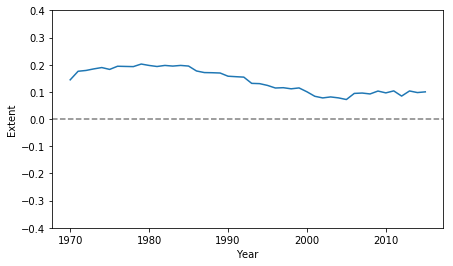

In [8]:
import matplotlib.pyplot as plt
#figsize=(80,20)
fig=plt.figure(figsize=(7,4))
ax1 = fig.add_subplot(111)
year_list = ['1960','1970','1980','1990','2000','2010','2020']
ax1.plot(-V[:,2])
ax1.set_xticklabels(year_list)
ax1.set_ylabel("Extent")
ax1.axhline(y=0.0, color='grey', linestyle='--')
ax1.set_ylim([-.4,.4])
ax1.set_xlabel("Year")
plt.show()


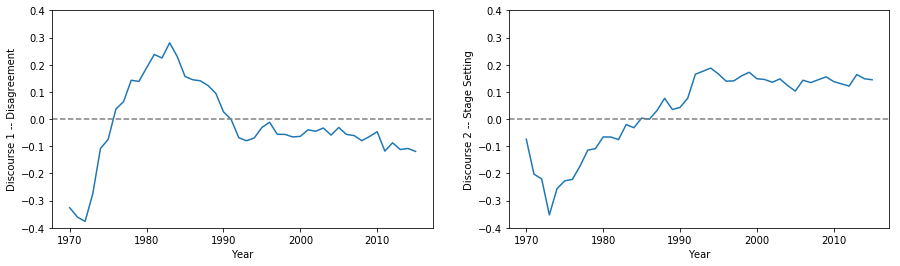

In [9]:
import matplotlib.pyplot as plt
#figsize=(80,20)
fig=plt.figure(figsize=(15,4))
year_list = ['1960','1970','1980','1990','2000','2010','2020']
ax1 = fig.add_subplot(121)
ax1.plot(-V[:,0])
ax1.set_xticklabels(year_list)
ax1.set_ylabel("Discourse 1 -- Disagreement")
ax1.axhline(y=0.0, color='grey', linestyle='--')
ax1.set_ylim([-.4,.4])
ax1.set_xlabel("Year")
ax2 = fig.add_subplot(122)
ax2.plot(-V[:,1])
ax2.set_xticklabels(year_list)
ax2.set_ylabel("Discourse 2 -- Stage Setting")
ax2.axhline(y=0.0, color='grey', linestyle='--')
ax2.set_ylim([-.4,.4])
ax2.set_xlabel("Year")

#fig, ax = plt.subplots(1,3,2)
#year_list = ['1960','1970','1980','1990','2000','2010','2020']
#ax.plot(V[:,1])
#ax.set_xticklabels(year_list)
plt.show()



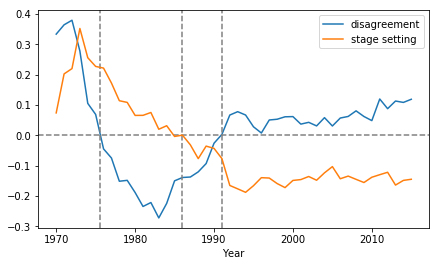

In [292]:
import matplotlib.pyplot as plt
#figsize=(80,20)
fig=plt.figure(figsize=(7,4))
year_list = ['1960','1970','1980','1990','2000','2010','2020']
ax1 = fig.add_subplot(111)
ax1.plot(V[:,0],label="disagreement")
ax1.set_xticklabels(year_list)
ax1.axhline(y=0.0, color='grey', linestyle='--')
ax1.axvline(x=5.5, color='grey', linestyle='--')
ax1.axvline(x=16, color='grey', linestyle='--')
ax1.axvline(x=21, color='grey', linestyle='--')
ax1.plot(-V[:,1], label="stage setting")
ax1.set_xticklabels(year_list)
ax1.set_xlabel("Year")

#fig, ax = plt.subplots(1,3,2)
#year_list = ['1960','1970','1980','1990','2000','2010','2020']
#ax.plot(V[:,1])
#ax.set_xticklabels(year_list)
plt.legend()
plt.show()



## Discourse: The R Matrix

In [301]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import numpy.linalg as l

print(R.shape)


words= ['_cardinal', '_developing_country', '_general_assembly', '_human_right', '_international_community', '_interrogative', '_modal', '_negate', '_pronoun', '_quantifier', '_security_council', '_south_africa', '_stopword', '_superlative', '_united_nations', '_united_states', 'action', 'africa', 'agreement', 'assembly', 'become', 'believe', 'charter', 'conference', 'conflict', 'cooperation', 'country', 'delegation', 'democratic', 'developed', 'development', 'economic', 'efforts', 'ensure', 'fact', 'foreign', 'future', 'global', 'government', 'hope', 'human', 'independence', 'international', 'just', 'law', 'made', 'means', 'measures', 'member', 'military', 'national', 'nations', 'need', 'negotiations', 'new', 'now', 'nuclear', 'order', 'organization', 'own', 'peace', 'people', 'policy', 'political', 'present', 'president', 'principles', 'problem', 'process', 'progress', 'recent', 'regard', 'region', 'relations', 'republic', 'resolution', 'resources', 'respect', 'right', 'role', 'secretary-general', 'security', 'session', 'situation', 'social', 'solution', 'state', 'support', 'system', 'take', 'time', 'today', 'trade', 'view', 'war', 'weapons', 'wish', 'work', 'world', 'year']
s = pd.Series(words)
df = pd.DataFrame()
df[0]=s
df[1]=R[:,2]
df[2]=R[:,0]
df[3]=-1*R[:,1]
df[4]= (R[:,0]+2*R[:,1])/2.236
df.columns=["Words","Extent","Disagreement","Stage Setting","Post 1990"]
#df.head(10)
#df["Disagreement"]=-1*df["Disagreement"]
#df["Stage Setting"]=-1*df["Stage Setting"]
#df=df.sort_values("Extent",ascending=False)
#df.head(10)

post= (R[:,0]-2*R[:,1])/2.236
#df["Post_1990"] = pd.Series(post)
#df=df.sort_values("Post_1990",ascending=False)
df.head(10)

#print(l.norm(post))


(100, 3)


Words    Extent  Disagreement  Stage Setting  Post 1990
0                 _cardinal  0.003572      0.010787      -0.006321   0.010478
1       _developing_country  0.002385      0.019515      -0.029055   0.034716
2         _general_assembly  0.002385      0.004761       0.004627  -0.002009
3              _human_right  0.002131     -0.116512       0.058079  -0.104057
4  _international_community  0.002418     -0.133747       0.021556  -0.079096
5            _interrogative  0.005979      0.093233       0.045682   0.000836
6                    _modal  0.021679      0.074660       0.036513   0.000731
7                   _negate  0.016006      0.418296      -0.071942   0.251422
8                  _pronoun  0.075725      0.234394       0.898092  -0.698475
9               _quantifier  0.017523      0.370078      -0.021486   0.184727

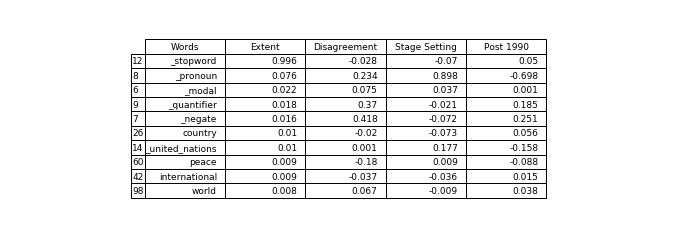

In [328]:
from pandas.plotting import table

df=df.sort_values("Extent",ascending=False)
df=df.round(3)
dg = df.head(10)
fig, ax = plt.subplots(figsize=(12, 4)) # set size frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis
ax.set_frame_on(False)  # no visible frame, uncomment if size is ok
tabla = table(ax, dg, loc='center', colWidths=[0.10]*len(df.columns))  # where df is your data frame
tabla.auto_set_font_size(False) # Activate set fontsize manually
tabla.set_fontsize(9) # if ++fontsize is necessary ++colWidths
tabla.scale(1.2, 1.2) # change size table

plt.savefig('extent.png', transparent=False)
plt.show()

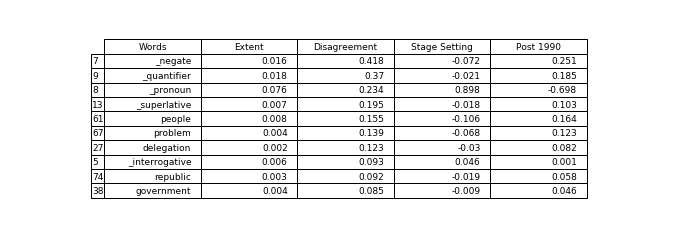

In [334]:
from pandas.plotting import table

df=df.sort_values("Disagreement",ascending=False)
df=df.round(3)
dg = df.head(10)
fig, ax = plt.subplots(figsize=(12, 4)) # set size frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis
ax.set_frame_on(False)  # no visible frame, uncomment if size is ok
tabla = table(ax, dg, loc='center', colWidths=[0.12]*len(df.columns))  # where df is your data frame
tabla.auto_set_font_size(False) # Activate set fontsize manually
tabla.set_fontsize(9) # if ++fontsize is necessary ++colWidths
tabla.scale(1.2, 1.2) # change size table

plt.savefig('disagreement.png', transparent=False)
plt.show()

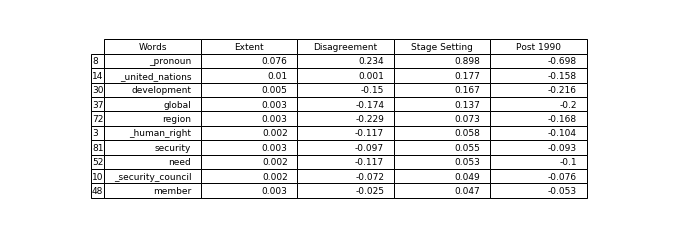

In [335]:
from pandas.plotting import table

df=df.sort_values("Stage Setting",ascending=False)
df=df.round(3)
dg = df.head(10)
fig, ax = plt.subplots(figsize=(12, 4)) # set size frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis
ax.set_frame_on(False)  # no visible frame, uncomment if size is ok
tabla = table(ax, dg, loc='center', colWidths=[0.12]*len(df.columns))  # where df is your data frame
tabla.auto_set_font_size(False) # Activate set fontsize manually
tabla.set_fontsize(9) # if ++fontsize is necessary ++colWidths
tabla.scale(1.2, 1.2) # change size table

plt.savefig('stage.png', transparent=False)
plt.show()

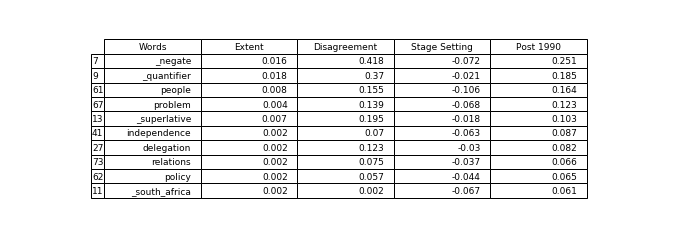

In [336]:
from pandas.plotting import table

df=df.sort_values("Post 1990",ascending=False)
df=df.round(3)
dg = df.head(10)
fig, ax = plt.subplots(figsize=(12, 4)) # set size frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis
ax.set_frame_on(False)  # no visible frame, uncomment if size is ok
tabla = table(ax, dg, loc='center', colWidths=[0.12]*len(df.columns))  # where df is your data frame
tabla.auto_set_font_size(False) # Activate set fontsize manually
tabla.set_fontsize(9) # if ++fontsize is necessary ++colWidths
tabla.scale(1.2, 1.2) # change size table

plt.savefig('post.png', transparent=False)
plt.show()

In [290]:
df=df.sort_values("Disagreement",ascending=False)
df.head(10)

Words    Extent  Disagreement  Stage Setting  Post 1990
7          _negate  0.016006      0.418296      -0.071942  -0.251422
9      _quantifier  0.017523      0.370078      -0.021486  -0.184727
8         _pronoun  0.075725      0.234394       0.898092   0.698475
13    _superlative  0.007256      0.195119      -0.017502  -0.102917
61          people  0.007855      0.154848      -0.106416  -0.164437
67         problem  0.004106      0.138558      -0.068058  -0.122842
27      delegation  0.001905      0.122609      -0.030209  -0.081854
5   _interrogative  0.005979      0.093233       0.045682  -0.000836
74        republic  0.003124      0.091837      -0.018888  -0.057967
38      government  0.004032      0.085068      -0.009002  -0.046097

In [291]:
df=df.sort_values("Stage Setting",ascending=False)
df.head(10)

Words    Extent  Disagreement  Stage Setting  Post 1990
8            _pronoun  0.075725      0.234394       0.898092   0.698475
14    _united_nations  0.009651      0.001477       0.177352   0.157973
30        development  0.005316     -0.149621       0.166945   0.216240
37             global  0.002626     -0.173719       0.136789   0.200044
72             region  0.003112     -0.229497       0.072545   0.167525
3        _human_right  0.002131     -0.116512       0.058079   0.104057
81           security  0.003348     -0.097336       0.055232   0.092934
52               need  0.002117     -0.117156       0.053336   0.100102
10  _security_council  0.002012     -0.071980       0.049350   0.076333
48             member  0.002990     -0.025473       0.046666   0.053133

In [284]:
year_list=['1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015']

## Nations: The L Matrix

In [341]:
nation_list=['AFG', 'AGO', 'ALB', 'AND', 'ARE', 'ARG', 'ARM', 'ATG', 'AUS', 'AUT', 'AZE', 'BDI', 'BEL', 'BEN', 'BFA', 'BGD', 'BGR', 'BHR', 'BHS', 'BIH', 'BLR', 'BLZ', 'BOL', 'BRA', 'BRB', 'BRN', 'BTN', 'BWA', 'CAF', 'CAN', 'CHE', 'CHL', 'CHN', 'CIV', 'CMR', 'COD', 'COG', 'COL', 'COM', 'CPV', 'CRI', 'CSK', 'CUB', 'CYP', 'CZE', 'DDR', 'DEU', 'DJI', 'DMA', 'DNK', 'DOM', 'DZA', 'ECU', 'EGY', 'ERI', 'ESP', 'EST', 'ETH', 'EU', 'FIN', 'FJI', 'FRA', 'FSM', 'GAB', 'GBR', 'GEO', 'GHA', 'GIN', 'GMB', 'GNB', 'GNQ', 'GRC', 'GRD', 'GTM', 'GUY', 'HND', 'HRV', 'HTI', 'HUN', 'IDN', 'IND', 'IRL', 'IRN', 'IRQ', 'ISL', 'ISR', 'ITA', 'JAM', 'JOR', 'JPN', 'KAZ', 'KEN', 'KGZ', 'KHM', 'KIR', 'KNA', 'KOR', 'KWT', 'LAO', 'LBN', 'LBR', 'LBY', 'LCA', 'LIE', 'LKA', 'LSO', 'LTU', 'LUX', 'LVA', 'MAR', 'MCO', 'MDA', 'MDG', 'MDV', 'MEX', 'MHL', 'MKD', 'MLI', 'MLT', 'MMR', 'MNE', 'MNG', 'MOZ', 'MRT', 'MUS', 'MWI', 'MYS', 'NAM', 'NER', 'NGA', 'NIC', 'NLD', 'NOR', 'NPL', 'NRU', 'NZL', 'OMN', 'PAK', 'PAN', 'PER', 'PHL', 'PLW', 'PNG', 'POL', 'PRK', 'PRT', 'PRY', 'PSE', 'QAT', 'ROU', 'RUS', 'RWA', 'SAU', 'SDN', 'SEN', 'SGP', 'SLB', 'SLE', 'SLV', 'SMR', 'SOM', 'SSD', 'STP', 'SUR', 'SVK', 'SVN', 'SWE', 'SWZ', 'SYC', 'SYR', 'TCD', 'TGO', 'THA', 'TJK', 'TKM', 'TLS', 'TON', 'TTO', 'TUN', 'TUR', 'TUV', 'TZA', 'UGA', 'UKR', 'URY', 'USA', 'UZB', 'VAT', 'VCT', 'VEN', 'VNM', 'VUT', 'WSM', 'YDYE', 'YEM', 'YUG', 'ZAF', 'ZMB', 'ZWE']

In [649]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=5,covariance_type='full').fit(L)
X = gmm.predict(L)
print(gmm.means_)
print(gmm.covariances_)
print(gmm.weights_)
print(X)

[[ 0.04509519 -0.00767361  0.08156884]
 [-0.04868425  0.07125414  0.04260163]
 [-0.04282844  0.00270619  0.06582075]
 [-0.02017038 -0.02735714  0.07665327]
 [ 0.04994019  0.06768726  0.06342908]]
[[[  9.13978314e-04  -7.10751853e-04   5.60526186e-05]
  [ -7.10751853e-04   7.46531498e-03  -5.32619368e-04]
  [  5.60526186e-05  -5.32619368e-04   2.82943445e-04]]

 [[  2.58193802e-04  -5.55567673e-04   7.88190324e-05]
  [ -5.55567673e-04   1.28763843e-03  -2.14181115e-04]
  [  7.88190324e-05  -2.14181115e-04   1.35605295e-04]]

 [[  1.35679236e-03  -7.78482206e-04  -1.20505277e-04]
  [ -7.78482206e-04   8.80496152e-04   3.53926673e-04]
  [ -1.20505277e-04   3.53926673e-04   2.29730288e-04]]

 [[  4.75845102e-03   1.79662273e-03  -2.03200214e-04]
  [  1.79662273e-03   2.45372152e-03  -2.23824814e-04]
  [ -2.03200214e-04  -2.23824814e-04   6.23389269e-05]]

 [[  7.75542164e-03  -3.63616509e-03   8.93614944e-04]
  [ -3.63616509e-03   2.75741687e-03  -2.84352992e-04]
  [  8.93614944e-04  -2.84

In [716]:
## import math
from matplotlib.patches import Ellipse

def createEllipse(m, P):
    print(type(P))
    U, s , Vh = np.linalg.svd(P)
    #print("height "+ str(math.sqrt(s[0])*6))
    #print("weight "+ str(math.sqrt(s[1])*6))    
    orient = math.atan2(U[1,0],U[0,0])
    orient=(orient*360/(2*3.141))
    #print("angle "+ str(orient))
    ellipse = Ellipse(xy=(m[0],m[1]), height=math.sqrt(s[0])*6,width=math.sqrt(s[1])*6, angle=orient, ec= 'black', lw=2., alpha = 0.07, zorder=0) 

    return ellipse



<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


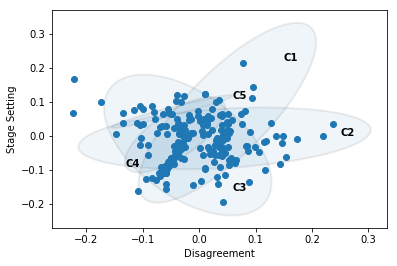

In [718]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import math

fig, ax = plt.subplots()
ellipse_list = []
x, y = L[:,0], -L[:,1]
w = [0.15, 0.25, 0.06, -0.13, 0.06]
z = [0.22, 0.00, -0.16, -0.09, 0.11]
cluster_labels = ["C1", "C2", "C3", "C4", "C5"]
for i in range(5):
    P= gmm.covariances_[i][0:2,0:2] 
    m = gmm.means_[i][0:2]
    ellipse=createEllipse(m,P)
    ax.add_patch(ellipse)
ax.set_xlabel("Disagreement")
ax.set_ylabel("Stage Setting")
plt.scatter(x, y)
for ll, ww, zz in zip(cluster_labels, w, z):
    plt.annotate(ll, xy=(ww,zz), xytext=(0,0), textcoords = "offset points", weight = 'bold')

plt.savefig('cluster.png', transparent=False)
plt.show()

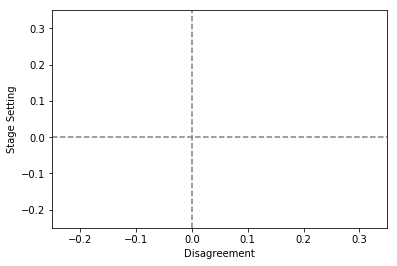

In [699]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import math

fig, ax = plt.subplots()

ax.set_xlabel("Disagreement")
ax.set_ylabel("Stage Setting")
ax.set_xlim([-.25,.35])
ax.set_ylim([-.25,.35])
ax.axhline(y=0.0, color='grey', linestyle='--')
ax.axvline(x=0.0, color='grey', linestyle='--')
plt.savefig('quadrants.png', transparent=False)
plt.show()

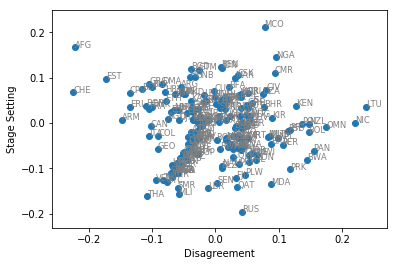

In [584]:
n = nation_list
x = L[:,0]
y = -L[:,1]
fig, ax = plt.subplots()
ax.scatter(x, y)
font = {'family': 'serif',
        'color':  'grey',
        'weight': 'normal',
        'size': 8,
        }
for i, txt in enumerate(n):
    ax.annotate(txt, (x[i],y[i]), size='small', color='grey')
ax.set_xlabel("Disagreement")
ax.set_ylabel("Stage Setting")
plt.savefig('nations.png', transparent=False)
plt.show()

In [700]:
df = pd.DataFrame()
df["names"] = nation_list
df["labels"]= X
df.loc[df['labels'] == 0]


names  labels
13    BEN       0
17    BHR       0
21    BLZ       0
28    CAF       0
33    CIV       0
34    CMR       0
38    COM       0
40    CRI       0
41    CSK       0
51    DZA       0
72    GRD       0
80    IND       0
82    IRN       0
83    IRQ       0
91    KEN       0
95    KNA       0
96    KOR       0
97    KWT       0
109   MAR       0
110   MCO       0
112   MDG       0
120   MNE       0
129   NGA       0
141   PLW       0
148   QAT       0
150   RUS       0

In [701]:
df.loc[df['labels'] == 1]

names  labels
43    CYP       1
50    DOM       1
156   SLB       1
160   SOM       1
161   SSD       1
162   STP       1
163   SUR       1
164   SVK       1
166   SWE       1
167   SWZ       1
168   SYC       1
169   SYR       1
170   TCD       1
171   TGO       1
174   TKM       1
175   TLS       1
177   TTO       1
178   TUN       1
179   TUR       1
180   TUV       1
181   TZA       1
182   UGA       1
183   UKR       1
184   URY       1
185   USA       1
186   UZB       1
187   VAT       1
188   VCT       1
191   VUT       1
192   WSM       1
193  YDYE       1
194   YEM       1
195   YUG       1
196   ZAF       1
197   ZMB       1
198   ZWE       1

In [587]:
df.loc[df['labels'] == 2]

names  labels
0     AFG       2
1     AGO       2
3     AND       2
4     ARE       2
5     ARG       2
6     ARM       2
7     ATG       2
8     AUS       2
9     AUT       2
10    AZE       2
11    BDI       2
12    BEL       2
14    BFA       2
15    BGD       2
16    BGR       2
18    BHS       2
19    BIH       2
20    BLR       2
23    BRA       2
24    BRB       2
25    BRN       2
26    BTN       2
30    CHE       2
31    CHL       2
32    CHN       2
35    COD       2
36    COG       2
37    COL       2
39    CPV       2
41    CSK       2
..    ...     ...
107   LUX       2
109   MAR       2
113   MDV       2
114   MEX       2
115   MHL       2
116   MKD       2
118   MLT       2
121   MNG       2
123   MRT       2
124   MUS       2
125   MWI       2
126   MYS       2
128   NER       2
131   NLD       2
132   NOR       2
133   NPL       2
134   NRU       2
135   NZL       2
138   PAN       2
139   PER       2
143   POL       2
144   PRK       2
147   PSE       2
149   ROU       2
151   RWA       2
152   SAU       2
153   SDN       2
157   SLE       2
174   TKM       2
176   TON       2

[109 rows x 2 columns]

In [702]:
df.loc[df['labels'] == 3]

names  labels
0     AFG       3
1     AGO       3
3     AND       3
4     ARE       3
5     ARG       3
6     ARM       3
8     AUS       3
9     AUT       3
10    AZE       3
11    BDI       3
12    BEL       3
14    BFA       3
15    BGD       3
16    BGR       3
18    BHS       3
19    BIH       3
20    BLR       3
24    BRB       3
25    BRN       3
26    BTN       3
30    CHE       3
31    CHL       3
32    CHN       3
35    COD       3
36    COG       3
39    CPV       3
42    CUB       3
44    CZE       3
46    DEU       3
47    DJI       3
..    ...     ...
92    KGZ       3
93    KHM       3
98    LAO       3
99    LBN       3
101   LBY       3
102   LCA       3
103   LIE       3
104   LKA       3
105   LSO       3
107   LUX       3
113   MDV       3
114   MEX       3
115   MHL       3
116   MKD       3
118   MLT       3
121   MNG       3
123   MRT       3
124   MUS       3
126   MYS       3
128   NER       3
131   NLD       3
132   NOR       3
134   NRU       3
138   PAN       3
144   PRK       3
149   ROU       3
151   RWA       3
157   SLE       3
176   TON       3
190   VNM       3

[89 rows x 2 columns]

In [703]:
df.loc[df['labels'] == 4]

names  labels
22    BOL       4
23    BRA       4
27    BWA       4
60    FJI       4
85    ISR       4
88    JOR       4
94    KIR       4
100   LBR       4
106   LTU       4
108   LVA       4
111   MDA       4
117   MLI       4
119   MMR       4
125   MWI       4
127   NAM       4
130   NIC       4
133   NPL       4
135   NZL       4
136   OMN       4
137   PAK       4
139   PER       4
140   PHL       4
142   PNG       4
143   POL       4
145   PRT       4
146   PRY       4
147   PSE       4
152   SAU       4
153   SDN       4
154   SEN       4
155   SGP       4
159   SMR       4
172   THA       4
173   TJK       4
189   VEN       4

In [ ]:
df.loc[df['names'] == "GBR"]

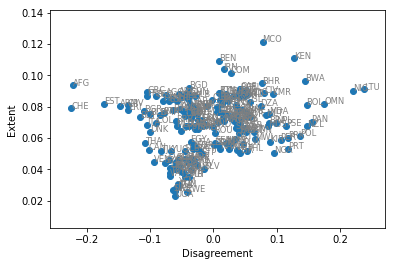

In [359]:
n = nation_list
x = L[:,0]
z = L[:,2]
fig, ax = plt.subplots()
ax.scatter(x, z)

for i, txt in enumerate(n):
    ax.annotate(txt, (x[i],z[i]), size='small', color='grey')
ax.set_xlabel("Disagreement")
ax.set_ylabel("Extent")
plt.savefig('nations.png', transparent=False)
plt.show()

In [344]:
import sklearn as sk

mds_model = sk.manifold.MDS(2)
pos = mds_model.fit(L).embedding_

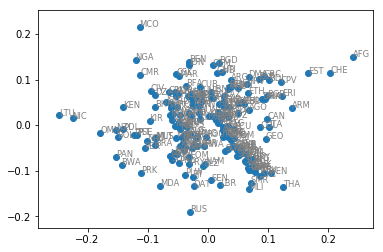

In [352]:
n = nation_list
x = pos[:,0]
y = pos[:,1]
fig, ax = plt.subplots()
ax.scatter(x, y)
font = {'family': 'serif',
        'color':  'grey',
        'weight': 'normal',
        'size': 8,
        }
for i, txt in enumerate(n):
    ax.annotate(txt, (x[i],y[i]), size='small', color='grey')
plt.savefig('nations.png', transparent=False)
plt.show()

In [34]:
import numpy as np
import scipy.sparse.linalg as l

A = np.random.rand(10,9,8,7)
print(A)
print("A "+str(A.shape))
# Choose initial R, V with orthonormal columns
r1, r2, r3, r4 = 5,4,3,2

R_init = np.random.rand(9,9)
u,w,RT = l.svds(R_init,r2)
R = RT.T
print("R "+str(R.shape))

V_init = np.random.rand(8,8)
u,w,VT = l.svds(V_init,r3)
V = VT.T
print("V "+str(V.shape))

W_init = np.random.rand(7,7)
u,w,WT = l.svds(W_init,r4)
W = WT.T
print("W "+str(W.shape))

for i in range(10):
    C2 = np.tensordot(A,R,axes=(1,0))
    print("C2 "+str(C2.shape))
    C1 = np.tensordot(C2,V,axes=(1,0))
    print("C1 "+str(C1.shape))
    C0 = np.tensordot(C1,W,axes=(1,0))
    print("C0 "+str(C0.shape))  
    C = C0.reshape(10,24)
    print("C "+str(C.shape))
    L,w,v = l.svds(C,r1)
    print("L "+str(L.shape))
    
    D2 = np.tensordot(A,L,axes=(0,0))
    print("D2 "+str(D2.shape))
    D1 = np.tensordot(D2,V,axes=(1,0))
    print("D1 "+str(D1.shape))
    D0 = np.tensordot(D1,W,axes=(1,0))
    print("D0 "+str(D0.shape))    
    D = D0.reshape(9,30)
    R,w,v = l.svds(D,r2)
    print("R "+str(R.shape))
    
    E2 = np.tensordot(A,L,axes=(0,0))
    print("E2 "+str(E2.shape))
    E1 = np.tensordot(E2,R,axes=(0,0))
    print("E1 "+str(E1.shape))
    E0 = np.tensordot(E1,W,axes=(1,0))
    print("E0 "+str(E0.shape))
    E = E0.reshape(8,40)
    print("E "+str(E.shape))
    V,w,v=l.svds(E,r3)
    
    print("W "+str(W.shape))
    F2 = np.tensordot(A,L,axes=(0,0))
    print("F2 "+str(F2.shape))
    F1 = np.tensordot(F2,R,axes=(0,0))
    print("F1 "+str(E1.shape))
    F0 = np.tensordot(F1,V,axes=(0,0))
    print("F0 "+str(F0.shape))
    F = F0.reshape(7,60)
    print("F "+str(F.shape))
    W,w,v=l.svds(F,r4)
    print("W "+str(W.shape))

print(" ")
B = np.tensordot(F0,W,axes=(0,0))
print("B "+str(B.shape))
M2 = np.tensordot(B,L,axes=(0,1))
print("M2 "+str(M2.shape))
M1 = np.tensordot(M2,R,axes=(0,1))
print("M1 "+str(M1.shape))
M0 = np.tensordot(M1,V,axes=(0,1))
print("M0 "+str(M.shape))
M = np.tensordot(M0,W,axes=(0,1))
print("M "+str(M.shape))
print(M)
AA = (A-M)*(A-M)
print(sum(sum(sum(sum(AA)))))

[[[[  7.30097468e-01   4.96102462e-01   2.59137835e-01 ...,
      8.87478495e-01   5.80649152e-01   9.67882474e-01]
   [  1.87664856e-01   4.67079695e-01   3.96329368e-01 ...,
      2.89935230e-01   5.06476801e-01   9.00170023e-01]
   [  6.24624978e-01   8.07847903e-01   5.23283315e-01 ...,
      7.17227782e-01   2.92665644e-01   7.74372682e-02]
   ..., 
   [  3.52375245e-01   3.53745198e-01   1.46093642e-01 ...,
      5.17862413e-01   5.76041620e-01   4.09394543e-01]
   [  6.28031000e-01   6.58469399e-01   3.37142946e-01 ...,
      5.61450402e-01   6.15734471e-01   8.49483369e-01]
   [  9.69739100e-01   5.48272298e-01   7.43038064e-01 ...,
      9.63318120e-01   9.43655715e-01   7.41801065e-01]]

  [[  7.77709195e-01   2.75289920e-01   3.48779442e-01 ...,
      3.65606071e-01   2.83847501e-01   6.34591360e-01]
   [  8.92164378e-01   4.43304715e-01   3.19984379e-02 ...,
      9.57917809e-01   9.86714788e-02   7.23310559e-01]
   [  4.69270591e-01   5.84489940e-01   8.64394636e-01 ...,
 

In [39]:
import numpy as np
import scipy.sparse.linalg as l

def hooi4D(A,dim,n): 
    (x,y,z,w)=A.shape
    (r1,r2,r3,r4)=dim

    R_init = np.random.rand(r2,r2)
    u,w,RT = l.svds(R_init,r2)
    R = RT.T

    V_init = np.random.rand(r3,r3)
    u,w,VT = l.svds(V_init,r3)
    V = VT.T

    W_init = np.random.rand(r4,r4)
    u,w,WT = l.svds(W_init,r4)
    W = WT.T

    for i in range(n):
        C2 = np.tensordot(A,R,axes=(1,0))
        C1 = np.tensordot(C2,V,axes=(1,0))
        C0 = np.tensordot(C1,W,axes=(1,0))  
        C = C0.reshape(r1,r2*r3*r4)
        L,w,v = l.svds(C,r1)
    
        D2 = np.tensordot(A,L,axes=(0,0))
        D1 = np.tensordot(D2,V,axes=(1,0))
        D0 = np.tensordot(D1,W,axes=(1,0))   
        D = D0.reshape(r2,r1*r3*r4)
        R,w,v = l.svds(D,r2)
    
        E2 = np.tensordot(A,L,axes=(0,0))
        E1 = np.tensordot(E2,R,axes=(0,0))
        E0 = np.tensordot(E1,W,axes=(1,0))
        E = E0.reshape(r3,r1*r2*r4)
        V,w,v=l.svds(E,r3)
    
        F2 = np.tensordot(A,L,axes=(0,0))
        F1 = np.tensordot(F2,R,axes=(0,0))
        F0 = np.tensordot(F1,V,axes=(0,0))
        F = F0.reshape(r4,r1*r2*r3)
        W,w,v=l.svds(F,r4)

    B = np.tensordot(F0,W,axes=(0,0))
    M2 = np.tensordot(B,L,axes=(0,1))
    M1 = np.tensordot(M2,R,axes=(0,1))
    M0 = np.tensordot(M1,V,axes=(0,1))
    M = np.tensordot(M0,W,axes=(0,1))

    AA = (A-M)*(A-M)
    a=sum(sum(sum(sum(AA))))
    model = (B,L,R,V,W)
    converge = (a,M)
    
    return model, converge
